In [1]:
using Statistics

using DifferentialEquations

using ParameterizedFunctions

using Plots


#using OrdinaryDiffEq
#using Pkg
#ENV["GRDIR"]=""
#Pkg.build("GR")

In [2]:
# here experiment with integration of detailed metabol

#aligned ephys to Calvetti2018 and add metabolism based on Calvetti2018
# later add Somjen 2008

#### changes history 13 02 2019

#1)
# psiGPa_a GPa and GPb to changing u[..] 
#const VmaxHK_n = 9.36/2 -> const VmaxHK_n = 9.36

#2) 1123
# du[33] =   (1/eto_a) * ( 2*psiGlc_a  + (-1)*psiLDH1_a + psiLDH2_a + 5*psiTCA_a + (-2)*psiOxphos_a )  # u33 = NADH_a -> du[33] = (1/eto_a) * ( 2*psiGAPDH_a + (-1)*psiLDH1_a + psiLDH2_a + 5*psiTCA_a + (-2)*psiOxphos_a )  # u33 = NADH_a
# du[35] = (1/eto_a) * ( -2*psiGlc_a + psiLDH1_a + (-1)*psiLDH2_a -5*psiTCA_a + 2*psiOxphos_a )  # u35 = NAD_a -> du[35] = (1/eto_a) * ( -2*psiGAPDH_a + psiLDH1_a + (-1)*psiLDH2_a -5*psiTCA_a + 2*psiOxphos_a )  # u35 = NAD_a
# du[58] =  (1/eto_a)*(psiGlc_a )  # PEP_a -> du[58] = (1/eto_a) * ( 2*psiENOL_a + (-2)*psiPK_a )# PEP_a
    
#3) 
# todo check which of u[33,35,58] complicates calculations the most
# 33 is crucial


#4) 
# ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) * psiGAPDH because of Pi

#### changes history 25-26 02 2019

#5) correct psiGAPDH_a 
#G6P_a = 0.75 instead of 1.0 


# add energy metabolism eq from Bistability in Glycolysis Pathway as a Physiological Switch in Energy Metabolism Bhanu Chandra Mulukutla2014
# from Mulukutla2014
#replace previous: psiHK_a, psiPGI_a, # later replace psiPFK_a, psiALD_a, psiTPI_a, psiGAPDH_a, psiPGK_a, psiPGM_a, psiENOL_a, psiPK_a
#later add new reactions: PFKFB (psiPFK2_a, psiF26BPase_a)
# present in Mulukutla2014 but I keep ini from Calvetti2018: LDH, GLUT(glucose transporter)

# /60000 -> /60

#check param units for psiPDE

# check GSAJay and glyc: set glyc to Jay's

In [3]:
# grid version 

const R = 8.31 # J/(K*mol)
const T = 310.0 # Kelvin, temperature 310K is 37 C 
const F = 96.485 # 96485.0  C/mol  # FARADAY = 96485.309 (coul) in Somjen2008
#const Fglut = 96485.0  # C/mol  is for V but use 96.485  for mV
# 8.31*310.0 /96.485 # 310K is 37 C # like this because of mV and mM

const Cm = 1.0 # uF/cm2 Calvetti2018 capacitance
const phi = 3.0 # 1/ms Calvetti2018 time constant

# Conductance param from Calvetti2018 and Cressman2011
const gNa = 100.0 # mS/cm2
const gK = 40.0 # mS/cm2
const gNa0leak = 0.0175 # mS/cm2
const gK0leak = 0.05 # mS/cm2
const gCl = 0.05 # mS/cm2

const beta = 1.33 # Calvetti2018; in Cressman2011 it was set to 7.0
const ksi_rest = 0.06 #0.15 #0.06 # 0.06 is for resting system # 2.5 #  Calvetti2018; external stimuli, 2.5 should give 90 Hz # this can be decreased for smaller Hz
const ksi_act =  2.5 #  Calvetti2018; external stimuli, 2.5 should give 90 Hz # this can be decreased for smaller Hz
const gamma = 0.0445 # Calvetti2018 mM*cm2/uC

#const rho=1.25 # Cressman2011
#const epsilon=1.333333333 # Cressman2011
#const kbath=4.0 # Cressman2011
#const glia=66.666666666 # Cressman2011
const rho=13.83 # mM/s # Calvetti2018
const epsilon=9.33 # 1/s # Calvetti2018
const kbath=6.3 # mM # Calvetti2018
const glia=20.75 # mM/s # Calvetti2018

const s_metabo_atpase = 0.15 # Calvetti2018 tuned this param from OGI
const H1_metabo_atpase = 0.071667 # mM/s # 4.3 #mM/min
const sigma_atpase = 103.0 # assumed by Calvetti2018
    
   
const mu_pump_ephys = 0.1 # Calvetti2018
const mu_glia_ephys = 0.1 # Calvetti2018

# volume fractions and blood related parameters (table 1) Calvetti2018
const eto_n = 0.4 # volume fraction neuron
const eto_a = 0.3 # volume fraction astrocyte
const eto_ecs = 0.3 # volume fraction ecs
const eto_b = 0.04 # volume fraction blood

const Hct = 0.45 # is the volume percentage (vol%) of red blood cells in blood.
const Hb = 5.18
const KH = 0.0364 #36.4*10^(-3) mM

const C_Glc_a = 5.0 # mM arterial concentration glucose
const C_Lac_a = 1.1 # mM arterial concentration lactate
const C_O_a = 9.14 # mM arterial concentration oxygen
const Fr_blood = 2/3 # "The numerical values used for the blood flow and the mixing ratio F are 0.9 l/min and 2/3, respectively" from Bayesian flux balance analysis applied to a skeletal muscle metabolic model 2007 Heino .. Calvetti ..

# table 2 Calvetti2018
const TbGlc = 0.02 # mM/s #0.00002 #mM/ms #
const TbLac = 0.17 # mM/s # 0.00017 #mM/ms# 
const lambda_b_O2 = 0.04 # mM^(1-k)/s # 0.00004 #mM^(1-k)/ms #
const TnGlc = 83.33 # mM/s # 0.08333  #mM/ms# 
const TnLac = 66.67 # mM/s # 0.06667  #mM/ms# 
const lambda_n_O2 = 0.94 # 1/s # 0.00094 #1/ms #
const TaGlc = 83.33 # mM/s # 0.08333 #mM/ms#
const TaLac = 66.67 # mM/s # 0.06667 #mM/ms#
const lambda_a_O2 = 0.68 # 1/s # 0.00068 #1/ms #

const tau = 1000.0 # Calvetti2018  #const tau = 1.0 # if all other things are in ms, actually, it's more complicated, so even in ms we need it 1000 # Calvetti2018

const KbGlc = 4.60 # mM
const KbLac = 5.00 # mM
const KnGlc = 5.00 # mM
const KnLac = 0.4 # mM
const KaGlc = 12500.0 # mM
const KaLac = 0.4 # mM

const V_oxphos_n = 8.18 # mM/s # 0.00818 #mM/ms # 
const V_oxphos_a = 2.55 # mM/s # 0.00255 #mM/ms # 
const K_oxphos_n = 1.0 #mM
const K_oxphos_a = 1.0 #mM
const mu_oxphos_n = 0.01
const mu_oxphos_a = 0.01
const nu_oxphos_n = 0.10
const nu_oxphos_a = 0.10

const V_Glc_n = 0.26 # mM/s # 0.00026 #mM/ms #
const V_Glc_a = 0.25 # mM/s # 0.00025 #mM/ms #
const K_Glc_n = 4.6 # mM
const K_Glc_a = 3.1 # mM
const mu_Glc_n = 0.09
const mu_Glc_a = 0.09
const nu_Glc_n = 10.00
const nu_Glc_a = 10.00

const V_LDH1_n = 0.26 # mM/s # 0.00026 #mM/ms #
const V_LDH1_a = 0.25 # mM/s # 0.00025 #mM/ms #
const K_LDH1_n = 4.6 # mM
const K_LDH1_a = 3.1 # mM
const nu_LDH1_n = 10.00
const nu_LDH1_a = 10.00
    
const V_LDH2_n = 0.26 # mM/s # 0.00026 #mM/ms #
const V_LDH2_a = 0.25 # mM/s # 0.00025 #mM/ms #
const K_LDH2_n = 4.6 # mM
const K_LDH2_a = 3.1 # mM
const nu_LDH2_n = 10.00
const nu_LDH2_a = 10.00

const V_TCA_n = 0.03 # mM/s # 0.00003 #mM/ms #
const V_TCA_a = 0.01 # mM/s # 0.00001 #mM/ms #
const K_TCA_n = 0.01 # mM
const K_TCA_a = 0.01 # mM
const mu_TCA_n = 0.01
const mu_TCA_a = 0.01
const nu_TCA_n = 10.00
const nu_TCA_a = 10.00

const V_Cr_n = 16666.67 # mM/s # 16.66667 #mM/ms #
const V_Cr_a = 16666.67 # mM/s # 16.66667 #mM/ms #
const K_Cr_n = 495.00 # mM
const K_Cr_a = 495.00 # mM
const mu_Cr_n = 0.01
const mu_Cr_a = 0.01

const V_PCr_n = 16666.67 # mM/s # 16.66667 #mM/ms #
const V_PCr_a = 16666.67 # mM/s # 16.66667 #mM/ms #
const K_PCr_n = 528.00 # mM
const K_PCr_a = 528.00 # mM
const mu_PCr_n = 100.00
const mu_PCr_a = 100.00




# Witthoft2013
const JNKCCmax = 0.07557 # mM/s Witthoft2013
const RdcKA = 0.15 # s^(-1)
const gKirS = 144 # pS Witthoft2013 proportionality constant for perisynaptic process KirAS conductance # check units
const EKirProc = 26.797 # mV Nernst const for perisyn proc KirAS channels # Witthoft2013
const Cast = 40.0 #pF Witthoft2013 # check units
const gLeakAst = 3.7 # pS Witthoft2013 # check units
const VleakAst = -40.0 # mV Witthoft2013
const gKirV = 25.0 #pS Witthoft2013 # check units
const EKirEndfoot = 31.147 # mV # Witthoft2013 # check units
const JNKAmax = 1.4593 # mM/sec
const KK0a = 16.0 #mM
const KNaiAst = 1.0 #mM


1.0

In [4]:
function ephys(du,u,p,t) # p
    """ ephys fine timestep (ms) model"""
    
    # u: 1,2,3,4,5,6,7,8,28-35,37
    #1:V, 2:m, 3:h, 4:n, 5:Conc_Cl_out, 6:Conc_Cl_in, 7:Na0in, 8:K0out, 28:ATP_n, 29:ATP_a, 30:ADP_n, 31:ADP_a, 32:NADH_n, 33:NADH_a, 34:NAD_n, 35:NAD_a, 37:ksi_ephys
    
    du[37] = 0 # placeholder for callback ksi
    ksi_ephys = u[37] # placeholder for callback activation related to glu # _ephys to be consistent with ms
    
    V = u[1]
    m = u[2]
    h = u[3]
    n = u[4]
    
    # Cressman2011, Calvetti2018
    alpha_m=0.1*(V+30.0)/(1.0-exp(-0.1*(V+30.0)))
    beta_m=4.0*exp(-(V+55.0)/18.0)
    alpha_h=0.07*exp(-(V+44.0)/20.0)
    beta_h=1.0/(1.0+exp(-0.1*(V+14.0)))
    alpha_n=0.01*(V+34.0)/(1.0-exp(-0.1*(V+34.0)))
    beta_n=0.125*exp(-(V+44.0)/80.0)
    
    # dm/dt
    du[2] = phi*(alpha_m * (1-m)  - beta_m*m )  # check if  should be just steady state as m(V) = alpha_m/(alpha_m+beta_m)
    #du[2] = 0
    #u[2] = 0.1*(V+30.0)/(1.0-exp(-0.1*(V+30.0))) / (  0.1*(V+30.0)/(1.0-exp(-0.1*(V+30.0)))    +     4.0*exp(-(V+55.0)/18.0) ) # approx due to fast reaching steady state
     
    # dh/dt
    du[3] = phi*(alpha_h * (1-h)  - beta_h*h)
    # dn/dt
    du[4] = phi*(alpha_n * (1-n)  - beta_n*n)
    
    # Concentrations Calvetti2018
    Naout = 144.0 - beta*(u[7] - 11.5) # mM  # u7 = Na0in
    Kin = 140.0 + (11.5 - u[7]) # u7 = Na0in
    
    # Nernst eq, Calvetti2018
    
    VCl = -26.64*log(clamp(u[5],1e-12,u[5])/clamp(u[6],1e-12,u[6])) # when ksi u5 = Conc_Cl_out, u6 = Conc_Cl_in # log=ln in Julia
    VK = 26.64*log(clamp(u[8],1e-12,u[8])/clamp(Kin,1e-12,Kin)) # clamp(x,1e-12,x) # u8 = K0out
    VNa = 26.64*log(clamp(Naout,1e-12,Naout)/clamp(u[7],1e-12,u[7])) # u7 = Na0in
    
    gNaleak = (1+ksi_ephys)*gNa0leak
    gKleak = (1+ksi_ephys)*gK0leak
    
    INa = gNa*(m^3)*h*(V-VNa) +  gNaleak*(V-VNa) # based on  Calvetti2018 gNaleak depends on ksi and glutamate activation # in Calvetti2018 & Cressman2009 m(V) = m_inf = alpha_m/(alpha_m+beta_m)
    IK = gK*(n^4)*(V-VK) + gKleak*(V-VK)  # based on Calvetti2018 gKleak depends on ksi and glutamate activation
    Ileak = gCl * (V-VCl)
    
    
    ### check if need to use u[..] instead of ATP ADP
    #p_n_ratio = clamp(ATP_n,1e-12,ATP_n)/clamp(ADP_n,1e-12,ADP_n) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ATP_a,1e-12,ATP_a)/clamp(ADP_a,1e-12,ADP_a)
    #r_n_ratio = clamp(NADH_n,1e-12,NADH_n)/clamp(NAD_n,1e-12,NAD_n) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(NADH_a,1e-12,NADH_a)/clamp(NAD_a,1e-12,NAD_a)
    
    p_n_ratio = clamp(u[28],1e-12,u[28])/clamp(u[30],1e-12,u[30]) #u28 = ATP_n # u30 = ADP_n
    p_a_ratio = clamp(u[29],1e-12,u[29])/clamp(u[31],1e-12,u[31])
    r_n_ratio = clamp(u[32],1e-12,u[32])/clamp(u[34],1e-12,u[34]) # u32 = NADH_n # u34 = NAD_n
    r_a_ratio = clamp(u[33],1e-12,u[33])/clamp(u[35],1e-12,u[35])
    
  
    JpumpNa = (p_n_ratio/(mu_pump_ephys + p_n_ratio)) * (rho/(1+exp((25.0 -u[7])/3))) * (1/(1+exp(5.5 - u[8])))
    JgliaK = (p_a_ratio/(mu_glia_ephys + p_a_ratio)) * (glia/(1+exp((18.0 - u[8])/2.5)))
    JdiffK = epsilon*(u[8] - kbath)
    

    # changing conc of Na and K
    du[7] = (1/tau) * (-gamma*INa - 3*JpumpNa) # check if INa accessible for it; Calvetti2018 # Nain
    du[8] = (1/tau) * (gamma*beta*IK - 2*beta*JpumpNa - JgliaK - JdiffK)   # check if IK accessible for it; Calvetti2018 # Kout
    
    #Itildepump = (rho/(1.0+exp((25.0-u[7])/3.0)))*(1/(1+exp(5.5-u[8]))) # Cressman2011
    #Itildeglia = (glia/(1.0+exp((18.0-u[8])/2.5))) # Cressman2011
    #Itildediff = epsilon*(u[8]-kbath) # Cressman2011
    #du[7] = (1/tau)*(-gamma*INa-3.0*Itildepump) # Cressman2011 Nain
    #du[8]=(1/tau)*(gamma*beta*IK-2.0*beta*Itildepump-Itildeglia-Itildediff) # Cressman2011 Kout
    
    # dV/dt
    #du[1] = (1/Cm) * (u[5] - INa - IK - Ileak  ) 
    du[1] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    
    # Iinj
    #du[5] = 0 # placeholder for callback, which is an alternative to ksi
    

end


ephys (generic function with 1 method)

In [23]:

# Jay .mod Glucose conversion by multiple pathways in brain extract: theoretical and experimental analysis.  Orosz .. Ovadi
# the next to give the growth of Glc_a, sense a bit stimulus
const vm_hk_a = 7.6 /60000.0 # /60000 to convert from uM/min to mM/sec ### U/L = (μmol/min)/L = uM/min (mol/L = M)
const kmS_hk_a = 8.0 /1000.0  # 8.0 # uM  /1000 -> mM

#const vm_hk_a = 0.05 # mM/s Cloutier 2009
#const kmS_hk_a = 0.105 # mM/s Cloutier 2009

# try to adjust from different sources mentioned in Berndt for Glycolysis rate of Calvetti
#const vm_hk_a = 9.36 # Berndt 2015
#const kmS_hk_a = 0.043  # Berndt 2015

#const vm_hk_a = 0.25 Glc_a goes down fast and then goes up diagonal
#const kmS_hk_a = 3.1 

# Berndt 2015
const VmaxHK_n = 9.36 /60000  # check units !!!   # was 9.36/2 changed here 130219
const KmglucoHK_n = 0.043
const KmatpHK_n = 0.37
const KiatpHK_n = 0.074
const Kig6pHK_n = 0.1

# Orosz .. Ovadi
# PGI
#const VmaxPGI_a = 539.0 /60000.0 # /60000 to convert from uM/min to mM/sec ### U/L = (μmol/min)/L = uM/min (mol/L = M)
#const KmSPGI_a = 392.0/1000.0 # uM  /1000 -> mM
#const KmPPGI_a = 359.0/1000.0 # uM  /1000 -> mM
#const KeqPGI_a = 0.327/1000.0 # uM  /1000 -> mM

# Cloutier 2009
#const VmaxPGIf_a = 0.5
#const VmaxPGIr_a = 0.45
#const KmPGI_fG6P_a = 0.5 
#const KmPGI_rF6P_a = 0.06


# Orosz .. Ovadi
# PFK
#const VmPFK_a = 82.0 /60000.0 # /60000 to convert from uM/min to mM/sec ### U/L = (μmol/min)/L = uM/min (mol/L = M)
#const KmSPFK_a = 15.0 /1000.0 # uM  /1000 -> mM

# Cloutier 2009




# Jay, Lambeth 4. Phosphoglucose isomerase (PGI):  Glucose-6-P <--> Fructose-6-P    
#const KeqPGI = 0.45 # ref 28  ? seems to be M, but corrected in rate equation by *1000.0 to mM
#const KG6PPGI = 0.48 # ref 49 Mouse
#const KF6PPGI = 0.031 # ref 31 Rabbit
##Vmaxfpgi =  0.88 # M/min ref 55 Pig  #
#const Vmaxrpgi = 880.0 # seems to be mM/min but corrected in rate equation by /60.0
#const Vmaxfpgi = (Vmaxrpgi*KG6PPGI*KeqPGI)/KF6PPGI # it is correct, see the paper

# # JayGliaExpand  # 5. Phosphofructokinase ; Fructose-6-P1SATP <--> Fructose-1,6-P1SADP 
const KeqPFK = 242.0 # ref 28 unitless
const KF6PPFK = 0.18 # ref 40 Rabbit
const KF6PPFK2 = 20.0 # ref 40
const KATPPFK = 0.08 # ref 40 
const KATPPFK2 = 0.25 # ref 40 
const KFBPPFK = 4.02 # ref 36 Rabbit
const KFBPPFK2 = 4.02
const KADPPFK = 2.71 # ref 36
const KADPPFK2 = 2.7 
const KiATPPFK = 0.87 # ref 40 
const KaAMP = 0.06
const d = 0.01 # ref 40 unitless
const el = 0.01 # from paper
const ePFK = 0.01 # unitless
const Lo = 13.0 # ref 40 unitless
const Vmaxfpfk =  56.0 # 0.056 # M/min ref 55 Rabbit # 56.0 #
const Vmaxrpfk = (Vmaxfpfk*KADPPFK*KFBPPFK)/(KATPPFK*KF6PPFK)

# Lambeth 2002 JayGliaExpand # 6. Aldolase and Triose Phosphate Isomerase ; Fructose-1,6-P <--> Glyceraldehyde-3-P + Dihydroxyacetone-P 
const KeqALD =  9.5e-8 # 1.0526315789473685e7 # 1.0/(9.5e-8) = 1.0526315789473685e7 #9.5e-5 #ref 28 (/M-1) 
const KFBPALD = 0.05 
const KDHAPALD = 2.0  # ref 45 Rabbit
const KGAPALD = 1.0 # ref 45
const Vmaxfald = 104.0 # 0.104 # M/min ref 55 Rabbit # 104.0 # 
const Vmaxrald = Vmaxfald*KDHAPALD*KGAPALD/KFBPALD*KeqALD

# 7. Triose Phosphate Isomerase # Lambeth 2002
const KeqTPI = 0.052 # ref 28 unitless
const KGAPTPI = 0.32 # ref 34 Rabbit
const KDHAPTPI = 0.61 #  ref 16 Human
const Vmaxftpi = 12000.0 # 12.0 # M/min ref 55 Rabbit # 12000.0 # 
const Vmaxrtpi = (Vmaxftpi*KDHAPTPI)/(KGAPTPI*KeqTPI)


# Lambeth 2002 JayGliaExpand # 8. Glyceraldehyde-3-phosphate Dehydrogenase ; Glyceraldehyde-3-P + NAD + SigmaPi <--> 1,3-bisphosphoglycerate + NADH 
const KeqGAPDH = 0.089 # ref 28 unitless
const KGAPGAPDH =0.0025 # ref 63 
const KNADGAPDH = 0.09 # ref 63 
const KPiGAPDH = 0.29 # ref 21 Rabbit
const KBPG13 = 0.0008 # ref 63 
const KNADHGAPDH = 0.0033 # ref 63
const Vmaxfgapdh =  1265.0 # 1.265 # M/min ref 55 Rabbit # 1265.0 # 
const Vmaxrgapdh = (Vmaxfgapdh*KBPG13*KNADHGAPDH)/(KGAPGAPDH*KNADGAPDH*KPiGAPDH*KeqGAPDH)




# 9. Phosphoglycerate kinase ; 1,3-Bisphosphoglycerate + sigmaADP <--> 3-Phosphoglycerate + sigmaATP # Lambeth 2002 JayGliaExpand 
const KeqPGK = 57109.0 # ref 28 unitless
const K13BPGPGK = 0.0022 # ref 33 Rabbit (0.002)
const KADPPGK = 0.05 # ref 38 Pig (0.008)
const K3PGPGK = 1.2 # ref 33 
const KATPPGK = 0.36 # ref 20 Rabbit
const Vmaxrpgk =  1120.0 # 1.12 # M/min ref 55 Pig # 1120.0 # 
const Vmaxfpgk = (Vmaxrpgk *K13BPGPGK*KADPPGK*KeqPGK)/(K3PGPGK*KATPPGK) # eredeti, illegal block because of Vmaxr term 


# 10. Phosphoglyceromutase (and Enolase) ; 3-Phosphoglycerate <--> 2-Phosphoglycerate # Lambeth 2002 JayGliaExpand
const KeqPGM = 0.18 # ref 28 unitless
const K3PG = 0.2 # ref 52 Chicken
#:K2PGPGM = 0.014 #ref 52 ?error?
const K2PGPMG = 0.014  #ref 52
const Vmaxfpgm =  1120.0 #1.12 # M/min ref 55 Rabbit # 1120.0 #
const Vmaxrpgm = (Vmaxfpgm*K2PGPMG)/(K3PG*KeqPGM)

# 11. Enolase ; 2-Phosphoglycerate <--> Phosphoenolpyruvate # Berndt 2015
# PG2_n  ⇒  PEP_n
const Vmaxenol_n = 216000.0
const Keqenol_n = 0.5
const Kmpg2enol_n = 0.05
const Kmpepenol_n = 0.15
# 11. Enolase ; 2-Phosphoglycerate <--> Phosphoenolpyruvate  # Lambeth 2002 JayGliaExpand
const KeqENOL = 0.49 # ref 28 unitless 
const K2PGENOL = 0.12 # ref 51 Rat (0.1)
const KPEPENOL = 0.37 # ref 51
const Vmaxfenol = 192.0 # 0.192 # M/min ref 55 Rabbit # 192.0 # 
const Vmaxrenol = (Vmaxfenol*KPEPENOL)/(K2PGENOL*KeqENOL) 

# 12. Pyruvate Kinase ; Phosphoenolpyruvate + SigmaADP <--> Pyruvate + SigmaATP # Berndt 2015
# PEP_n + ADP_n   ⇒ PYR_n + ATP_n
const Vmaxpk_n = 23.76
const Kmpeppk_n = 0.074
const Kmadppk_n = 0.42
const KiATPpk_n = 4.4
# 12. Pyruvate Kinase ; Phosphoenolpyruvate + SigmaADP <--> Pyruvate + SigmaATP #  Lambeth 2002 JayGliaExpand
const KeqPK = 10304.0 # ref 28
const KPEPPK = 0.08 # ref 27 Rat 
const KADPPK = 0.3 # ref 27 
const KPYRPK = 7.05 # ref 18 Rabbit
const KATPPK = 1.13 # ref 18 (1.13) (0.82 - 1.13 range)
const Vmaxfpk =  1440.0 # 1.44 # M/min ref 55 Rabbit # 1440.0 # 
const Vmaxrpk = (Vmaxfpk*KATPPK*KPYRPK) / (KPEPPK*KADPPK*KeqPK)
#
const kPKg = 135.2  # check source?



#############################

# astrocyte glycogenolysis
# 2. Glycogen phosphorylase: glycogen <--> Glucose-1-P
# glial glycogen metabolism

const KeqGPa = 0.42 #ref 28 unitless
const KGLYf = 1.7 # ref 23 Rabbit
const KPiGPa = 4.0 # ref 23
const KiGLYf = 2.0 # ref 23
const KiPi = 4.7 # ref 23
const KGLYb = 0.15  # ref 23
const KG1PGPa = 2.7 # ref 23
const KiG1PGPa = 10.1 # ref 23

const KeqGPb = 0.42 # ref 23 unitless
const KPiGPb = 0.2 #   ref 19 Rabbit
const Kipigpb = 4.6 # ref 19
const KG1PGPb = 1.5 # ref 19
const KiG1PGPb = 7.4 # ref 19
const KiGLYb = 4.4 # ref 19
const KAMPGPb = 1.9e-6 # ref 14 Rabbit ??? Is this correct?
const AMPnH  = 1.75 # ref 14; note: there is an nH1 from Jolivet's eqs. but this nH doesn't actually appear in Lambeth's eqns., I think it must be AMPnH # check what is it and if it should be equal to [AMP] which is changing dynamically

const Vmaxfgpb =  30.0 # 0.03 # M/min ref 55 Rabbit # 30.0 # 
const Vmaxfgpa =  20.0 # 0.02 # M/min ref 55 Rabbit # 20.0 # 
const Vmaxrgpa = (Vmaxfgpa*KGLYb*KiG1PGPa) / (KiGLYf*KPiGPa*KeqGPa)
const Vmaxrgpb = (Vmaxfgpb*KiGLYb*KG1PGPb) / (KGLYf*KiPi*KeqGPb)      

# 3. Phosphoglucomutase and phosphoglucoisomerase ; Glucose-1-P <--> Glucose-6-P
const KeqPGLM = 16.62 # ref 28 unitless
const KG1PPGLM = 0.063 # ref 30 Rabbit
const KG6PPGLM = 0.03 
const Vmaxfpglm =  480.0 # 0.48 # M/min ref 55 Pig # 480.0 #
const Vmaxrpglm = (Vmaxfpglm*KG6PPGLM) /(KG1PPGLM*KeqPGLM)



# Glycogen synthase; gluco + GLY ⇒ 2*GLY
const kL2 = 3.33 # 200/60 #200.0 # Jay expand ### was 3.4 ini   # check
const kmL2 = 0.57
const k_L2 = 0.33 # 20/60  #20.0 # Jay expand ## was 0.34 ini  # check
const km_L2 = 1.4
   
# see ref in code.. Basal .. 2001
#const VmaxGS = 2.85
#const KmGS = 0.5


# UDP-glucose pyrophosphorylase; G1P + UTP ⇒ UDPgluco +2*Pi  # rates adapted from Hester and Raushel 1987
const VmaxfUDPGP = 150.0 # 2.5 # min-1 # 150 s-1 or 190 s-1 ### check it
const KutpUDPGP = 0.06 # mM or 0.061
const Kg1pUDPGP = 0.013 # mM or 0.016
const VmaxrUDPGP = 600.0 # 10.0 # min-1 # 600.0 # s-1 or 525 ## check it
const KpiUDPGP = 0.25 # mM or 0.22
const KglucoUDPGP = 0.07 # mM or 0.18 

# PP1 active conc  # Jay Newest
const kmaxd_PP1 = 3.2e-03 #mM
const kmind_PP1 = 2e-06 #mM
const kd_mg_PP1 = 1.0 #?5 mM 
#k_a  = 1.0 #/min*mM 
# ka = k_a/kd

#GSAJAY
const st_GSAJay = 0.003
const kg8_GSAJay = 5.0
const kmg8_GSAJay = 0.00012
const s1_GSAJay = 100.0
const kg2_GSAJay = 0.5
const kg7_GSAJay = 20.0
const kmg7_GSAJay = 0.015
const kg2_GSAJay = 0.5

# Phosphorylase kinase  act
const kg3_PHKact = 20.0
const kt_PHKact = 0.0025
const kmg3_PHKact = 0.004
const kg4_PHKact = 5.0
const kmg4_PHKact = 0.0011

# PHK GPb->GPa
const kg5_PHK = 20.0
const pt_PHK = 0.07
const kmg5_PHK = 0.01 # check it
const s1_PHK = 100.0
const kg2_PHK = 0.5
const kg6_PHK = 5.0
const kmg6_PHK = 0.005 # check it
const s2_PHK = 0.001
const kgi_PHK = 10.0
const kmaxd_PHK = 3.2e-03 #mM
const kmind_PHK = 2e-06 #mM
const kd_mg_PHK = 1.0 #?5 mM 

# Protein kinase A (=cAMP-dependent protein kinase); VPKA(), PKAb + 4*cAMP -> R2CcAMP4 + 2*PKAa by Jay, Xu-Gomez # or it was PKAb + ATP ⇒ PKAa + ADP
const kgc1_PKA12 = 1e-6
const k_gc1_PKA12 = 1e-2
const kgc2_PKA12 = 1e-6
const k_gc2_PKA12 = 1e-2

# Adenylate cyclase; ATP ⇒ cAMP + Pi #Ppi
const VmaxfAC = 30.0
const KACATP = 0.34
const VmaxrAC = 1.0
const KpiAC = 0.12
const KcAMPAC = 2.3

# Phosphodiesterase; cAMP ⇒ AMP  # Enzyme assays for cGMP hydrolysing Phosphodiesterases S.D. Rybalkin, T.R. Hinds, and J.A. Beavo https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4091765/
const VmaxPDE = 63000.0/60.0  # mM/min/mg  /mg is ok accorging to paper
const Kmcamppde = 5500.0 # mM # check it

# 15. Adenylate Kinase ; SigmaATP + SigmaAMP <--> 2*SigmaADP #  Lambeth 2002 JayGliaExpand
const KeqADK = 2.21 # ref 17 Rabbit unitless
const KAMPADK = 0.32 # ref 62 Human
const KATPADK = 0.27 # ref 62
const KADPADK = 0.35 # ref 62
const Vmaxfadk = 880.0 # 0.88 # M/min ref 55 Pig # 880.0 # 
const Vmaxradk = (Vmaxfadk*(KADPADK^2)) / (KATPADK*KAMPADK*KeqADK)


###################
# 8. Glyceraldehyde-3-phosphate Dehydrogenase ; Glyceraldehyde-3-P + NAD + Pi <--> 1,3-bisphosphoglycerate + NADH # # Berndt 2015
# GAP_n + NAD_n + Pi_n ⇒ BPG13_n + NADH_n
#const Vmaxgapdh_n = 72000.0
#const Keqgapdh_n = 0.0868
#const KmnadGapdh_n =  0.01  #0.027 #0.01  or 0.027
#const KmGapGapdh_n = 0.101
#const KmpiGapdh_n = 3.9
#const KmnadhGapdh_n = 0.008
#const KmBPG13Gapdh_n = 0.0035


##################################################################################################
##################################################################################################
##################################################################################################


# from Mulukutla2014
#replace previous: psiHK_a, psiPGI_a, psiPFK_a, psiALD_a, psiTPI_a, psiGAPDH_a, psiPGK_a, psiPGM_a, psiENOL_a, psiPK_a
#added new reactions: PFKFB (psiPFK2_a, psiF26BPase_a)
# present in Mulukutla2014 but I keep ini from Calvetti2018: LDH, GLUT(glucose transporter)

# HK
const KiATPHK = 20.0 #1.0 #2.06  # 1.0 #mM  # not given in Mulukutla2014! set to KATPHK try also 2.06 # mM  from their ref Gerber1974
const KiG6PHK = 0.47 # mM
const KGLCHK = 0.1 # mM
const KATPHK = 1.0 # mM
const KiADPHK = 1.0 # mM
const KG6PHK = 0.47 # mM
const VmfHK = 6380.0/3600.0 # mM/s  #6380.0 # mM/h
const VmrHK = 41.0/3600.0 # mM/s # 41 mM/h

# PGI
const VmfPGI = 48000.0/3600.0 # mM/s # 4.8*(10^4) mM/h
const KfPGI = 0.3 #mM
const VmrPGI = 40000.0/3600.0 # mM/s # 4.0*(10^4) mM/h
const KrPGI = 0.123 #mM






###################### EAAT12
const Vol_syn = 1e-18 ### L Flanagan2018; 2.0145e-18 L Breslin2018 perisyn ECS, 8.5883e-16 L syn Breslin2018
const SA_ast_EAAT = 2.8274e-13 # m2 Flanagan2018
const Na_syn_EAAT = 140.0 # mM  Flanagan2018
const H_syn_EAAT = 40e-6 # 40 nM = 40*10^-6 mM  Flanagan2018
const H_ast_EAAT = 60e-6 # 60 nM = 60*10^-6 mM  Flanagan2018 
const K_ast_EAAT = 100.0 # mM Flanagan2018 ## this is oversimplific!!! Use kinetic value  u[73] = K_a_in instead  !!!  check its ini value

const alpha_EAAT = 1e-6  #1.9767e-8 #try because it is estimated param  #1.9767e-5 # A/m2 # Flanagan2018 0.0032 # Breslin2018 
const beta_EAAT = 0.0292 # mV^-1 # Flanagan2018
    



#### param from gitmod/atlas/2_glyc_18042019_latest
# metabolism

# HK adapted from Mulukutla2014, Berndt2015, Jolivet2015
const KiATPHK =  0.09  #20.0 # 2.06 #20.0 #1.0 #2.06  # 1.0 #mM  # not given in Mulukutla2014! set to KATPHK try also 2.06 # mM  from their ref Gerber1974  # can be also 1.0 based on their ref1 from supp
const KiG6PHK = 0.02 #0.47 # mM 0.2 #Shestov2014eLife 0.47 # mM
const KGLCHK = 3.1 #Calvetti #0.1 # mM 7.5 #7.5 #Shestov2014eLife #0.1 # mM
const KATPHK = 3.0  #1.0 # mM 
const KiADPHK = 0.05 #0.05 # mM
const KG6PHK = 0.047 # mM
const VmfHK = 0.25 # 959.0/3600.0 #mM/s Mulukutla2014 # 176.0/3600.0 #Shestov2014eLife  # # 959mM/h ### 6380.0/3600.0 # mM/s  #6380.0 # mM/h
const VmrHK = 1.0/3600.0 #mM/s Mulukutla2014 #(2.94e-10)/3600.0 #Shestov2014eLife ##6.18 mM/h ###41.0/3600.0 # mM/s # 41 mM/h

const KiATPHK_n =  0.09 #20.0 # 2.06 #20.0 #1.0 #2.06  # 1.0 #mM  # not given in Mulukutla2014! set to KATPHK try also 2.06 # mM  from their ref Gerber1974  # can be also 1.0 based on their ref1 from supp
const KiG6PHK_n =  0.09  #0.2 #Shestov2014eLife 0.47 # mM
const KGLCHK_n = 3.1 #Calvetti #0.1 #7.5 #Shestov2014eLife #0.1 # mM
const KATPHK_n = 3.0  #1.0 # mM
const KiADPHK_n = 0.0065 #1.0 # mM
const KG6PHK_n = 0.2 #0.47 # mM
const VmfHK_n =  0.7 # 936.0/3600.0 #mM/s Mulukutla2014 # 176.0/3600.0 #Shestov2014eLife  # # 959mM/h ### 6380.0/3600.0 # mM/s  #6380.0 # mM/h
const VmrHK_n = 1.0/3600.0 #mM/s Mulukutla2014 #(2.94e-10)/3600.0 #Shestov2014eLife ##6.18 mM/h ###41.0/3600.0 # mM/s # 41 mM/h

const C_23BPG_a = 0.31 # mM 
const C_23BPG_n = 0.31 # mM 


# PGI 
const VmfPGI =  24.4/60.0 #2400.0/3600.0 #mM/s # 2400 mM/h Mulukutla2015  ###48000.0/3600.0 # mM/s # 4.8*(10^4) mM/h Mulukutla2014
const KfPGI = 0.56 #0.96 #0.3 #0.96 #mM ###?0.3 #mM
const VmrPGI =  11.4/60.0 #2000.0/3600.0 #mM/s 2000.0 mM/h Mulukutla2015 ### 40000.0/3600.0 # mM/s # 4.0*(10^4) mM/h Mulukutla2014
const KrPGI = 0.096 # mM
# Jay, Lambeth 4. Phosphoglucose isomerase (PGI):  Glucose-6-P <--> Fructose-6-P    
#const KeqPGI = 0.45 # ref 28  ? seems to be M, but corrected in rate equation by *1000.0 to mM
#const KG6PPGI = 0.48 # ref 49 Mouse
#const KF6PPGI = 0.031 # ref 31 Rabbit
##Vmaxfpgi =  0.88 # M/min ref 55 Pig  #
#const Vmaxrpgi = 880.0 # seems to be mM/min 
#const Vmaxfpgi = (Vmaxrpgi*KG6PPGI*KeqPGI)/KF6PPGI # it is correct, see the paper
# Orosz .. Ovadi
# PGI
#const VmaxPGI_n = 539.0 /60000.0 # /60000 to convert from uM/min to mM/sec ### U/L = (μmol/min)/L = uM/min (mol/L = M)
#const KmSPGI_n = 392.0/1000.0 # uM  /1000 -> mM
#const KmPPGI_n = 359.0/1000.0 # uM  /1000 -> mM
#const KeqPGI_n = 0.327/1000.0 # uM  /1000 -> mM
# Cloutier 2009
#const VmaxPGIf_a = 0.5
#const VmaxPGIr_a = 0.45
#const KmPGI_fG6P_a = 0.5 
#const KmPGI_rF6P_a = 0.06
# Berndt 2015 supp [32,33]
const Vmaxpgi_n = 24.4/60.0 #worked24.4/60.0 #Berndt
const Keqpgi_n = 0.65157  #0.55157 #0.327 # 0.75157 # Berndt
const Kmg6pPGI_n = 0.593 # Berndt
const Kmf6pPGI_n = 0.095 # Berndt

# astrocyte glycogenolysis
# 2. Glycogen phosphorylase: glycogen <--> Glucose-1-P
# glial glycogen metabolism

const KeqGPa = 0.42 #ref 28 unitless
const KGLYf = 1.7 # ref 23 Rabbit
const KPiGPa = 4.0 # ref 23
const KiGLYf = 2.0 # ref 23
const KiPi = 4.7 # ref 23
const KGLYb = 0.15  # ref 23
const KG1PGPa = 2.7 # ref 23
const KiG1PGPa = 1.01 #10.1 # ref 23

const KeqGPb = 0.42 # ref 23 unitless
const KPiGPb = 0.2 #   ref 19 Rabbit
const Kipigpb = 4.6 # ref 19
const KG1PGPb = 0.15 #1.5 # ref 19
const KiG1PGPb = 7.4 # ref 19
const KiGLYb = 4.4 # ref 19
const KAMPGPb = 0.0073 #1.9e-6 # ref 14 Rabbit ??? Is this correct?
const AMPnH  = 1.25 #1.75 # ref 14; note: there is an nH1 from Jolivet's eqs. but this nH doesn't actually appear in Lambeth's eqns., I think it must be AMPnH # check what is it and if it should be equal to [AMP] which is changing dynamically

const Vmaxfgpb =  0.03*1000.0/60.0  #30.0 # 0.03 # M/min ref 55 Rabbit # 30.0 # 
const Vmaxfgpa =  0.02*1000.0/60.0  # #20.0 # 0.02 # M/min ref 55 Rabbit # 20.0 # 
const Vmaxrgpa = (Vmaxfgpa*KGLYb*KiG1PGPa) / (KiGLYf*KPiGPa*KeqGPa)
const Vmaxrgpb = (Vmaxfgpb*KiGLYb*KG1PGPb) / (KGLYf*KiPi*KeqGPb)      

# 3. Phosphoglucomutase and phosphoglucoisomerase ; Glucose-1-P <--> Glucose-6-P
const KeqPGLM = 16.62 # ref 28 unitless
const KG1PPGLM = 0.063 # ref 30 Rabbit
const KG6PPGLM = 0.03 
const Vmaxfpglm =  0.48*1000.0/60.0  #480.0 # 0.48 # M/min ref 55 Pig # 480.0 #
const Vmaxrpglm = (Vmaxfpglm*KG6PPGLM) /(KG1PPGLM*KeqPGLM)

### PFK
#from Mulukutla2014
# PFK 1
const L_pfk = 1e-3 #1.0 #1000.0 #0.02 #2e-3 
const KATPPFK = 0.04 #6.8e-2 #mM # 0.1 #0.04 #
#const KMgPFK = 0.2 #mM
#const C_Mg_a = 0.18 #0.7 # mM
#const C_23BPG_a = 3.1 # mM 
#const K23BPGPFK = 0.5 # mM
const KLACPFK = 1.5 #worked0.3 #1.0 #30.0 # mM # higher KLACPFK -> more active PFK -> lower steady state 
const KF6PPFK =  0.03 #0.07 # 0.03 #0.3 #worked0.6  # 6.0e-2 # mM  #
const KF16BPPFK = 0.03 #0.3 # mM
const KAMPPFK = 4e-5 #3.8e-5 #worked 4e-5 # 3e-5 #0.3 # mM
#const C_g16bp_a = 0.1 # mM
#const KG16BPPFK = 0.1 # mM
#const KPiPFK = 30.0 # mM
const KF26BPPFK = 0.05 #5.5e-3 # mM #worked0.5 #
const KADPPFK = 0.05 #0.54 # mM
const VmrPFK_a = 67.8/3600.0   # Mulukutla  #11.53/3600.0 # mM/s # 11.53 # mM/h
const VmfPFK_a = 263.0/3600.0 #155.0/3600.0 # 263.0/3600.0  # 1550.0/3600.0  # Mulukutla #263.0/3600.0 # mM/s # 263.0 # mM/h
#N_PFK = 1 + L_pfk*( (1+u[29]/KATPPFK)*(1+ u[21]/KLACPFK)  / (  (1+u[41]/KF6PPFK + u[43]/KF16BPPFK)*(1+ u[44]/KAMPPFK)*(1+ u[82]/KF26BPPFK)  )   )^4  ### note Mg dependence, check Mg conc in astrocyte   
#psiPFK_a = ( (VmfPFK_a*u[29]*u[41]/(KF6PPFK*KATPPFK) ) - ( VmrPFK_a*u[31]*u[43]/(KF16BPPFK*KADPPFK) ) ) / (N_PFK * ( (1+ u[41]/KF6PPFK)*(1+ u[29]/KATPPFK) + (1+ u[43]/KF16BPPFK)*(1+u[31]/KADPPFK)  - 1) )
    

# PFK2 FB
const VfPFK2 = 0.0046/60.0 #25.6/3600.0   #28.6/3600.0  #41.6/3600.0 #Mulukutla2014 ### 300.0/3600.0 #mM/s # 300 mM/h #Mulukutla2015
const KeqPFK2 = 16.0 #16.0
const KAKTPFK2 = 0.25 #0.5
const pAKTPFK2 =  0.25 # 0.5 ###0.5 # not given; 0.5 set to be consistent with Mulukutla 2014 Bistability in Glycolysis....  !!!!!!!
const KiATPPFK2 = 0.15 #worked0.025 #0.05 #0.15 # mM
const KmF6PPFK2 = 0.07 #0.032 # mM
const KmATPPFK2 = 0.15 #0.05 #0.15 # mM
const KmADPPFK2 = 0.062 # mM
const KmF26BPPFK2 = 0.08 #0.008 # mM
const KiADPPFK2 = 0.23 #0.3 #0.08 #0.23 # mM
const KiF26BPPFK2 = 0.05 #0.01 #0.02 # mM
const KiF6PPFK2 = 0.001 # mM
const KiPEPPFK2 = 0.0013 #0.013 # mM

const Vf26BPase = 13.86/3600.0 #11.78/3600.0 # mM/s #Mulukutla2014 #13.86/3600.0 # mM/s 13.86 # mM/h #Mulukutla2015
const KiF6PF26BPase = 25.0e-3 # mM
const KmF26BPF26BPase = 0.001 # mM

# Orosz .. Ovadi
# PFK
#const VmPFK_a = 82.0 /60000.0 # /60000 to convert from uM/min to mM/sec ### U/L = (μmol/min)/L = uM/min (mol/L = M)
#const KmSPFK_a = 15.0 /1000.0 # uM  /1000 -> mM

# # JayGliaExpand  # 5. Phosphofructokinase ; Fructose-6-P1SATP <--> Fructose-1,6-P1SADP 
#const KeqPFK = 242.0 # ref 28 unitless
#const KF6PPFK = 0.18 # ref 40 Rabbit
#const KF6PPFK2 = 20.0 # ref 40
#const KATPPFK = 0.08 # ref 40 
#const KATPPFK2 = 0.25 # ref 40 
#const KFBPPFK = 4.02 # ref 36 Rabbit
#const KFBPPFK2 = 4.02
#const KADPPFK = 2.71 # ref 36
#const KADPPFK2 = 2.7 
#const KiATPPFK = 0.87 # ref 40 
#const KaAMP = 0.06
#const d = 0.01 # ref 40 unitless
#const el = 0.01 # from paper
#const ePFK = 0.01 # unitless
#const Lo = 13.0 # ref 40 unitless
#const Vmaxfpfk =  0.056*1000.0/60.0 #mM/s #56.0 # 0.056 # M/min ref 55 Rabbit # 56.0 #
###const Vmaxrpfk = (Vmaxfpfk*KADPPFK*KFBPPFK)/(KATPPFK*KF6PPFK)
#const Vmaxrpfk = 0.5*(Vmaxfpfk*KADPPFK*KFBPPFK)/(KATPPFK*KF6PPFK) ######## changed redefined to test  !!!!!!!!!!


### PFK_n
# 5. Phosphofructokinase I ; ATP_n + F6P_n ⇒ ADP_n + FBP_n # Berndt 2015
const VmaxPFK_n = 400.6/60.0 #250.0/60.0  # 490.6/60.0 #/60.0  #0.056*1000.0/60.0  #
const Kmf6pPFK_n = 0.111 # 0.032 #
const K0pfk_n = 0.55
const nf26pPFK_n = 5.5 # 1.0 #
const Kaf16ppfk_n = 0.042
const KmatpPFK_n = 0.04
const nPFK_n = 1.8 # 1.0 
const KiatpPFK_n = 0.1 #0.05up #1.2down # 0.15 #
# Fructose-1,6-bisphosphatase: FBP -> F6P + Pi # Berndt 2015
const VmaxFBPase_n = 0.052/60.0  # 0.052/60.0 #worked 0.065/60.0 # 0.052/60.0 #0.455/60.0 #0.78/3600.0 #
const Kmf6pfbpase_n = 0.132 #0.05  #0.1 #0.05 #0.132

# Phosphofructokinase II: # Berndt 2015   # K/P ratio for PFKFB2 and PFKFB3 Bistability in Glycolysis Pathway as a Physiological Switch in Energy Metabolism Bhanu Chandra Mulukutla 2014 
const VmaxPFKII_n = 0.0026/60.0
const Kmf6pPFKII_n = 0.027
const KmatpPFKII_n = 0.055
const KaampPFKII_n = 0.073
const KaadpPFKII_n = 0.056
# Fructose-2,6-bisphosphatase # Berndt 2015
const Vmaxf26pase_n = 0.052/60.0
const Kmf26pf26pase_n = 0.07
const Kif6pf26pase_n = 0.02


# ALD Mulukutla2014
#const VmfALD = 123.0/3600.0 #133.0/3600.0 # mM/s
#const VmrALD = 300.0/3600.0 #457.0/3600.0 # mM/s
#const KfbpALD = 0.03 #worked0.04 #0.05 # mM
#const KgapALD = 0.09 #worked0.06 #0.189 # mM
#const KidhapALD = 0.06 #worked 0.05 #0.011 # mM
#const Ki23BPGALD = 1.5 #worked0.5 #0.15 #1.5 #mM
#const KdhapALD = 0.06 #worked0.035 # mM
#const KifbpALD = 0.03 # 0.0198 # mM
# ALD based on Berndt2015 
const Vmaxald_a = 46.8/60.0
const Keqald_a = 0.045 #0.0976
const KmfbpAld_a = 0.03 #0.003
const KmgapAld_a = 0.09 #0.08
const KmdhapAld_a = 0.06 #0.03

# ALD Berndt2015 
const Vmaxald_n = 46.8/60.0
const Keqald_n = 0.045 #0.0976
const KmfbpAld_n = 0.03 #0.003
const KmgapAld_n = 0.09 #0.08
const KmdhapAld_n = 0.06 #0.03

#TPI
const Vmaxtpi_n = 1000.0/60 #1000000.0/60 
const Keqtpi_n = 0.545 #0.0545
const Kmdhap_n = 0.84
const Kmgap_n = 1.65


# 8. Glyceraldehyde-3-phosphate Dehydrogenase ; Glyceraldehyde-3-P + NAD + Pi <--> 1,3-bisphosphoglycerate + NADH # # Berndt 2015
# GAP_n + NAD_n + Pi_n ⇒ BPG13_n + NADH_n
const Vmaxgapdh_n = 72000.0/60  #worked72000.0
const Keqgapdh_n = 0.0868 #worked0.065 #0.0868
const KmnadGapdh_n = 0.027 #worked0.01  #0.027 #0.01  or 0.027
const KmGapGapdh_n = 0.05 #0.101
const KmpiGapdh_n = 2.5 #worked3.9
const KmnadhGapdh_n = 0.008
const KmBPG13Gapdh_n = 0.006 #0.0035

#TPI Mulukutla2014
const Vmaxftpi = 510.0/3600.0 # mM/s
const Vmaxrtpi = 2760.0/3600.0 # mM/s
const KfTPI = 0.162 # mM
const KrTPI = 0.43 # mM


# GAPDH
#const VmfGAPD = 5317.0/3600.0 #5317.0/3600.0 # mM/s
#const VmrGAPD = 3919.0/3600.0 #3919.0/3600.0 # mM/s
#const KNADgapd = 0.01 # 0.045 # mM
#const KiNADgapd = 0.01 # 0.045 # mM
#const KPIgapd = 3.9 #3.16 # 2.5 # mM
#const KiPIgapd = 3.9 #3.16 # 2.5 # mM
#const KGAPgapd = 0.075 #0.101 #0.095 #mM
#const KiGAPgapd = 1.59 #1.59e-16 # mM
#const Ki1GAPgapd = 0.06 #0.031 # mM
#const KNADHgapd = 0.0033 #0.008 # 0.0033 #0.001 #0.0033 # mM
#const KiNADHgapd = 0.01 #0.0033  #0.008 #0.01 # mM
#const KBPG13gapd = 0.0035 #0.00671 #0.000671 #0.003 #0.00671  #0.000671 # mM
#const KiBPG13gapd = 0.87e-2 #0.87e-18 #worked1.52e-19 # 1.52e-18 # mM   ### conc BPG13 weakly constrained
#const Ki1BPG13gapd = 0.01 #0.001 # mM
#const KeqGAPD = 1.9e-8 
#(VmfGAPD*u[35]*u[51]*u[47]/(KNADgapd*KiPIgapd*KiGAPgapd) - VmrGAPD*u[52]*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd) )  /(u[47]*(1+u[47]/Ki1GAPgapd)/KiGAPgapd + u[52]*(1+u[47]/Ki1GAPgapd) + KBPG13gapd*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd) + KGAPgapd*u[35]*u[51]/(KNADgapd*KiPIgapd*KiGAPgapd) +u[35]*u[47]/(KiNADgapd*KiGAPgapd) + u[51]*u[47]*(1+u[47]/Ki1GAPgapd)/(KiPIgapd*KiGAPgapd) + u[35]*u[52]/(KiNADgapd*KiBPG13gapd)  + KBPG13gapd*u[51]*u[33]*(10^(-7.3))/(KiPIgapd*Ki1BPG13gapd*KNADHgapd) + u[47]*u[33]*(10^(-7.3))/(KiGAPgapd*KiNADHgapd) + u[52]*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd) + u[35]*u[51]*u[47]/(KNADgapd*KiPIgapd*KiGAPgapd) + u[47]*u[35]*u[51]*u[52]/(KiGAPgapd*KNADgapd*KiPIgapd*Ki1BPG13gapd) + u[51]*u[47]*u[33]*(10^(-7.3))/(KiPIgapd*KiGAPgapd*KiNADHgapd)  + u[51]*u[52]*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd*KiPIgapd*Ki1BPG13gapd )  )
    
# 9. Phosphoglycerate kinase ; 1,3-Bisphosphoglycerate + sigmaADP <--> 3-Phosphoglycerate + sigmaATP # Berndt 2015
# BPG13_n + ADP_n  ⇒  PG3_n + ATP_n
const Vmaxpgk_n = 7920.0 /60.0 #396.0 /60.0 # conc BPG13 is weakly constrained orders of magnitude diff
const Keqpgk_n = 1310.0 #131.0 #1310.0
const Kmbpg13pgk_n = 0.07 #worked0.06 #0.063
const Kmadppgk_n = 0.042 #0.42
const Kmpg3pgk_n = 0.67 #0.67
const Kmatppgk_n = 0.25 #0.25
#psiPGK_n = Vmaxpgk_n*(u[50]*u[30] - u[53]*u[28]/Keqpgk_n) / ((1+u[50]/Kmbpg13pgk_n)*(1+u[30]/Kmadppgk_n) + (1+u[53]/Kmpg3pgk_n)*(1+u[28]/Kmatppgk_n)-1) # u50 = BPG13_n # u30 = ADP_n # u28 = ATP_n # u55 = PG3_n

#PGK
##const KeqPGK = 57109.0 #3200.0 # 57109.0 # ref 28 unitless
const VmrPGK = 23900.0/3600.0 # ==6.64 #1.12*1000.0/60.0 #mM/s  #23900.0/3600.0 # mM/s
const VmfPGK =  37920.0 /3600.0  #59600.0/3600.0 # ==16.55 # (VmrPGK *KBPG13PGK*KiADPPGK*KeqPGK)/(KPG3PGK*KiATPPGK)   # 96.6 #16.55*2.81  #(Vmaxrpgk *K13BPGPGK*KADPPGK*KeqPGK)/(K3PGPGK*KATPPGK)  #59600.0/3600.0 # mM/s
const KiADPPGK =  0.8 #0.05  #0.08 #mM
const KBPG13PGK = 0.22 #0.2 # 0.0022 #0.002 # mM
const KiATPPGK = 1.86 #0.36  #0.186 # mM
const KPG3PGK = 1.2 #1.2  #1.1 # mM
const KiBPG13PGK = 2.2 #1.6 # mM # 0.0022 #
const KiPG3PGK = 2.05 #0.205 # mM # 1.2   # 
# Lambeth PGK
#const KeqPGK = 3200.0 #57109.0 # ref 28 unitless
#const K13BPGPGK = 0.0022 # ref 33 Rabbit (0.002)
#const KADPPGK = 0.008 #0.05 # ref 38 Pig (0.008)
#const K3PGPGK = 1.2 # ref 33 
#const KATPPGK = 0.36 # ref 20 Rabbit
#const Vmaxrpgk =  1.12*1000.0/60.0 #mM/s #1120.0 # 1.12 # M/min ref 55 Pig # 1120.0 # 
#const Vmaxfpgk = (Vmaxrpgk *K13BPGPGK*KADPPGK*KeqPGK)/(K3PGPGK*KATPPGK) # eredeti, illegal block because of Vmaxr term 
# psiPGK_a = (VmfPGK*u[52]*u[31]/(KiADPPGK*KBPG13PGK) - VmrPGK*u[54]*u[29]/(KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/KiADPPGK + u[52]*u[31]/(KiADPPGK*KBPG13PGK) + u[54]/KiPG3PGK + u[29]/KiATPPGK + u[54]*u[29]/(KiATPPGK*KPG3PGK) )


#PGM
# 10. Phosphoglyceromutase (and Enolase) ; 3-Phosphoglycerate <--> 2-Phosphoglycerate # Lambeth 2002 JayGliaExpand
const KeqPGM = 0.12 # 0.18 #0.48 #0.18 # ref 28 unitless
#const K3PG = 0.2 # ref 52 Chicken
##:K2PGPGM = 0.014 #ref 52 ?error?
#const K2PGPMG = 0.014  #ref 52
#const Vmaxfpgm =  1.12*1000.0/60.0 #1120.0 #1.12 # M/min ref 55 Rabbit # 1120.0 #
#const Vmaxrpgm = (Vmaxfpgm*K2PGPMG)/(K3PG*KeqPGM)
# Mulukutla
const VmfPGM = 1.12*1000.0/60.0 #489400.0/3600.0 # mM/s
const KPG3pgm = 0.168 #0.2 # 0.168 # mM
const KPG2pgm = 0.0256 #0.014 #0.02 #0.014 #0.0168 #0.0256 # mM
const VmrPGM = (VmfPGM*KPG2pgm)/(KPG3pgm*KeqPGM) #439500.0/3600.0 # mM/s
# psiPGM_a = (VmfPGM*u[54]/KPG3pgm - VmrPGM*u[56]/KPG2pgm) / (1+u[54]/KPG3pgm + u[56]/KPG2pgm) ###latest10042019   

# 10. Phosphoglyceromutase (and Enolase) ; 3-Phosphoglycerate <--> 2-Phosphoglycerate # Berndt 2015
# PG3_n  ⇒  PG2_n
const Vmaxpgm_n = 14400.0/60.0
const Keqpgm_n = 0.1814
const Kmpg3pgm_n = 0.22
const Kmpg2pgm_n = 0.028 #0.028 #0.28

# 11. Enolase ; 2-Phosphoglycerate <--> Phosphoenolpyruvate # Berndt 2015
# PG2_n  ⇒  PEP_n
const Vmaxenol_n = 21600.0/60.0 #216000.0/60.0
const Keqenol_n = 4.0 #13.1 #10.0 #0.5
const Kmpg2enol_n = 0.05 #0.006 #0.004 #0.05
const Kmpepenol_n = 0.15 #0.016 #0.014 #0.15
# Vmaxenol_n*(PG2_n-PEP_n/Keqenol_n) / ((1+PG2_n/Kmpg2enol_n)+(1+PEP_n/Kmpepenol_n)-1)

# ENOL Mulukutla
const VmfENOL = 21060.0/3600.0 #20060.0/3600.0 #21060.0/3600.0 # mM/s
const VmrENOL = 5642.0/3600.0 #5542.0/3600.0 # mM/s
const KiMgENOL = 0.14 #mM ==KMgENOL
const KPEPENOL = 0.09 #0.11 # mM
const KiPEPENOL = 0.09 #0.11 # mM not given
const KPG2ENOL = 0.065 #0.06 #0.05 #0.046 # mM 
const KiPG2ENOL =  0.065 #0.06 #0.05 #0.046 # mM not given
const C_Mg_a = 0.28 #worked0.7 #worked0.18 #0.7 # mM
#psiENOL_a = (VmfENOL*u[56]*C_Mg_a/(KiMgENOL*KPG2ENOL) - VmrENOL*u[58]*C_Mg_a/(KiMgENOL*KPEPENOL) ) / ( 1+ u[56]/KiPG2ENOL + 2*C_Mg_a/KiMgENOL + u[56]*C_Mg_a/(KiMgENOL*KPG2ENOL) + u[58]/KiPEPENOL +  u[58]*C_Mg_a/(KiMgENOL*KPEPENOL ) )  


# 12. Pyruvate Kinase ; Phosphoenolpyruvate + SigmaADP <--> Pyruvate + SigmaATP # Berndt 2015
# PEP_n + ADP_n   ⇒ PYR_n + ATP_n
const Vmaxpk_n = 23.76/60.0 #worked33.76/60.0 #23.76/60.0 
const Kmpeppk_n = 0.074
const Kmadppk_n = 0.042 #0.42
const KiATPpk_n = 4.4
#VPK_n(PEP_n,ADP_n,ATP_n) = Vmaxpk_n*PEP_n*ADP_n/((PEP_n + Kmpeppk_n)*(ADP_n + Kmadppk_n*(1+ATP_n/KiATPpk_n)))

#PK Mulukutla
#const VmfPK = 23.76/60.0 #2020.0/3600.0 # mM/s
#const VmrPK = 4.75/3600.0 # mM/s
#const KpepPK = 0.225 #0.225 # mM
#const KadpPK = 0.474 #0.474 # mM
#const KMgatpPK = 4.0 #0.44 #4.4 #3.0 # mM
#const KpyrPK = 0.4 #4.0 # mM
##psiPK_a =  (VmfPK*u[58]*u[31]/(KpepPK*KadpPK) -VmrPK*u[23]*u[29]/(KpyrPK*KMgatpPK) ) / ((1+u[58]/KpepPK)*(1+u[31]/KadpPK) + (1+ u[23]/KpyrPK)*(1+u[29]/KMgatpPK) -1)

#ATP_n = 2.18 # mM Calvetti2018
#ATP_a = 2.17  #0.31 #Mulukutla2015 # 2.17 # mM Calvetti2018 #8.2 # Lambeth # 
#ADP_n = 6.3e-3 #0.0063  mM Calvetti2018
#ADP_a = 0.03 #0.013 #0.03 # mM Calvetti2018 # 0.013 # Lambeth # 
#PG2_n = 0.005  # Lambeth  # 0.02 # 0.005 # 0.005  = a ### 0.02 # approx from figure, so check it,  Berndt 2015
#PG2_a = 0.005 # Jay Glia expand 
#PEP_n = 0.0164124 # 0.0170014 # 0.0170014 = a### 0.0164124 # Jay Glia_170726(1).mod
#PEP_a = 0.0194 # Lambeth # 0.014203938186866 # Jay 181130 this value taken from Jolivet PEPg # 0.0279754 # was working with 0.0170014 # was working with 0.0279754 - Glia_170726(1).mod # was working 0.015 # glia expand in between n and g ### check it

##Berndt based
#const Vmaxpk_a = 23.76/60.0 #worked33.76/60.0 #23.76/60.0 
#const Kmpeppk_a = 0.094 #0.16 #0.074
#const Kmadppk_a = 0.8 #0.042 #0.42
#const KiATPpk_a = 4.4
##VPK_n(PEP_n,ADP_n,ATP_n) = Vmaxpk_n*PEP_n*ADP_n/((PEP_n + Kmpeppk_n)*(ADP_n + Kmadppk_n*(1+ATP_n/KiATPpk_n)))

# 12. Pyruvate Kinase ; Phosphoenolpyruvate + SigmaADP <--> Pyruvate + SigmaATP #  Lambeth 2002 JayGliaExpand
const KeqPK = 8000.0 #10304.0 # ref 28
const KPEPPK = 0.08 #mM # ref 27 Rat 
const KADPPK = 0.09 #0.9 #0.3 #mM # ref 27 
const KPYRPK = 3.0 #7.05 #mM # ref 18 Rabbit
const KATPPK = 1.13/4 #1.13 #mM # ref 18 (1.13) (0.82 - 1.13 range)
const Vmaxfpk =  1.44*1000.0/60.0 # mM/s  #1440.0 in ecell3 # 1.44 # M/min ref 55 Rabbit # 1440.0 # ################# changed from ecell3 to more close to ini source paper and our units
const Vmaxrpk = (Vmaxfpk*KATPPK*KPYRPK) / (KPEPPK*KADPPK*KeqPK)
#psiPK_a = (((Vmaxfpk*u[58]*u[31]/(KPEPPK*KADPPK)) - (Vmaxrpk*u[23]*u[29]/(KPYRPK*KATPPK))) / (1 + u[58]/KPEPPK + u[31]/KADPPK + (u[58]*u[31])/(KPEPPK*KADPPK) + u[23]/KPYRPK + u[29]/KATPPK + (u[23]*u[29])/(KPYRPK*KATPPK)) )  # u29 = ATP_a # u23 = Pyr_a # u31 = ADP_a # u58 = PEP_a
    







function metabolism(du,u,p,t) # ,p
    """ metabolism + blood flow model based on Calvetti2018 """
    
       
    V = u[1]
    m = u[2]
    h = u[3]
    n = u[4]
    
    du[36] = 0 # placeholder for callback ksi
    ksi = u[36] # placeholder for callback activation related to glu
    
    # blood 
    du[12]=0 # placeholder for callback (q=A(t)*Q0, blood flow)
    
    JGlc = TbGlc*( u[9]/(u[9] + KbGlc) - u[13]/(u[13] + KbGlc) )
    JLac = TbLac*( u[10]/(u[10] + KbLac) - u[14]/(u[14] + KbLac) )
    JO2 = lambda_b_O2*( (u[11] + 4*Hct*Hb*(u[11]^2.5)/((KH^2.5)+(u[11]^2.5))  )^(-1) - u[15])^0.1 # k=0.1 eq3 Calvetti2018
    #JO2 = lambda_b_O2*(clamp( (u[11] + 4*Hct*Hb*(u[11]^2.5)/((KH^2.5)+(u[11]^2.5))  ),1e-12,(u[11] + 4*Hct*Hb*(u[11]^2.5)/((KH^2.5)+(u[11]^2.5))  ))^(-1) - u[15])^0.1 # k=0.1 eq3 Calvetti2018 # clamped to avoid /0
    
    # ECS
    
    jGlc_n = TnGlc*( u[13]/(u[13] + KnGlc) - u[18]/(u[18] + KnGlc) )
    jLac_n = TnLac*( u[14]/(u[14] + KnLac) - u[20]/(u[20] + KnLac) )
    jGlc_a = TaGlc*( u[13]/(u[13] + KaGlc) - u[19]/(u[19] + KaGlc) )
    jLac_a = TaLac*( u[14]/(u[14] + KaLac) - u[21]/(u[21] + KaLac) )  # u14 or u15
    
    jO2_n = lambda_n_O2*(u[15]- u[16])
    jO2_a = lambda_a_O2*(u[15]- u[17])
    
    # metabolism
    
    p_n_ratio = clamp(u[28],1e-12,u[28])/clamp(u[30],1e-12,u[30]) #u28 = ATP_n # u30 = ADP_n
    p_a_ratio = clamp(u[29],1e-12,u[29])/clamp(u[31],1e-12,u[31])
    r_n_ratio = clamp(u[32],1e-12,u[32])/clamp(u[34],1e-12,u[34]) # u32 = NADH_n # u34 = NAD_n
    r_a_ratio = clamp(u[33],1e-12,u[33])/clamp(u[35],1e-12,u[35])
    
    psiOxphos_n = V_oxphos_n * ((1/p_n_ratio) / ( mu_oxphos_n + (1/p_n_ratio) )) * (r_n_ratio / (nu_oxphos_n + r_n_ratio) ) * (u[16] / (u[16] + K_oxphos_n))
    psiOxphos_a = V_oxphos_a * ((1/p_a_ratio) / ( mu_oxphos_a + (1/p_a_ratio) )) * (r_a_ratio / (nu_oxphos_a + r_a_ratio) ) * (u[17] / (u[17] + K_oxphos_a))
    
    
    # HK 
    # HK is inhibitede by GSH and 23BPG, but for now it is omitted for simplicity; will bring it back from Mulukutla2014
    psiHK_a = ( VmfHK*u[29]*u[19]/(KATPHK*KGLCHK)  - VmrHK*u[31]*u[40]/(KiADPHK*KG6PHK) ) / ( 1 + u[29]/KiATPHK + u[40]/KiG6PHK + u[19]/KGLCHK + u[29]*u[19]/(KATPHK*KGLCHK) +  u[31]/KiADPHK  + u[31]*u[40]/(KiADPHK*KG6PHK ) + u[19]*u[40]/(KGLCHK*KG6PHK) + u[19]*0.1/(KGLCHK*0.03) + u[19]*C_23BPG_a/(KGLCHK*4.0)  +  u[19]*0.57/(KGLCHK*3.0)) # 4.0 or 2.7 for  u[19]*0.1/(KGLCHK*0.03)   # inhibited by gsh version 
    #  #Hexokinase: ATP + gluco <=> ADP + G6P 
    psiHK_n = ( VmfHK_n*u[28]*u[18]/(KATPHK_n*KGLCHK_n)  - VmrHK_n*u[30]*u[38]/(KiADPHK_n*KG6PHK_n) ) / ( 1 + u[28]/KiATPHK_n + u[38]/KiG6PHK_n + u[18]/KGLCHK_n + u[28]*u[18]/(KATPHK_n*KGLCHK_n) +  u[30]/KiADPHK_n  + u[30]*u[38]/(KiADPHK_n*KG6PHK_n ) + u[18]*u[38]/(KGLCHK_n*KG6PHK_n) + u[18]*0.1/(KGLCHK_n*0.03) + u[18]*C_23BPG_n/(KGLCHK_n*4.0)  +  u[18]*0.57/(KGLCHK_n*3.0)) # 4.0 or 2.7 for  u[19]*0.1/(KGLCHK*0.03)   # inhibited by gsh version
    
    #############################################
    
    # PGI
    #Berndt 2015 supp [32,33] Phosphoglucose isomerase (PGI, glucose-6-phosphate isomerase):  Glucose-6-P <--> Fructose-6-P
    psiPGI_n = Vmaxpgi_n*(u[38] - u[39]/Keqpgi_n)/(1+u[38]/Kmg6pPGI_n+u[39]/Kmf6pPGI_n)  # u38 = G6P_n # u39 = F6P_n
    # Jay, Lambeth 4. Phosphoglucose isomerase (PGI):  Glucose-6-P <--> Fructose-6-P
    #  psiPGI_a = (((Vmaxfpgi*1000*u[40]/KG6PPGI) - (Vmaxrpgi*1000*u[41]/KF6PPGI) ) /  (1 + 1000*u[40]/KG6PPGI + 1000*u[41]/KF6PPGI))/60000.0 /1000.0  # u40 = G6P_a # u41 = F6P_a   # it was /60000.0 mM/ms ?? # replaced to /60.0 to be mM/s
    #  psiPGI_a = (((Vmaxfpgi*u[40]/KG6PPGI) - (Vmaxrpgi*u[41]/KF6PPGI) ) /  (1 + u[40]/KG6PPGI + u[41]/KF6PPGI))/60000.0  # u40 = G6P_a # u41 = F6P_a   # it was /60000.0 mM/ms ?? # replaced to /60.0 to be mM/s
  
    # from Mulukutla2014,2015
    psiPGI_a = (VmfPGI*u[40]/KfPGI - VmrPGI*u[41]/KrPGI )/ (1+u[40]/KfPGI+ u[41]/KrPGI) # u[40] = G6P_a # u[41] = F6P_a 
    # Orosz .. Ovadi
    # PGI
    #psiPGI_n = ((VmaxPGI_n/KmSPGI_n) * (u[40] - u[41]/KeqPGI_n) ) / ( 1+  u[40]/KmSPGI_n  +  u[41]/KmPPGI_n ) # u40 = G6P_a # u41 = F6P_a   
    # Cloutier adapted
    #psiPGIf_a = VmaxPGIf_a*u[40]/(KmPGI_fG6P_a + u[40]) # u40 = G6P_a # u41 = F6P_a   
    #psiPGIr_a = VmaxPGIr_a*u[41]/(KmPGI_rF6P_a + u[41]) # u40 = G6P_a # u41 = F6P_a   
    

    # PGLM
    # 3. Phosphoglucomutase and phosphoglucoisomerase ; Glucose-1-P <--> Glucose-6-P
    psiPGLM_a = (((Vmaxfpglm*u[59]/KG1PPGLM) - (Vmaxrpglm*u[40]/KG6PPGLM)) / (1 + u[59]/KG1PPGLM + u[40]/KG6PPGLM)) # u59 = G1P # u40 = G6P_a
    #  psiPGLM_a = (((Vmaxfpglm*u[59]/KG1PPGLM) - (Vmaxrpglm*u[40]/KG6PPGLM)) / (1 + u[59]/KG1PPGLM + u[40]/KG6PPGLM))/60000.0  # u59 = G1P # u40 = G6P_a
    #  psiPGLM_a = (((Vmaxfpglm*u[59]/KG1PPGLM) - (Vmaxrpglm*u[40]/KG6PPGLM)) / (1 + u[59]/KG1PPGLM + u[40]/KG6PPGLM))/60.0  # u59 = G1P # u40 = G6P_a

    
    # 2. Glycogen phosphorylase: glycogen <--> Glucose-1-P
    # glial glycogen metabolism
    #psiGPa_a = (( Vmaxfgpa*(((u[65]/(u[65]+u[66]))*1000*u[60]*(u[65]/(u[65]+u[66]))*1000*u[51])/(KiGLYf*KPiGPa)) - Vmaxrgpa*(((u[65]/(u[65]+u[66]))*1000*u[60]*(u[65]/(u[65]+u[66]))*1000*u[59])/(KGLYb*KiG1PGPa)) ) / ( 1 + (u[65]/(u[65]+u[66]))*1000*u[60]/KiGLYf + (u[65]/(u[65]+u[66]))*1000*u[51]/KiPi + (u[65]/(u[65]+u[66]))*1000*u[60]/KiGLYb + (u[65]/(u[65]+u[66]))*1000*u[59]/KiG1PGPa +  ((u[65]/(u[65]+u[66]))*1000*u[60]*(u[65]/(u[65]+u[66]))*1000*u[51])/(KGLYf*KiPi) +  ((u[65]/(u[65]+u[66]))*1000*u[60]*(u[65]/(u[65]+u[66]))*1000*u[59])/(KGLYb*KiG1PGPa) )   )/60000.0 /1000.0 # u60 = GLY # u51 = Pi_a # u59 = G1P
    #    psiGPa_a = (( Vmaxfgpa*(((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[51])/(KiGLYf*KPiGPa)) - Vmaxrgpa*(((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[59])/(KGLYb*KiG1PGPa)) ) / ( 1 + (u[65]/(u[65]+u[66]))*u[60]/KiGLYf + (u[65]/(u[65]+u[66]))*u[51]/KiPi + (u[65]/(u[65]+u[66]))*u[60]/KiGLYb + (u[65]/(u[65]+u[66]))*u[59]/KiG1PGPa +  ((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[51])/(KGLYf*KiPi) +  ((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[59])/(KGLYb*KiG1PGPa) )   )/60.0  # u60 = GLY # u51 = Pi_a # u59 = G1P
    # * 0.4 which is frac_a ?
    # * 0.05 not all volume has glycogen (microdomains of glycogen)
    psiGPa_a = 0.05*0.4*(( Vmaxfgpa*(((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[51])/(KiGLYf*KPiGPa)) - Vmaxrgpa*(((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[59])/(KGLYb*KiG1PGPa)) ) / ( 1 + (u[65]/(u[65]+u[66]))*u[60]/KiGLYf + (u[65]/(u[65]+u[66]))*u[51]/KiPi + (u[65]/(u[65]+u[66]))*u[60]/KiGLYb + (u[65]/(u[65]+u[66]))*u[59]/KiG1PGPa +  ((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[51])/(KGLYf*KiPi) +  ((u[65]/(u[65]+u[66]))*u[60]*(u[65]/(u[65]+u[66]))*u[59])/(KGLYb*KiG1PGPa) )   ) # u60 = GLY # u51 = Pi_a # u59 = G1P
    #psiGPb_a = 0 #(( ( Vmaxfgpb *(((GPb/(GPa+GPb))*1000*u[60] *(GPb/(GPa+GPb))*1000*u[51]) / (KiGLYf*KPiGPb) ) - Vmaxrgpb* ( ((GPb/(GPa+GPb))*1000*u[60] * (GPb/(GPa+GPb))*1000*u[59]) / (KiGLYb * KG1PGPb)) ) / ( 1 + (GPb/(GPa+GPb))*1000*u[60]/KiGLYf + (GPb/(GPa+GPb))*1000*u[51]/KiPi + (GPb/(GPa+GPb))*1000*u[60]/KiGLYb + (GPb/(GPa+GPb))*1000*u[59]/KiG1PGPb + ((GPb/(GPa+GPb))*1000*u[60] *(GPb/(GPa+GPb))*1000*u[51])/(KiGLYf*KPiGPb) + ((GPb/(GPa+GPb))*1000*u[60]* (GPb/(GPa+GPb))*1000*u[59])/(KiGLYb*KG1PGPb) ) ) * ((AMPnH / KAMPGPb) / (1 + (AMPnH /KAMPGPb )) )   )/60000.0 /1000.0 # u60 = GLY # u51 = Pi_a # u59 = G1P


    
    
    #PFK
      
    # # 5. Phosphofructokinase I ; ATP_n + F6P_n ⇒ ADP_n + FBP_n # Berndt 2015
    #ini psiPFK_n = VmaxPFK_n*u[39]/(u[39]+Kmf6pPFK_n*(1-K0pfk_n*(u[83]^nf26pPFK_n)/(u[83]^nf26pPFK_n + Kaf16ppfk_n^nf26pPFK_n))) * (u[28]/(u[28]+KmatpPFK_n)) * (1-(u[28]^nPFK_n)/(u[28]^nPFK_n+KiatpPFK_n^nPFK_n)) * (u[83]/(u[83]+Kaf16ppfk_n)) # u39 = F6P_n # u42 = FBP_n #u83 = F26bp_n # u28 = ATP_n
    psiPFK_n = VmaxPFK_n*u[39]/(u[39]+Kmf6pPFK_n*(1-K0pfk_n*(u[83]^nf26pPFK_n)/(u[83]^nf26pPFK_n + Kaf16ppfk_n^nf26pPFK_n))) * (u[28]/(u[28]+KmatpPFK_n)) * (1-(u[28]^nPFK_n)/(u[28]^nPFK_n+KiatpPFK_n^nPFK_n)) * (u[83]/(u[83]+Kaf16ppfk_n)) # u39 = F6P_n # u42 = FBP_n #u83 = F26bp_n # u28 = ATP_n
     #psiFBPase_n = VmaxFBPase_n*u[39] / (u[39] + Kmf6pfbpase_n) #FBP -> F6P + Pi # Berndt 2015
    psiFBPase_n = VmaxFBPase_n*u[42] / (u[42] + Kmf6pfbpase_n) #FBP -> F6P + Pi # Berndt 2015
    
    
    # 5. Phosphofructokinase ; Fructose-6-P1SATP <--> Fructose-1,6-P1SADP # JayGliaExpand 
    #psiPFK_a = (((Vmaxfpfk *(ATP*F6P/KATPPFK*KF6PPFK)) - (Vmaxrpfk *(ADP *FBP/KADPPFK*KFBPPFK)) / ((1+F6P/KF6PPFK)*(1+ATP/KATPPFK) + ADP/KADPPFK + FBP/KFBPPFK * (1+ADP/KADPPFK))) * (1 + ((KF6PPFK * KATPPFK) / (KF6PPFK2 * KATPPFK2)) *(Lo*(((1+ATP/KiATPPFK) / (1 + d*ATP/KiATPPFK)) * ((1+el*AMP/KaAMP) / (1 + AMP/KaAMP))^4))*(((1+F6P/KF6PPFK2)*(1+ATP/KATPPFK2) + ADP/KADPPFK2 + FBP/KFBPPFK2 * (1+ADP/KADPPFK2))/((1+F6P/KF6PPFK)*(1+ATP/KATPPFK) + ADP/KADPPFK + FBP/KFBPPFK * (1+ADP/KADPPFK)))^3) / (1 + (Lo*(((1+ATP/KiATPPFK) / (1 + d*ATP/KiATPPFK)) * ((1+el*AMP/KaAMP) / (1 + AMP/KaAMP))^4))*(((1+F6P/KF6PPFK2)*(1+ATP/KATPPFK2) + ADP/KADPPFK2 + FBP/KFBPPFK2 * (1+ADP/KADPPFK2))/((1+F6P/KF6PPFK)*(1+ATP/KATPPFK) + ADP/KADPPFK + FBP/KFBPPFK * (1+ADP/KADPPFK)))^4))
    # line above is to easier check for () 
    # psiPFK_a = (p_a_ratio / ( mu_Glc_a + p_a_ratio ))  *  ( (((Vmaxfpfk *(1000*u[29]*1000*u[41]/KATPPFK*KF6PPFK)) - (Vmaxrpfk *(1000*u[31] *1000*u[43]/KADPPFK*KFBPPFK)) / ((1+1000*u[41]/KF6PPFK)*(1+1000*u[29]/KATPPFK) + 1000*u[31]/KADPPFK + 1000*u[43]/KFBPPFK * (1+1000*u[31]/KADPPFK))) * (1 + ((KF6PPFK * KATPPFK) / (KF6PPFK2 * KATPPFK2)) *(Lo*(((1+1000*u[29]/KiATPPFK) / (1 + d*1000*u[29]/KiATPPFK)) * ((1+el*1000*u[44]/KaAMP) / (1 + 1000*u[44]/KaAMP))^4))*(((1+u[41]/KF6PPFK2)*(1+u[29]/KATPPFK2) + u[31]/KADPPFK2 + u[43]/KFBPPFK2 * (1+u[31]/KADPPFK2))/((1+u[41]/KF6PPFK)*(1+u[29]/KATPPFK) + u[31]/KADPPFK + u[43]/KFBPPFK * (1+u[31]/KADPPFK)))^3) / (1 + (Lo*(((1+u[29]/KiATPPFK) / (1 + d*u[29]/KiATPPFK)) * ((1+el*u[44]/KaAMP) / (1 + u[44]/KaAMP))^4))*(((1+u[41]/KF6PPFK2)*(1+u[29]/KATPPFK2) + u[31]/KADPPFK2 + u[43]/KFBPPFK2 * (1+u[31]/KADPPFK2))/((1+u[41]/KF6PPFK)*(1+u[29]/KATPPFK) + u[31]/KADPPFK + u[43]/KFBPPFK * (1+u[31]/KADPPFK)))^4))/60000.0  ) /1000.0   # u29 = ATP_a # u31 = ADP_a # u41 = F6P_a # u43 = FBP_a  # u[44] = AMP_a
    #  psiPFK_a = (p_a_ratio / ( mu_Glc_a + p_a_ratio ))  *  ( (((Vmaxfpfk *(u[29]*u[41]/KATPPFK*KF6PPFK)) - (Vmaxrpfk *(u[31] *u[43]/KADPPFK*KFBPPFK)) / ((1+u[41]/KF6PPFK)*(1+u[29]/KATPPFK) + u[31]/KADPPFK + u[43]/KFBPPFK * (1+u[31]/KADPPFK))) * (1 + ((KF6PPFK * KATPPFK) / (KF6PPFK2 * KATPPFK2)) *(Lo*(((1+u[29]/KiATPPFK) / (1 + d*u[29]/KiATPPFK)) * ((1+el*u[44]/KaAMP) / (1 + u[44]/KaAMP))^4))*(((1+u[41]/KF6PPFK2)*(1+u[29]/KATPPFK2) + u[31]/KADPPFK2 + u[43]/KFBPPFK2 * (1+u[31]/KADPPFK2))/((1+u[41]/KF6PPFK)*(1+u[29]/KATPPFK) + u[31]/KADPPFK + u[43]/KFBPPFK * (1+u[31]/KADPPFK)))^3) / (1 + (Lo*(((1+u[29]/KiATPPFK) / (1 + d*u[29]/KiATPPFK)) * ((1+el*u[44]/KaAMP) / (1 + u[44]/KaAMP))^4))*(((1+u[41]/KF6PPFK2)*(1+u[29]/KATPPFK2) + u[31]/KADPPFK2 + u[43]/KFBPPFK2 * (1+u[31]/KADPPFK2))/((1+u[41]/KF6PPFK)*(1+u[29]/KATPPFK) + u[31]/KADPPFK + u[43]/KFBPPFK * (1+u[31]/KADPPFK)))^4))/60000.0 )   # u29 = ATP_a # u31 = ADP_a # u41 = F6P_a # u43 = FBP_a  # u[44] = AMP_a
    #psiPFK_a = (p_a_ratio / ( mu_Glc_a + p_a_ratio ))  *  ( (((Vmaxfpfk *(u[41]/KF6PPFK)) - (Vmaxrpfk *(u[43]/KFBPPFK)) / ((1+u[41]/KF6PPFK) + u[43]/KFBPPFK )) * (1 + ((KF6PPFK ) / (KF6PPFK2 )) *(Lo*( ((1+el*u[44]/KaAMP) / (1 + u[44]/KaAMP))^4))*(((1+u[41]/KF6PPFK2) + u[43]/KFBPPFK2 )/((1+u[41]/KF6PPFK) + u[43]/KFBPPFK ))^3) / (1 + (Lo*(((1+el*u[44]/KaAMP) / (1 + u[44]/KaAMP))^4))*(((1+u[41]/KF6PPFK2)+ u[43]/KFBPPFK2 )/((1+u[41]/KF6PPFK) + u[43]/KFBPPFK ))^4)) )  # u29 = ATP_a # u31 = ADP_a # u41 = F6P_a # u43 = FBP_a  # u[44] = AMP_a
    #psiPFK_a = (p_a_ratio / ( mu_Glc_a + p_a_ratio ))*( (((Vmaxfpfk *(u[41]/KF6PPFK)) - (Vmaxrpfk *(u[43]/KFBPPFK)) / ((1+u[41]/KF6PPFK) + u[43]/KFBPPFK ))) )  # u29 = ATP_a # u31 = ADP_a # u41 = F6P_a # u43 = FBP_a  # u[44] = AMP_a

    #Mulukutla2015
    #N_PFK = 1 + L_pfk*( (1+u[29]/KATPPFK)*(1+ C_Mg_a/KMgPFK)*(1+C_23BPG_a/K23BPGPFK )*(1+ u[21]/KLACPFK)  / (  (1+u[41]/KF6PPFK + u[43]/KF16BPPFK)*(1+ u[44]/KAMPPFK)*(1+C_g16bp_a/KG16BPPFK )*(1+u[51]/KPiPFK )*(1+ u[82]/KF26BPPFK)  )   )^4  ### note Mg dependence, check Mg conc in astrocyte   
    #psiPFK_a = ( (VmfPFK_a*u[29]*u[41]/(KF6PPFK*KATPPFK) ) - ( VmrPFK_a*u[31]*u[43]/(KF16BPPFK*KADPPFK) ) ) / (N_PFK * ( (1+ u[41]/KF6PPFK)*(1+ u[29]/KATPPFK) + (1+ u[43]/KF16BPPFK)*(1+u[31]/KADPPFK)  - 1) )
    N_PFK = 1 + L_pfk*( (1+u[29]/KATPPFK)*(1+ u[21]/KLACPFK)  / (  (1+u[41]/KF6PPFK + u[43]/KF16BPPFK)*(1+ u[44]/KAMPPFK)*(1+ u[82]/KF26BPPFK)  )   )^4  ### note Mg dependence, check Mg conc in astrocyte   
    psiPFK_a = ( (VmfPFK_a*u[29]*u[41]/(KF6PPFK*KATPPFK) ) - ( VmrPFK_a*u[31]*u[43]/(KF16BPPFK*KADPPFK) ) ) / (N_PFK * ( (1+ u[41]/KF6PPFK)*(1+ u[29]/KATPPFK) + (1+ u[43]/KF16BPPFK)*(1+u[31]/KADPPFK)  - 1) )
    
    psiPFK2_a = VfPFK2*(u[29]*u[41]-u[31]*u[82]/KeqPFK2)*(0.2 + 0.8/(1+KAKTPFK2/pAKTPFK2))/ ((KiATPPFK2*KmF6PPFK2 + KmF6PPFK2*u[29] + KmATPPFK2*u[41] + KmADPPFK2*u[82]/KeqPFK2 + u[29]*u[41]+ KmF26BPPFK2*u[31]/KeqPFK2 + KmADPPFK2*u[29]*u[82]/(KeqPFK2*KiATPPFK2) + u[31]*u[82]/KeqPFK2 + KmATPPFK2*u[31]*u[41]/KiADPPFK2 + u[29]*u[41]*u[82]/KiF26BPPFK2  + u[31]*u[41]*u[82]/(KeqPFK2*KiF6PPFK2)) * (1+u[58]/KiPEPPFK2) )
    psiFBPFK2_a = Vf26BPase*u[82]/ ( (1+u[41]/KiF6PF26BPase)*(KmF26BPF26BPase + u[82]) )
    
    #du[82] = psiPFK2_a - psiFBPFK2_a
    #du[83] = psiPFK2_n - psiFBPFK2_n

    
    # 6. Aldolase and Triose Phosphate Isomerase ; Fructose-1,6-P <--> Glyceraldehyde-3-P + Dihydroxyacetone-P # Berndt 2015
    psiALD_n = Vmaxald_n*(u[42]-u[45]*u[46]/Keqald_n)/ ((1+u[42]/KmfbpAld_n)+(1+u[45]/KmgapAld_n)*(1+u[46]/KmdhapAld_n)-1) # u42 = FBP_n # u45 = GAP_n # u46 = DHAP_n 
    # 6. Aldolase and Triose Phosphate Isomerase ; Fructose-1,6-P <--> Glyceraldehyde-3-P + Dihydroxyacetone-P # Lambeth 2002 JayGliaExpand
    #Mulukutla2015
    #psiALD_a = (VmfALD*u[43]/KfbpALD - VmrALD*u[47]*u[48]/(KgapALD*KidhapALD) ) / (1+ C_23BPG_a/Ki23BPGALD + u[43]/KfbpALD + KdhapALD*u[47]*(1+C_23BPG_a/Ki23BPGALD)/(KgapALD*KidhapALD) + u[48]/KidhapALD + KdhapALD*u[43]*u[47]/(KifbpALD*KgapALD*KidhapALD) + u[48]*u[47]/(KgapALD*KidhapALD)  )
    psiALD_a = Vmaxald_a*(u[43]-u[47]*u[48]/Keqald_a)/ ((1+u[43]/KmfbpAld_a)+(1+u[47]/KmgapAld_a)*(1+u[48]/KmdhapAld_a)-1) 

    # 7. Triose Phosphate Isomerase GAP_n ⇒ DHAP_n # Berndt 2015   ####!!!!!!!!!!!!! check directions here!!!!!!!!!!
    psiTPI_n = Vmaxtpi_n*(u[46]-u[45]/Keqtpi_n)/(1+u[46]/Kmdhap_n+u[45]/Kmgap_n) # u45 = GAP_n # u46 = DHAP_n 
    
    
    # 8. Glyceraldehyde-3-phosphate Dehydrogenase ; Glyceraldehyde-3-P + NAD + Pi <--> 1,3-bisphosphoglycerate + NADH # # Berndt 2015
    psiGAPDH_n = Vmaxgapdh_n*(u[34]*u[45]*u[49]-u[50]*u[32]/Keqgapdh_n) / ((1+u[34]/KmnadGapdh_n)*(1+u[45]/KmGapGapdh_n)*(1+u[49]/KmpiGapdh_n) + (1+u[32]/KmnadhGapdh_n)*(1+ u[50]/KmBPG13Gapdh_n) -1 ) # u45 = GAP_n # u32 = NADH_n # u49 = Pi_n  # u34 = NAD_n 
  
    # psiGAPDH_a = ((1/r_a_ratio) / (nu_Glc_a + (1/r_a_ratio) ) ) * ( (((Vmaxfgapdh*1000*u[47] *1000*u[35] *1000*u[51])/(KGAPGAPDH*KNADGAPDH*KPiGAPDH) - (Vmaxrgapdh*1000*u[52] *1000*u[33])/(KBPG13*KNADHGAPDH) ) / (1 +1000*u[47]/KGAPGAPDH + 1000*u[35]/KNADGAPDH + 1000*u[51]/KPiGAPDH + (1000*u[47]* 1000*u[35])/(KGAPGAPDH*KNADGAPDH) + (1000*u[47]*1000*u[35]*1000*u[51])/(KGAPGAPDH*KNADGAPDH*KPiGAPDH) + 1000*u[52]/KBPG13 + 1000*u[33]/KNADHGAPDH + (1000*u[52]*1000*u[33])/(KBPG13*KNADHGAPDH)))/60000.0 /1000.0 )     # u47 = GAP_a # u33 = NADH_a # u35 = NAD_a # u51 = Pi_a # u52 = BPG13_a   
    #  psiGAPDH_a = ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) * ((1/r_a_ratio) / (nu_Glc_a + (1/r_a_ratio) ) ) * ( (((Vmaxfgapdh*1000*u[47] *1000*u[35] *1000*u[51])/(KGAPGAPDH*KNADGAPDH*KPiGAPDH) - (Vmaxrgapdh*1000*u[52] *1000*u[33])/(KBPG13*KNADHGAPDH) ) / (1 +1000*u[47]/KGAPGAPDH + 1000*u[35]/KNADGAPDH + 1000*u[51]/KPiGAPDH + (1000*u[47]* 1000*u[35])/(KGAPGAPDH*KNADGAPDH) + (1000*u[47]*1000*u[35]*1000*u[51])/(KGAPGAPDH*KNADGAPDH*KPiGAPDH) + 1000*u[52]/KBPG13 + 1000*u[33]/KNADHGAPDH + (1000*u[52]*1000*u[33])/(KBPG13*KNADHGAPDH)))/60000.0 /1000.0 )     # u47 = GAP_a # u33 = NADH_a # u35 = NAD_a # u51 = Pi_a # u52 = BPG13_a   
    #  psiGAPDH_a = Vmaxgapdh_n*(u[33]*u[47]*u[51]-u[52]*u[33]/Keqgapdh_n) / ((1+u[35]/KmnadGapdh_n)*(1+u[47]/KmGapGapdh_n)*(1+u[51]/KmpiGapdh_n) + (1+u[33]/KmnadhGapdh_n)*(1+ u[52]/KmBPG13Gapdh_n) -1 ) 
    #   psiGAPDH_a = V_Glc_a * ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) * ((1/r_a_ratio) / (nu_Glc_a + (1/r_a_ratio) ) ) * (u[47] / (u[47] + K_Glc_a)) 

    #  psiGAPDH_a =  ( Vmaxfgapdh* u[47]* u[35]* u[51]/ (KGAPGAPDH * KNADGAPDH * KPiGAPDH) - Vmaxrgapdh * u[52]* u[33]/ (KBPG13 * KNADHGAPDH)  ) / (  1.0 + u[47]/ KGAPGAPDH + u[35] / KNADGAPDH + u[51]/ KPiGAPDH + u[47]* u[35]/ (KGAPGAPDH * KNADGAPDH) + u[47]* u[35]* u[51] / (KGAPGAPDH * KNADGAPDH * KPiGAPDH) + u[52] / KBPG13 + u[33] / KNADHGAPDH + u[52] * u[33]/(KBPG13 * KNADHGAPDH)  ) /60000.0 
    #latest    psiGAPDH_a =  ( Vmaxfgapdh* u[47]*u[35]*u[51]/ (KGAPGAPDH * KNADGAPDH * KPiGAPDH) - Vmaxrgapdh * u[52]*u[33]/ (KBPG13 * KNADHGAPDH)  ) / (  1.0 + u[47]/ KGAPGAPDH + u[35] / KNADGAPDH + u[51]/ KPiGAPDH + u[47]* u[35]/ (KGAPGAPDH * KNADGAPDH) + u[47]* u[35]* u[51] / (KGAPGAPDH * KNADGAPDH * KPiGAPDH) + u[52] / KBPG13 + u[33] / KNADHGAPDH + u[52] * u[33]/(KBPG13 * KNADHGAPDH)  ) 

    #    psiGAPDH_a = ( VGAPDH_maxf* GAP* NAD * Pi / (KGAPDH_GAP * KGAPDH_NAD * KGAPDH_Pi) - VGAPDH_maxr * BPG13* NADH/ (KGAPDH_13BPG * KGAPDH_NADH) ) /
    #( 1.0 + GAP/ KGAPDH_GAP + NAD/ KGAPDH_NAD + Pi/ KGAPDH_Pi + GAP* NAD / (KGAPDH_GAP * KGAPDH_NAD) + GAP * NAD* Pi/ (KGAPDH_GAP * KGAPDH_NAD * KGAPDH_Pi) + BPG13 / KGAPDH_13BPG + NADH/ KGAPDH_NADH + BPG13 * NADH/(KGAPDH_13BPG * KGAPDH_NADH) )     
    # u47 = GAP_a 
    # u35 = NAD_a  ## replaced nadp from ini model, check it
    # u33 = NADH_a # replaced nadph from ini model, check it
    # u51 = Pi_a 
    # u52 = BPG13_a 

    #Mulukutla2015
    # check if it should depend on pH  pH = -log10(Ch)  Ch= 10^(-pH) pH=7.3  [H+]=(10^(-7.3))
    #psiGAPDH_a =  (VmfGAPD*u[35]*u[51]*u[47]/(KNADgapd*KiPIgapd*KiGAPgapd) - VmrGAPD*u[52]*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd) )  /(u[47]*(1+u[47]/Ki1GAPgapd)/KiGAPgapd + u[52]*(1+u[47]/Ki1GAPgapd) + KBPG13gapd*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd) + KGAPgapd*u[35]*u[51]/(KNADgapd*KiPIgapd*KiGAPgapd) +u[35]*u[47]/(KiNADgapd*KiGAPgapd) + u[51]*u[47]*(1+u[47]/Ki1GAPgapd)/(KiPIgapd*KiGAPgapd) + u[35]*u[52]/(KiNADgapd*KiBPG13gapd)  + KBPG13gapd*u[51]*u[33]*(10^(-7.3))/(KiPIgapd*Ki1BPG13gapd*KNADHgapd) + u[47]*u[33]*(10^(-7.3))/(KiGAPgapd*KiNADHgapd) + u[52]*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd) + u[35]*u[51]*u[47]/(KNADgapd*KiPIgapd*KiGAPgapd) + u[47]*u[35]*u[51]*u[52]/(KiGAPgapd*KNADgapd*KiPIgapd*Ki1BPG13gapd) + u[51]*u[47]*u[33]*(10^(-7.3))/(KiPIgapd*KiGAPgapd*KiNADHgapd)  + u[51]*u[52]*u[33]*(10^(-7.3))/(KiBPG13gapd*KNADHgapd*KiPIgapd*Ki1BPG13gapd )  )
    # below based on neuronal model
    psiGAPDH_a = Vmaxgapdh_n*(u[35]*u[47]*u[51]-u[52]*u[33]/Keqgapdh_n) / ((1+u[35]/KmnadGapdh_n)*(1+u[47]/KmGapGapdh_n)*(1+u[51]/KmpiGapdh_n) + (1+u[33]/KmnadhGapdh_n)*(1+ u[52]/KmBPG13Gapdh_n) -1 ) # u45 = GAP_n # u32 = NADH_n # u49 = Pi_n  # u34 = NAD_n 
  

    # 7. Triose Phosphate Isomerase # Lambeth 2002
    #  psiTPI_a = (((Vmaxftpi*u[47]/KGAPTPI) - (Vmaxrtpi*u[48]/KDHAPTPI)) / (1+u[47]/KGAPTPI+u[48]/KDHAPTPI) ) # u47 = GAP_a # u48 = DHAP_a 
    #  psiTPI_a = (((Vmaxftpi*u[47]/KGAPTPI) - (Vmaxrtpi*u[48]/KDHAPTPI)) / (1+u[47]/KGAPTPI+u[48]/KDHAPTPI) )/60000.0 # u47 = GAP_a # u48 = DHAP_a 
    #Mulukutla2015
    psiTPI_a =  (Vmaxftpi*u[48]/KfTPI - Vmaxrtpi*u[47]/KrTPI) /(1 + u[48]/KfTPI +u[47]/KrTPI)


    # 9. Phosphoglycerate kinase ; 1,3-Bisphosphoglycerate + sigmaADP <--> 3-Phosphoglycerate + sigmaATP # Berndt 2015
    psiPGK_n = Vmaxpgk_n*(u[50]*u[30] - u[53]*u[28]/Keqpgk_n) / ((1+u[50]/Kmbpg13pgk_n)*(1+u[30]/Kmadppgk_n) + (1+u[53]/Kmpg3pgk_n)*(1+u[28]/Kmatppgk_n)-1) # u50 = BPG13_n # u30 = ADP_n # u28 = ATP_n # u55 = PG3_n
    # 9. Phosphoglycerate kinase ; 1,3-Bisphosphoglycerate + sigmaADP <--> 3-Phosphoglycerate + sigmaATP # Lambeth 2002 JayGliaExpand 
    #  psiPGK_a = ((1/p_a_ratio) / ( mu_oxphos_a + (1/p_a_ratio) )) *( (((Vmaxfpgk *(1000*u[52]*1000*u[31])/(K13BPGPGK*KADPPGK)) - (Vmaxrpgk*(1000*u[54]*1000*u[29])/(K3PGPGK*KATPPGK))) / (1 + 1000*u[52]/K13BPGPGK + 1000*u[31]/KADPPGK + (1000*u[52]*1000*u[31])/(K13BPGPGK*KADPPGK) + 1000*u[54]/K3PGPGK + 1000*u[29]/KATPPGK + (1000*u[54]*1000*u[29])/(K3PGPGK*KATPPGK)))/60000.0   ) /1000.0 # u31 = ADP_a # u29 = ATP_a # u52 = BPG13_a # u54 = PG3_a 
    #   psiPGK_a = ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) *( (((Vmaxfpgk *(u[52])/(K13BPGPGK))-(Vmaxrpgk*(u[54])/(K3PGPGK)))/(1 + u[52]/K13BPGPGK + (u[52])/(K13BPGPGK) + u[54]/K3PGPGK+(u[54])/(K3PGPGK)))) # u31 = ADP_a # u29 = ATP_a # u52 = BPG13_a # u54 = PG3_a 
    #psiPGK_a = ( (((Vmaxfpgk *(u[52]*u[31])/(K13BPGPGK*KADPPGK)) - (Vmaxrpgk*(u[54]*u[29])/(K3PGPGK*KATPPGK))) / (1 + u[52]/K13BPGPGK + u[31]/KADPPGK + (u[52]*u[31])/(K13BPGPGK*KADPPGK) + u[54]/K3PGPGK + u[29]/KATPPGK + (u[54]*u[29])/(K3PGPGK*KATPPGK)))  )  # u31 = ADP_a # u29 = ATP_a # u52 = BPG13_a # u54 = PG3_a 

    # Mulukutla2015
    #psiPGK_a = (VmfPGK*u[52]*u[31]/(KiADPPGK*KBPG13PGK) - VmrPGK*u[54]*u[29]/(KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/KiADPPGK + u[52]*u[31]/(KiADPPGK*KBPG13PGK) + u[54]/KiPG3PGK + u[29]/KiATPPGK + u[54]*u[29]/(KiATPPGK*KPG3PGK) )
    #1503192  psiPGK_a = (VmfPGK*u[52]*u[31]/(KiADPPGK*KBPG13PGK) - VmrPGK*u[54]*u[29]/(KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/KiADPPGK + u[52]*u[31]/(KiADPPGK*KBPG13PGK) + u[54]/KiPG3PGK + u[29]/KiATPPGK + u[54]*u[29]/(KiATPPGK*KPG3PGK) )
    #mu_Glc_a KPG3PGK ((1/p_a_ratio) / (   mu_Glc_a+ (1/p_a_ratio) )) * 
    # psiPGK_a = (VmfPGK*u[52]/(KBPG13PGK) - VmrPGK*u[54]/(KPG3PGK)) / ( 1  +  u[52]/(KBPG13PGK) + u[54]/(KPG3PGK) )  #analogy with pgm (VmfPGM*u[54]/KPG3pgm - VmrPGM*u[56]/KPG2pgm) / (1+u[54]/KPG3pgm + u[56]/KPG2pgm)

    ## optimization
    #  psiPGK_a = (VmfPGK*u[52]*u[31]/(10*KiADPPGK*KBPG13PGK) - VmrPGK*u[54]*u[29]/(KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/10*KiADPPGK + u[52]*u[31]/(10*KiADPPGK*KBPG13PGK) + u[54]/KiPG3PGK + u[29]/KiATPPGK + u[54]*u[29]/(KiATPPGK*KPG3PGK) )
    ## psiPGK_a = (VmfPGK*u[52]*u[31]/(10*KiADPPGK*KBPG13PGK) - VmrPGK*u[54]*u[29]/(2*KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/10*KiADPPGK + u[52]*u[31]/(10*KiADPPGK*KBPG13PGK) + u[54]/KiPG3PGK + u[29]/2*KiATPPGK + u[54]*u[29]/(2*KiATPPGK*KPG3PGK) )
    ###psiPGK_a = (VmfPGK*u[52]*u[31]/(10*KiADPPGK*KBPG13PGK*2) - VmrPGK*u[54]*u[29]/(KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/10*KiADPPGK + u[52]*u[31]/(10*KiADPPGK*KBPG13PGK*2) + u[54]/KiPG3PGK + u[29]/KiATPPGK + u[54]*u[29]/(KiATPPGK*KPG3PGK) )

    psiPGK_a = (VmfPGK*u[52]*u[31]/(KiADPPGK*KBPG13PGK) - VmrPGK*u[54]*u[29]/(KiATPPGK*KPG3PGK)) / ( 1 + u[52]/KiBPG13PGK + u[31]/KiADPPGK + u[52]*u[31]/(KiADPPGK*KBPG13PGK) + u[54]/KiPG3PGK + u[29]/KiATPPGK + u[54]*u[29]/(KiATPPGK*KPG3PGK) )

    # based on neuronal 
    #psiPGK_a = Vmaxpgk_n*(u[52]*u[31] - u[54]*u[29]/Keqpgk_n) / ((1+u[52]/Kmbpg13pgk_n)*(1+u[31]/Kmadppgk_n) + (1+u[54]/Kmpg3pgk_n)*(1+u[29]/Kmatppgk_n)-1)

    
    
    
    # 10. Phosphoglyceromutase (and Enolase) ; 3-Phosphoglycerate <--> 2-Phosphoglycerate # Berndt 2015
    psiPGM_n = Vmaxpgm_n*(u[53]-u[55]/Keqpgm_n) / ((1+u[53]/Kmpg3pgm_n)+(1+u[55]/Kmpg2pgm_n)-1) # u55 = PG3_n # u57 = PG2_n
    # 10. Phosphoglyceromutase (and Enolase) ; 3-Phosphoglycerate <--> 2-Phosphoglycerate # Lambeth 2002 JayGliaExpand
    #latest140319  psiPGM_a = (((Vmaxfpgm*u[54]/K3PG) - (Vmaxrpgm*u[56]/K2PGPMG)) / (1 + u[54]/K3PG + u[56]/K2PGPMG)) # u54 = PG3_a # u56 = PG2_a
    #  psiPGM_a = (((Vmaxfpgm*u[54]/K3PG) - (Vmaxrpgm*u[56]/K2PGPMG)) / (1 + u[54]/K3PG + u[56]/K2PGPMG))/60000.0  # u54 = PG3_a # u56 = PG2_a
    #    psiPGM_a = (((Vmaxfpgm*u[54]/K3PG) - (Vmaxrpgm*u[56]/K2PGPMG)) / (1 + u[54]/K3PG + u[56]/K2PGPMG)) # u54 = PG3_a # u56 = PG2_a
    # Mulukutla2015
    psiPGM_a = (VmfPGM*u[54]/KPG3pgm - VmrPGM*u[56]/KPG2pgm) / (1+u[54]/KPG3pgm + u[56]/KPG2pgm) ###latest10042019   

    
    
    
    # 11. Enolase ; 2-Phosphoglycerate <--> Phosphoenolpyruvate # Berndt 2015
    psiENOL_n = Vmaxenol_n*(u[55]-u[57]/Keqenol_n) / ((1+u[55]/Kmpg2enol_n)+(1+u[57]/Kmpepenol_n)-1) # u55 = PG2_n # u59 = PEP_n
    # 11. Enolase ; 2-Phosphoglycerate <--> Phosphoenolpyruvate  # Lambeth 2002 JayGliaExpand
    # psiENOL_a = (((Vmaxfenol*u[56]/K2PGENOL) - (Vmaxrenol*u[58]/KPEPENOL)) / (1 + u[56]/K2PGENOL + u[58]/KPEPENOL) )  # 58 = PEP_a # u56 = PG2_a
    # psiENOL_a = (((Vmaxfenol*u[56]/K2PGENOL) - (Vmaxrenol*u[58]/KPEPENOL)) / (1 + u[56]/K2PGENOL + u[58]/KPEPENOL) )/60000.0 # u58 = PEP_a # u56 = PG2_a
    # Mulukutla2015
    psiENOL_a = (VmfENOL*u[56]*C_Mg_a/(KiMgENOL*KPG2ENOL) - VmrENOL*u[58]*C_Mg_a/(KiMgENOL*KPEPENOL) ) / ( 1+ u[56]/KiPG2ENOL + 2*C_Mg_a/KiMgENOL + u[56]*C_Mg_a/(KiMgENOL*KPG2ENOL) + u[58]/KiPEPENOL +  u[58]*C_Mg_a/(KiMgENOL*KPEPENOL ) )  


    # 12. Pyruvate Kinase ; Phosphoenolpyruvate + SigmaADP <--> Pyruvate + SigmaATP # Berndt 2015
    psiPK_n = Vmaxpk_n*u[57]*u[30]/((u[57] + Kmpeppk_n)*(u[30] + Kmadppk_n*(1+u[28]/KiATPpk_n)))  # u59 = PEP_n # u30 = ADP_n # u28 = ATP_n
    # 12. Pyruvate Kinase ; Phosphoenolpyruvate + SigmaADP <--> Pyruvate + SigmaATP #  Lambeth 2002 JayGliaExpand
    #  psiPK_a = ((1/p_a_ratio) / ( mu_oxphos_a + (1/p_a_ratio) )) *( (((Vmaxfpk*1000*u[58]*1000*u[31]/(KPEPPK*KADPPK)) - (Vmaxrpk*1000*u[23]*1000*u[29]/(KPYRPK*KATPPK))) / (1 + 1000*u[58]/KPEPPK + 1000*u[31]/KADPPK + (1000*u[58]*1000*u[31])/(KPEPPK*KADPPK) + 1000*u[23]/KPYRPK + 1000*u[29]/KATPPK + (1000*u[23]*1000*u[29])/(KPYRPK*KATPPK)) )/60000.0 ) /1000.0 # u29 = ATP_a # u23 = Pyr_a # u31 = ADP_a # u58 = PEP_a #latest
    psiPK_a = (((Vmaxfpk*u[58]*u[31]/(KPEPPK*KADPPK)) - (Vmaxrpk*u[23]*u[29]/(KPYRPK*KATPPK))) / (1 + u[58]/KPEPPK + u[31]/KADPPK + (u[58]*u[31])/(KPEPPK*KADPPK) + u[23]/KPYRPK + u[29]/KATPPK + (u[23]*u[29])/(KPYRPK*KATPPK)) )  # u29 = ATP_a # u23 = Pyr_a # u31 = ADP_a # u58 = PEP_a
    #latest140319 psiPK_a = ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) *( (((Vmaxfpk*u[58]/(KPEPPK)) - (Vmaxrpk*u[23]/(KPYRPK))) / (1 + u[58]/KPEPPK  + (u[58])/(KPEPPK*KADPPK) + u[23]/KPYRPK + (u[23])/(KPYRPK)) ))  # u29 = ATP_a # u23 = Pyr_a # u31 = ADP_a # u58 = PEP_a #latest

    #psiPK_a = kPKg * PEP * ADP /1000.0  # ??? check source

    #Mulukutla2015 modified
    #psiPK_a =  ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) *(VmfPK*u[58]*u[31]/(KpepPK*KadpPK) -VmrPK*u[23]*u[29]/(KpyrPK*KMgatpPK) ) / ((1+u[58]/KpepPK)*(1+u[31]/KadpPK) + (1+ u[23]/KpyrPK)*(1+u[29]/KMgatpPK) -1)
    #psiPK_a =  (VmfPK*u[58]*u[31]/(KpepPK*KadpPK) -VmrPK*u[23]*u[29]/(KpyrPK*KMgatpPK) ) / ((1+u[58]/KpepPK)*(1+u[31]/KadpPK) + (1+ u[23]/KpyrPK)*(1+u[29]/KMgatpPK) -1)
    # analogy to Berndt2015:
    #psiPK_a = Vmaxpk_a*u[58]*u[31]/((u[58] + Kmpeppk_a)*(u[31] + Kmadppk_a*(1+u[29]/KiATPpk_a)))  
    
   # LAC LDH 
   # psiLDH1_n = V_LDH1_n *  (r_n_ratio / (nu_LDH1_n + r_n_ratio) ) * (u[22] / (u[22] + K_LDH1_n))
   # psiLDH1_a = V_LDH1_a * (r_a_ratio / (nu_LDH1_a + r_a_ratio) ) * (u[23] / (u[23] + K_LDH1_a))
   # psiLDH2_n = V_LDH2_n *  ( (1/r_n_ratio) / (nu_LDH2_n + (1/r_n_ratio) ) ) * (u[20] / (u[20] + K_LDH2_n))
   # psiLDH2_a = V_LDH2_a * ( (1/r_a_ratio) / (nu_LDH2_a + (1/r_a_ratio) ) ) * (u[21] / (u[21] + K_LDH2_a))

    
    
    #######################
    #psiGlc_n = V_Glc_n * ((1/p_n_ratio) / ( mu_Glc_n + (1/p_n_ratio) )) * ( (1/r_n_ratio) / (nu_Glc_n + (1/r_n_ratio)) ) * (u[18] / (u[18] + K_Glc_n))
    #psiGlc_a = V_Glc_a * ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) * ((1/r_a_ratio) / (nu_Glc_a + (1/r_a_ratio) ) ) * (u[19] / (u[19] + K_Glc_a)) # u19 = Glc_a
    
    
    
    
    psiLDH1_n = V_LDH1_n *  (r_n_ratio / (nu_LDH1_n + r_n_ratio) ) * (u[22] / (u[22] + K_LDH1_n))
    psiLDH1_a = V_LDH1_a * (r_a_ratio / (nu_LDH1_a + r_a_ratio) ) * (u[23] / (u[23] + K_LDH1_a))
    psiLDH2_n = V_LDH2_n *  ( (1/r_n_ratio) / (nu_LDH2_n + (1/r_n_ratio) ) ) * (u[20] / (u[20] + K_LDH2_n))
    psiLDH2_a = V_LDH2_a * ( (1/r_a_ratio) / (nu_LDH2_a + (1/r_a_ratio) ) ) * (u[21] / (u[21] + K_LDH2_a))

    du[20] = (1/eto_n) * (jLac_n + psiLDH1_n + (-1)*psiLDH2_n)  # u[20] = Lac_n
    du[21] = (1/eto_a) * (jLac_a + psiLDH1_a + (-1)*psiLDH2_a)  #  (1/eto_a) *jLac_a + psiLDH1_a + (-1)*psiLDH2_a # # u[21] = Lac_a
    
    psiTCA_n = V_TCA_n * ((1/p_n_ratio) / ( mu_TCA_n + (1/p_n_ratio) )) * ( (1/r_n_ratio) / (nu_TCA_n + (1/r_n_ratio)) ) * (u[22] / (u[22] + K_TCA_n))
    psiTCA_a = V_TCA_a * ((1/p_a_ratio) / ( mu_TCA_a + (1/p_a_ratio) )) * ((1/r_a_ratio) / (nu_TCA_a + (1/r_a_ratio) ) ) * (u[23] / (u[23] + K_TCA_a))
    
    psiCr_n = V_Cr_n * (p_n_ratio/ ( mu_Cr_n + p_n_ratio )) * (u[26] / (u[26] + K_Cr_n))
    psiCr_a = V_Cr_a * (p_a_ratio / ( mu_Cr_a + p_a_ratio ))* (u[27] / (u[27] + K_Cr_a))
    
    psiPCr_n = V_PCr_n * ((1/p_n_ratio) / ( mu_PCr_n + (1/p_n_ratio) ))  * (u[24] / (u[24] + K_PCr_n))
    psiPCr_a = V_PCr_a * ((1/p_a_ratio) / ( mu_PCr_a + (1/p_a_ratio) ))  * (u[25] / (u[25] + K_PCr_a))
    

     ### dATP, dADP !!!!
     # ATPase
    # for coupling see above
    H2_metabo_atpase= 0.833*H1_metabo_atpase
    
    JpumpNa = (p_n_ratio/(mu_pump_ephys + p_n_ratio)) * (rho/(1+exp((25.0 -u[7])/3))) * (1/(1+exp(5.5 - u[8])))
    JgliaK = (p_a_ratio/(mu_glia_ephys + p_a_ratio)) * (glia/(1+exp((18.0 - u[8])/2.5)))
    JdiffK = epsilon*(u[8] - kbath)
    
    Naout = 144.0 - beta*(u[7] - 11.5) # mM  # u7 = Na0in
    VNa = 26.64*log(clamp(Naout,1e-12,Naout)/clamp(u[7],1e-12,u[7])) # u7 = Na0in
    gNaleak = (1+ksi)*gNa0leak
    
    INaleak = gNaleak*(u[1]-VNa)
    INaleak0 = gNa0leak*(u[1]-VNa) # check if this is correct, not given explicitly in Calvetti2018
    INaact = INaleak - INaleak0
    
    psiNKA_n = H1_metabo_atpase + s_metabo_atpase*(eto_n*JpumpNa + 0.33*(gamma/sigma_atpase)* INaact ) # INaact because ksi>0 in a model 
    psiNKA_a = H2_metabo_atpase + s_metabo_atpase*(eto_ecs*JgliaK/2.0 + 2.33*(gamma/sigma_atpase)* INaact )
    
  #     du[29] = (1/eto_a) * ( 2*psiGlc_a + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a ) # ATP_a
 #latest   du[29] = ( (-1)*psiHK_a + (-1)*psiPFK_a + 2*psiPGK_a + 2*psiPK_a ) + (1/eto_a) * (psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a) #+ (-1)*psiADK + (-2)*psiPHK  #+ (-1)*psiAC # ATP_a    ### with glycogenolysis
    #du[29] = ( 2*psiPGK_a + 2*psiPK_a )  + (1/eto_a) * (  (-1)*psiHK_a + (-1)*psiPFK_a + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a ) # ATP_a
    #du[29] = (1/eto_a) * ( 2*psiGlc_a + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a ) # ATP_a
 #latest130319   du[29] =  (1/eto_a) * (psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a +(  2*psiPGK_a + 2*psiPK_a + (-1)*psiHK_a  + (-1)*psiPFK_a )) #+ (-1)*psiADK + (-2)*psiPHK  #+ (-1)*psiAC # ATP_a    ### with glycogenolysis
 #latest140319    du[29] =    2*psiPGK_a   +  2*psiPK_a  + (-1)*psiHK_a  + (-1)*psiPFK_a  + (1/eto_a) * ( psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a  ) + (-1)*psiADK + (-2)*psiPHK  #+ (-1)*psiAC # ATP_a    ### with glycogenolysis
    # stoich by Mulukutla2015  psiPGK_a instead of 2*psiPGK_a 
  #latest140319-2  du[29] =    psiPGK_a   +  2*psiPK_a  + (-1)*psiHK_a  + (-1)*psiPFK_a  + (1/eto_a) * ( psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a  ) + (-1)*psiADK + (-2)*psiPHK  #+ (-1)*psiAC # ATP_a    ### with glycogenolysis
  #latest150319-2  du[29] =    psiPGK_a   +  psiPK_a  + (-1)*psiHK_a  + (-1)*psiPFK_a  + (1/eto_a) * ( psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a +  psiTCA_a + 5*psiOxphos_a) + (-1)*psiADK + (-2)*psiPHK  + (-1)*psiAC # ATP_a    ### with glycogenolysis
  #latest150319-3  du[29] =    psiPGK_a   +  psiPK_a  + (-1)*psiHK_a  + (-1)*psiPFK_a  + (-1)*psiADK  + (-1)*psiAC  +  (1/eto_a) * ( psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a +  psiTCA_a + 5*psiOxphos_a)# ATP_a    ### with glycogenolysis
###LATEST100419  du[29] =psiPGK_a   +  psiPK_a  + (-1)*psiHK_a  + (-1)*psiPFK_a + (-0.5)*psiAC + (-1)*psiADK + (-1)*psiPHK  +  (1/eto_a) * (  psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a +  psiTCA_a + 5*psiOxphos_a)     # ATP_a    ### with glycogenolysis
      
    #psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a +
    
  #  du[31] = (1/eto_a) * ( (-2)*psiGlc_a + (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) # ADP_a
 #latest  du[31] = ( psiHK_a + psiPFK_a + (-2)*psiPGK_a + (-2)*psiPK_a ) + (1/eto_a) * ( (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) #+ 2*psiADK + 2*psiPHK # ADP_a ### with glycogenolysis
 #latest140319     du[31] =     (-2)*psiPGK_a + (-2)*psiPK_a  +psiHK_a +psiPFK_a + (1/eto_a) * ((-1)*psiPCr_a + psiCr_a + psiNKA_a) + 2*psiADK + 2*psiPHK # ADP_a ### with glycogenolysis # psiADK without 2 because it is already in psi or consistent with Lambeth - check
    #(-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a  +
  #latest140319-2   du[31] =     (-1)*psiPGK_a + (-2)*psiPK_a  +psiHK_a +psiPFK_a + (1/eto_a) * ((-1)*psiPCr_a + psiCr_a + psiNKA_a) + 2*psiADK + 2*psiPHK # ADP_a ### with glycogenolysis # psiADK without 2 because it is already in psi or consistent with Lambeth - check
 #latest150319 du[31] =      (1/eto_a) * ((-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a) # + (-1)*psiPGK_a + (-1)*psiPK_a  +psiHK_a +psiPFK_a + 2*psiADK + 2*psiPHK # ADP_a ### with glycogenolysis # psiADK without 2 because it is already in psi or consistent with Lambeth - check
  #latest150319-2  du[31] =     (-1)*psiPGK_a + (-1)*psiPK_a  +psiHK_a +psiPFK_a + (1/eto_a) * ((-1)*psiPCr_a + psiCr_a + psiNKA_a + (-1)*psiTCA_a + (-5)*psiOxphos_a ) + 2*psiADK + 2*psiPHK # ADP_a ### with glycogenolysis # psiADK without 2 because it is already in psi or consistent with Lambeth - check
###LATEST100419  du[31] =  (-1)*psiPGK_a + (-1)*psiPK_a  +psiHK_a +psiPFK_a + 2*psiADK + 1*psiPHK +  (1/eto_a) * ( (-1)*psiPCr_a + psiCr_a + psiNKA_a + (-1)*psiTCA_a + (-5)*psiOxphos_a )   # ADP_a ### with glycogenolysis # psiADK without 2 because it is already in psi or consistent with Lambeth - check
  
    #du[31] = ( (-2)*psiPGK_a + (-2)*psiPK_a ) + (1/eto_a) * ( psiHK_a + psiPFK_a +  (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) # ADP_a
    #du[31] = (1/eto_a) * ( (-2)*psiGlc_a +  (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) # ADP_a
    
    ####
    

    
    
    # Glycolysis
    du[9] = (1/eto_b) * ( (u[12]/Fr_blood)*( C_Glc_a -  u[9]) - JGlc ) # Glc_b
    du[10] = (1/eto_b) * ( (u[12]/Fr_blood)*( C_Lac_a -  u[10]) - JLac ) # Lac_b
    du[11] = (1/eto_b) * ( (u[12]/Fr_blood)*( C_O_a -  u[11]) - JO2 ) # O2_b
    
    du[13] = (1/eto_ecs) * ( JGlc - jGlc_n - jGlc_a ) # Glc_ecs
    du[14] = (1/eto_ecs) * ( JLac - jLac_n - jLac_a ) # Lac_ecs
    du[15] = (1/eto_ecs) * ( JO2 - jO2_n - jO2_a ) # O2_ecs
    
    #  du[16] = (1/eto_n) * ( jO2_n + (-1)*psiOxphos_n ) # O2_n
    #  du[17] = (1/eto_a) * ( jO2_a + (-1)*psiOxphos_a )# O2_a
   
    du[18] = (1/eto_n) * (jGlc_n + (-1)*psiHK_n)  # u[18] = Glc_n 
    du[19] = (1/eto_a)* (jGlc_a + (-1)*psiHK_a)   # u[19] = Glc_a
    
    du[38] = (1/eto_n) * (psiHK_n + (-1)*psiPGI_n ) # G6P_n  
    du[40] =  (1/eto_a)* (psiHK_a + (-1)*psiPGI_a + psiPGLM_a)   # G6P_a 
    
    du[39] = (1/eto_n) * (psiPGI_n + (-1)*psiPFK_n + psiFBPase_n) # F6P_n # psiPGI_n-up,diag; all - fast drop to 0, equilibr around 0 but higher than in the ( (-1)*psiPFK_n  + psiFBPase_n) 
    
    du[41] = (1/eto_a) * (psiPGI_a + (-1)*psiPFK_a + (-1)*psiPFK2_a + psiFBPFK2_a) # F6P_a 
    #du[41] = (1/eto_a) * ( psiPGI_a + (-1)*psiPFK_a + psiFBPFK2_a) # F6P_a 
    # psiPGI_a  up diag
    # psiPFK_a good shape,but eq is too low
    # psiPFK2_a  good shape,but eq is too low
    # psiFBPFK2_a drop and up diag
    
    
    du[42] = (1/eto_n) * ( psiPFK_n + (-1)*psiFBPase_n + (-1)*psiALD_n ) # FBP_n    
    du[43] = (1/eto_a) * (psiPFK_a + (-1)*psiALD_a) # FBP_a    
    #du[44] = 0 # (-1)*psiADK + psiPDE   # (-1)*psiADK + psiPDE # 0 #latest # AMP_a  ##### check where AMP changes
    
    
    du[45] = (1/eto_n) * ( psiALD_n + psiTPI_n + (-2)*psiGAPDH_n )# GAP_n
    du[46] = (1/eto_n) * (psiALD_n + (-1)*psiTPI_n )# DHAP_n    
    
    du[47] =  (1/eto_a) * (psiALD_a + psiTPI_a + (-2)*psiGAPDH_a) # GAP_a 
    du[48] = (1/eto_a) * (psiALD_a +  (-1)*psiTPI_a) # DHAP_a
    
    #du[49] = (1/eto_n) * ( psiNKA_n + (-5)*psiOxphos_n  + (-1)*psiTCA_n + (-2)*psiGAPDH_n )# Pi_n  ##### check where AMP changes 
    du[50] = (1/eto_n) * ( 2*psiGAPDH_n + (-2)*psiPGK_n )# BPG13_n    
    #du[50] = (1/eto_n) * ((-2)*psiPGK_n )# BPG13_n    
    
    
    #latest140319 du[51] =  (1/eto_a) * ( psiNKA_a + (-5)*psiOxphos_a  + (-1)*psiTCA_a ) + (-2)*psiGAPDH_a +psiUDPGP_a #+ psiAC # Pi_a 
    du[52] = (1/eto_a) * (2*psiGAPDH_a + (-2)*psiPGK_a)  #BPG13_a
    # stoich by Mulukutla2015
    #du[51] = 0 #psiHK_a + psiPFK_a + (-1)*psiGAPDH_a  + (-1)*psiPK_a + (-1)*psiPGK_a + psiAC +  psiNKA_a + (1/eto_a) * ((-5)*psiOxphos_a  + (-1)*psiTCA_a) #  psiNKA_a + (-2)*psiGAPDH_a + psiAC  + (1/eto_a) * ( psiNKA_a + (-1)*psiOxphos_a  + (-1)*psiTCA_a ) # + (-1)*psiGAPDH_a +psiUDPGP_a + psiAC # Pi_a 
    #du[52] = 0 #  1*psiGAPDH_a + (-1)*psiPGK_a  #psiGAPDH_a + (-1)*psiPGK_a #0 #latest # BPG13_a 
    
    du[53] = (1/eto_n) * ( 2*psiPGK_n + (-2)*psiPGM_n  )# PG3_n
    du[54] =  (1/eto_a) * ( 2*psiPGK_a + (-2)*psiPGM_a ) # PG3_a
    
    du[55] = (1/eto_n) * ( 2*psiPGM_n + (-2)*psiENOL_n )# PG2_n
    du[56] = (1/eto_a) * ( 2*psiPGM_a + (-2)*psiENOL_a )# PG2_a
    
    du[57] = (1/eto_n) * ( 2*psiENOL_n + (-2)*psiPK_n )# PEP_n
    du[58] = (1/eto_a) * ( 2*psiENOL_a + (-2)*psiPK_a )# PEP_a  
    #du[58] = (1/eto_a) * ( (-2)*psiPK_a )# PEP_a  
    #du[58] = (1/eto_a) * ( 2*psiENOL_a)
        
    du[59] = (1/eto_a) * (psiGPa_a  + (-1)*psiPGLM_a) # (1/eto_a) *(-1)*psiPGLM_a #latest (1/eto_a) * (psiGPa_a  + (-1)*psiPGLM_a )  # (1/eto_a) * (psiGPa_a  + (-1)*psiPGLM_a  + (-1)*psiUDPGP_a)  # u59 = G1P
   
    
    
    ######################################
    
     ###############################################################################################################################################################    
    # EAAT1  / GLT-1
    
    
    
    #VrevEAAT = (R*T/(2*F))* log( ((Na_syn_EAAT/u[74])^3) *  (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/u[78])   *   (u[73]/u[8] )  )
  #  VrevEAAT = (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(u[74],1e-12,u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/  clamp(u[78],1e-12,u[78])   ) * (K_ast_EAAT/  clamp(u[8],1e-12,u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(u[74],1e-12,u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/  clamp(u[78],1e-12,u[78])   ) * (K_ast_EAAT/  clamp(u[8],1e-12,u[8]))   ) ) # simplified K
    VrevEAAT = (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(u[74],1e-12,u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/  clamp(u[78],1e-12,u[78])   ) * (u[73]/  clamp(u[8],1e-12,u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(u[74],1e-12,u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/  clamp(u[78],1e-12,u[78])   ) * (u[73]/  clamp(u[8],1e-12,u[8]))   ) ) # simplified K
    
    VEAAT =  (1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(u[75] - VrevEAAT)) )  # # u[75] = Va0
    
    psiEAAT12 = - 0.1*VEAAT / Vol_syn  
     
    
    du[78] = psiEAAT12  - u[78]/0.2 # - u[78]/0.2  is decay due to glutamine synthase # u78 = GLUT_a
    
    du[81] = 0 # affected by callback  -psiEAAT12   # u81 = GLUT_syn #### Breslin2018 microdomains & Flanagan2018  ### affected by callback of presyn release of Glut
# psiEAAT12 = - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(u[75] -           (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(u[74],1e-12,u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/  clamp(u[78],1e-12,u[78])   ) * (K_ast_EAAT/  clamp(u[8],1e-12,u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(u[74],1e-12,u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (u[81]/  clamp(u[78],1e-12,u[78])   ) * (K_ast_EAAT/  clamp(u[8],1e-12,u[8]))   ) )          )) ) ) / Vol_syn 
    
    
    # 
    du[77] = 0  # u77 = GLUT_out  ECS is big space, consider synaptic compartment separately  
    # GLN
    du[79] = 0
    du[80] = 0
    
   

    
    
    
    
    
    

    #ninf(ccai) = ((75*1e-6 + JNCX)^2 ) /((75*1e-6 + JNCX)^2 + 0.1^2)
    #JNCX = 0.5*u[3]*  ((u[76])^2 ) /((u[76])^2 + 0.1^2)  *u[75]  # JmaxNCX*h*ninf(ccai)*u[75]  # const JmaxNCX = 0.5
    
    JNCX = 0.5 * u[74] *  ((u[76])^2 ) /((u[76])^2 + 0.1^2)  *u[75]  # JmaxNCX*h*ninf(ccai)*u[75]  # const JmaxNCX = 0.5
    # 0.5 * 15 *  ( ((75e-3)^2) /(  (75e-3)^2  + 0.1^2) )  * -90
    
    JNKCC = eto_a*(JNKCCmax * log(  (clamp(u[8],1e-12,u[8])/clamp(u[73],1e-12,u[73])  ) * (Naout/clamp(u[74],1e-12,u[74] ) ) *( (u[5]/u[6] )^2  ) )) #  0.5* ... JNKCCmax in Witthoft is estimation because # Cl_in ~= Na_in in Astro by Withoft2013# check which log!!!!!
    
    #JKirAS = gKirS*sqrt(clamp(u[8],1e-12,u[8])   ) * (u[75] - EKirProc*log(clamp(u[8],1e-12,u[8])/clamp(u[73],1e-12,u[73]) ))  # check which log!!!!!
    #JKirAS = gKirS*sqrt(clamp(u[8],1e-12,u[8])   ) * (Va0 - EKirProc*log(clamp(u[8],1e-12,u[8])/clamp(u[73],1e-12,u[73]) ))  # check which log!!!!!
    
    #JBK = 
    JKirAV = gKirV*sqrt(clamp(u[8],1e-12,u[8]))*(u[75] - EKirEndfoot*log(clamp(u[8],1e-12,u[8])/clamp(u[73],1e-12,u[73]) ) ) # check which log!!!!!
    IleakAst = gLeakAst*(u[75] - VleakAst)
    
#latest    INKAastNa = (1/eto_a) * psiNKA_a #(p_a_ratio/(mu_glia_ephys + p_a_ratio)) * (rho/(1+exp((31.0 -u[74])/3))) * (1/(1+exp(5.5 - u[8]))) # analogy to Calvetti
    INKAastNa = psiNKA_a #(p_a_ratio/(mu_glia_ephys + p_a_ratio)) * (rho/(1+exp((31.0 -u[74])/3))) * (1/(1+exp(5.5 - u[8]))) # analogy to Calvetti
    
    INKAastK = JgliaK #/3.0 # -(2/3)*INKAastNa
    #INKAastK = JNKAmax*(  (u[8]/(u[8] + KK0a) ) *( (u[74]^1.5)/((u[74]^1.5) + KNaiAst^1.5 )   ) )
    #INKAastNa = -(3/2)*INKAastK
    
    #du[73] = s_metabo_atpase*eto_ecs*JgliaK  + JNKCC + JKirAS  - JBK - JKirAV - RdcKA* (u[73]- K_a0) # Witthoft2013   #(1/eto_a)*(JgliaK )   # check if IK accessible for it; Calvetti2018 # K_a
    #du[73] = (1/tau) *( INKAastK  + JNKCC + JKirAS  - JKirAV - RdcKA* (u[73]- K_a0) ) # no JBK    # Witthoft2013   #(1/eto_a)*(JgliaK )   # check if IK accessible for it; Calvetti2018 # K_a
    #du[73] = 0# (1/tau) *( INKAastK   + JKirAS  + JKirAV - RdcKA* (u[73]- K_a0) ) # no JBK    # Witthoft2013   #(1/eto_a)*(JgliaK )   # check if IK accessible for it; Calvetti2018 # K_a
    
    # ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) ))  * 
    #du[73] = (1/eto_a)*( INKAastK + JNKCC - JKirAV ) # + JKirAS/eto_ecs   #K_a
    du[73] =  INKAastK + JNKCC - JKirAV  - psiEAAT12  # + JKirAS/eto_ecs   #K_a
    
    #du[74] = 0# (1/tau) * (INKAastNa + JNKCC ) # Na_a_in
 #workedwell  but slow growth of u[74]   du[74] =  -  (p_a_ratio/(mu_pump_ephys + p_a_ratio)) * INKAastNa   +  JNKCC  - 3*JNCX #/eto_ecs  # *3
    
  du[74] =  -  (p_a_ratio/(mu_pump_ephys + p_a_ratio)) * INKAastNa /eto_a  +  JNKCC  - 3*JNCX   + 3*psiEAAT12    #/eto_ecs  # *3  #workedwell  
    
    
    
    
    #du[74] =  -  INKAastNa   +   eto_ecs*( JNKCC  - 3*JNCX ) # /eto_ecs  # *3
    
    #du[75] =  (1/Cast) * ( - s_metabo_atpase*eto_ecs*JgliaK/2.0  - JKirAS - JBK - JKirAV - IleakAst  )   # V_a
    #du[75] = (1/Cast) * ( -INKAastNa - INKAastK - JKirAS  - JKirAV - IleakAst  )   # V_a # no - JBK
    du[75] = (1/Cast) * ( 2.0*JNKCC  - (p_a_ratio/(mu_pump_ephys + p_a_ratio)) * INKAastNa  +   INKAastK   - JKirAV - JNCX  + psiEAAT12 ) #JNCX*(-3/eto_ecs + 2/eto_a)  # +JNCX because +3Na-Ca2+ #+ JKirAS*eto_ecs ) #  + IleakAst*eto_a ) # - JKirAS  - JKirAV - IleakAst  )  # 2.0*JNKCC*eto_ecs  because 2 ions: Na and K go in
    
    du[76] = JNCX #/eto_a  # Ca_a
     
    # Concentrations Calvetti2018
  #  Kin = 140.0 + (11.5 - u[7]) # u7 = Na0in
    
    # Nernst eq, Calvetti2018
    
 #   VCl = -26.64*log(clamp(u[5],1e-12,u[5])/clamp(u[6],1e-12,u[6])) # when ksi u5 = Conc_Cl_out, u6 = Conc_Cl_in # log=ln in Julia
 #   VK = 26.64*log(clamp(u[8],1e-12,u[8])/clamp(Kin,1e-12,Kin)) # clamp(x,1e-12,x) # u8 = K0out
 #   VNa = 26.64*log(clamp(Naout,1e-12,Naout)/clamp(u[7],1e-12,u[7])) # u7 = Na0in
    
 #   gNaleak = (1+ksi_ephys)*gNa0leak
 #   gKleak = (1+ksi_ephys)*gK0leak
    
 #   INa = gNa*(m^3)*h*(V-VNa) +  gNaleak*(V-VNa) # based on  Calvetti2018 gNaleak depends on ksi and glutamate activation # in Calvetti2018 & Cressman2009 m(V) = m_inf = alpha_m/(alpha_m+beta_m)
 #   IK = gK*(n^4)*(V-VK) + gKleak*(V-VK)  # based on Calvetti2018 gKleak depends on ksi and glutamate activation
 #   Ileak = gCl * (V-VCl)
    
    # u5 = Conc_Cl_out
    # u6 = Conc_Cl_in
    # u7 = Na0in
    # u8 = K0out
    # u[73] = K_a_in
    # u[74] = Na_a_in
    # u[75] = Va0

    #u7  Na0in = 11.5604 # mM 
    #u8 K0out =  6.2773 # mM 
    #K_a0 =  52.0 #Witthoft2013 # 130.0 # approx
    #Na_a0 = 17.0 #Witthoft2013 
    #Conc_Cl_out = 140.0 # mM # Novel determinants of the neuronal Cl− concentration Eric Delpire 2014 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4215762/
    #Conc_Cl_in =  8.0 # mM # Novel determinants of the neuronal Cl− concentration Eric Delpire 2014 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4215762/

    
    # u77 = GLUT_out
    # u78 = GLUT_a
    # u79 = GLN_out
    # u80 = GLN_a
    
    # u7 = Na0in
    # u8 = K0out
    # u[73] = K_a_in
    # u[74] = Na_a_in
    # u[75] = Va0
    
    
    
    psiGlc_n = V_Glc_n * ((1/p_n_ratio) / ( mu_Glc_n + (1/p_n_ratio) )) * ( (1/r_n_ratio) / (nu_Glc_n + (1/r_n_ratio)) ) * (u[18] / (u[18] + K_Glc_n))
    psiGlc_a = V_Glc_a * ((1/p_a_ratio) / ( mu_Glc_a + (1/p_a_ratio) )) * ((1/r_a_ratio) / (nu_Glc_a + (1/r_a_ratio) ) ) * (u[19] / (u[19] + K_Glc_a)) # u19 = Glc_a
    
    ### dATP, dADP !!!!
    
    du[28] = (1/eto_n) * ( 2*psiGlc_n + psiTCA_n + 5*psiOxphos_n + psiPCr_n + (-1)*psiCr_n + (-1)*psiNKA_n ) # ATP_n
  #  du[28] = (1/eto_n) * ( ( (-1)*psiHK_n + (-1)*psiPFK_n + 2*psiPGK_n + 2*psiPK_n ) + psiTCA_n + 5*psiOxphos_n + psiPCr_n + (-1)*psiCr_n + (-1)*psiNKA_n ) # ATP_n
    du[29] = (1/eto_a) * ( 2*psiGlc_a + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a ) # ATP_a
  #latest  du[29] = (1/eto_a) * ( ( (-1)*psiHK_a + (-1)*psiPFK_a + 2*psiPGK_a + 2*psiPK_a ) + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a + (-1)*psiADK + (-1)*psiAC + (-2)*psiPHK ) # ATP_a    ### with glycogenolysis
    #du[29] = ( 2*psiPGK_a + 2*psiPK_a )  + (1/eto_a) * (  (-1)*psiHK_a + (-1)*psiPFK_a + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a ) # ATP_a
    #du[29] = (1/eto_a) * ( 2*psiGlc_a + psiTCA_a + 5*psiOxphos_a + psiPCr_a + (-1)*psiCr_a + (-1)*psiNKA_a ) # ATP_a
    
    du[30] = (1/eto_n) * ( (-2)*psiGlc_n + (-1)*psiTCA_n + (-5)*psiOxphos_n + (-1)*psiPCr_n + psiCr_n + psiNKA_n  ) # ADP_n
  #  du[30] = (1/eto_n) * ( ( psiHK_n + psiPFK_n + (-2)*psiPGK_n + (-2)*psiPK_n ) + (-1)*psiTCA_n + (-5)*psiOxphos_n + (-1)*psiPCr_n + psiCr_n + psiNKA_n  ) # ADP_n
    
    du[31] = (1/eto_a) * ( (-2)*psiGlc_a + (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) # ADP_a
   #latest du[31] = (1/eto_a) * ( ( psiHK_a + psiPFK_a + (-2)*psiPGK_a + (-2)*psiPK_a ) + (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a + 2*psiADK + 2*psiPHK ) # ADP_a ### with glycogenolysis
    
    #du[31] = ( (-2)*psiPGK_a + (-2)*psiPK_a ) + (1/eto_a) * ( psiHK_a + psiPFK_a +  (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) # ADP_a
    #du[31] = (1/eto_a) * ( (-2)*psiGlc_a +  (-1)*psiTCA_a + (-5)*psiOxphos_a + (-1)*psiPCr_a + psiCr_a + psiNKA_a ) # ADP_a
    
    ####
    
    
    
    du[60] = 0 #latest (1/eto_a) * ((-1)*psiGPa_a + psiGS_a )  # u60 = GLY
    du[61] = 0 # fortest (1/eto_a) * ( (-1)*psiGS_a + psiUDPGP_a) # u61 = UDPgluco
    du[62] = 0 #latest (1/eto_a) * ( (-1)*psiUDPGP_a ) # u62 = UTP
    du[63]  = 0 #latest (1/eto_a) * ( psiPP1act ) # u63 = PP1_a
    du[64]  = 0 #latest  (1/eto_a) * ( psiGSAJay ) # u64 = GS_a
    du[65]  = 0 #latest (1/eto_a) * ( psiPHK ) # u65 = GPa_a
    du[66]  = 0 #latest(1/eto_a) * ( (-1)*psiPHK ) # u66 = GPb_a
    du[67]  = 0 #latest (1/eto_a) * (  (-1)*psiPDE + psiAC  + (-1)*psiPKA1  + (-1)*psiPKA2 ) # u67 = cAMP_a
    du[68]  =  0 #latest (1/eto_a) * ( psiPKA1 + psiPKA2) # u68 = PKAa_a
    du[69]  = 0 #latest (1/eto_a) * ( (-1)*psiPKA1 ) # u69 = PKAb_a
    du[70]  = 0 #latest (1/eto_a) * ( psiPHKact ) # u70 = PHKa_a
    du[71]  = 0 #latest (1/eto_a) * ( psiPKA1 + (-1)*psiPKA2 ) # u71 = R2CcAMP2_a
    du[72]  = 0 #latest (1/eto_a) * ( psiPKA2 ) # u72 = R2CcAMP4_a

    
    
  
    
end


metabolism (generic function with 1 method)

In [24]:
###########################
# callback Iinj # it is an alternative to ksi as external stimuli
#condition1(u,t,integrator) = integrator.t<1.0
#condition2(u,t,integrator) = (integrator.t>10.0)&(integrator.t<11.0)
#condition3(u,t,integrator) = ((integrator.t>1.0)&(integrator.t<=10.0))|(integrator.t>=11.0)
#function affect1!(integrator)
#    integrator.u[5] = 150.0 # 0.15 # 150.0  = Current density (uA/cm^2) -> 1.5 A/m2
#end 
#function affect2!(integrator)
#    integrator.u[5] = 50.0 # 0.05  # 50.0
#end 
#function affect3!(integrator)
#    integrator.u[5] = 0.0 
#end 
#cb1 = DiscreteCallback(condition1,affect1!)
#cb2 = DiscreteCallback(condition2,affect2!)
#cb3 = DiscreteCallback(condition3,affect3!)
#callbacksetIinj = CallbackSet(cb1,cb2,cb3)
###########################


###########################
# callback Blood flow stimulus # Calvetti2018

const ti1 = 120.0 #s #120000.0 # ms i.e. 2 min
const ti2 = 900.0 #s #900000.0 # ms i.e. 15 min
const di = 2.0 #s #2000.0 # ms is 2s
const df = 5.0 #s #5000.0 # ms is 5s
const ri = 10.0 #s #10000.0 # ms is 10s
const rf = 20.0 #s #20000.0 # ms is 20s
# recovery interval between 2 stimuli is 10 min
const tf1 = 300.0 #s #300000.0 # ms i.e. ~4.6 min, calc from Calvetti2018 as wasn't given explicitly # ti2-10min-df-rf=275000.0
const tf2 = 1080.0 #s #1080000.0 # ms i.e. calc from Calvetti2018 as wasn't given explicitly # 275000.0-120000.0 = 155000; 900000+155000=1055000

const delta = 0.3 # from table 10 
const alpha_blood = 0.1 # from table 10 
const a_blood = 0.35 # from table 10 
const b_blood = 0.95 # from table 10 


# u12 is q
conditionB1(u,t,integrator) = (integrator.t<(ti1+di)) | ((integrator.t>=(tf1+df+rf))&(integrator.t<(ti2+di))) | (integrator.t>=(tf2+df+rf)) # yellow, A(t)=1, q=Q0

conditionB2a(u,t,integrator) = (integrator.t>=(ti1+di)) & (integrator.t<(ti1+di+ri)) # pink1, A(t)=1+delta*(t-ti1-di)/ri
conditionB2b(u,t,integrator) = (integrator.t>=(ti2+di)) & (integrator.t<(ti2+di+ri)) # pink2, A(t)=1+delta*(t-ti2-di)/ri

conditionB3(u,t,integrator) = ((integrator.t>=(ti1+di+ri)) & (integrator.t<(tf1+df)) )  | ((integrator.t>=(ti2+di+ri)) & (integrator.t<(tf2+df)) ) # green, A(t)=1+delta

conditionB4a(u,t,integrator) = (integrator.t>= (tf1+df)) & (integrator.t<(tf1+df+rf)) # orange
conditionB4b(u,t,integrator) = (integrator.t>= (tf2+df)) & (integrator.t<(tf2+df+rf)) # orange


function affectB1!(integrator)
    integrator.u[12] = Q0 
end 
function affectB2a!(integrator)
    integrator.u[12] = Q0*(1+delta*(integrator.t-ti1-di)/ri) 
end 
function affectB2b!(integrator)
    integrator.u[12] = Q0*(1+delta*(integrator.t-ti2-di)/ri) 
end 
function affectB3!(integrator)
    integrator.u[12] =  Q0*(1+delta)
end 
function affectB4a!(integrator)
    integrator.u[12] =  Q0*( exp(-alpha_blood*(integrator.t-tf1-df))*a_blood + b_blood )
end 
function affectB4b!(integrator)
    integrator.u[12] =  Q0*( exp(-alpha_blood*(integrator.t-tf2-df))*a_blood + b_blood )
end 

cbB1 = DiscreteCallback(conditionB1,affectB1!)
cbB2a = DiscreteCallback(conditionB2a,affectB2a!)
cbB2b = DiscreteCallback(conditionB2b,affectB2b!)
cbB3 = DiscreteCallback(conditionB3,affectB3!)
cbB4a = DiscreteCallback(conditionB4a,affectB4a!)
cbB4b = DiscreteCallback(conditionB4b,affectB4b!)
#callbacksetBlood = CallbackSet(cbB1,cbB2a,cbB2b,cbB3,cbB4a,cbB4b)
###########################


# u36 ksi glu 
conditionK1(u,t,integrator) = (integrator.t<ti1) | ((integrator.t>=tf1)&(integrator.t<ti2)) | (integrator.t>=tf2) # yellow
conditionK2(u,t,integrator) = ((integrator.t>=ti1)&(integrator.t<tf1)) | ((integrator.t>=ti2)&(integrator.t<tf2)) # green

function affectK1!(integrator)
    integrator.u[36] = ksi_rest 
end 
function affectK2!(integrator)
    integrator.u[36] = ksi_act 
end 

cbK1 = DiscreteCallback(conditionK1,affectK1!)
cbK2 = DiscreteCallback(conditionK2,affectK2!)

#callbacksetKsi = CallbackSet(cbK1,cbK2)
###########################


###### ksi_ephys

conditionK1ephys(u,t,integrator) = (integrator.t<(ti1*1000.0)) | ((integrator.t>=(tf1*1000.0))&(integrator.t<(ti2*1000.0))) | (integrator.t>=(tf2*1000.0)) # yellow
conditionK2ephys(u,t,integrator) = ((integrator.t>=(ti1*1000.0))&(integrator.t<(tf1*1000.0))) | ((integrator.t>=(ti2*1000.0))&(integrator.t<(tf2*1000.0))) # green

function affectK1ephys!(integrator)
    integrator.u[37] = ksi_rest 
end 
function affectK2ephys!(integrator)
    integrator.u[37] = ksi_act 
end 

cb_ksi_ephys1 = DiscreteCallback(conditionK1ephys,affectK1ephys!)
cb_ksi_ephys2 = DiscreteCallback(conditionK2ephys,affectK2ephys!)



##################  du[81] =  - psiEAAT12 # u81 = GLUT_syn #### Breslin2018 microdomains & Flanagan2018  ### affected by callback of presyn release of Glut
conditionG1(u,t,integrator) = (integrator.t<ti1) | ((integrator.t>=tf1)&(integrator.t<ti2)) | (integrator.t>=tf2) # yellow
conditionG2(u,t,integrator) = ((integrator.t>=ti1)&(integrator.t<tf1)) | ((integrator.t>=ti2)&(integrator.t<tf2)) # green

function affectG1!(integrator)
    #integrator.u[81] = integrator.u[81]  - 0.01*(  - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(integrator.u[75] - (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (K_ast_EAAT/  clamp(integrator.u[8],1e-12,integrator.u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (K_ast_EAAT/  clamp(integrator.u[8],1e-12,integrator.u[8]))   ) )          )) ) ) / Vol_syn  )
    integrator.u[81] = integrator.u[81]  - 0.1*(  - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(integrator.u[75] - (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (integrator.u[73]/  clamp(integrator.u[8],1e-12,integrator.u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (integrator.u[73]/  clamp(integrator.u[8],1e-12,integrator.u[8]))   ) )          )) ) ) / Vol_syn  )
    
    #integrator.u[82] =  ksi_rest/25 
    
end 
function affectG2!(integrator)
    #worked integrator.u[81] = integrator.u[81] +  (ksi_act/25)   -  0.01*(  - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(integrator.u[75] - (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (K_ast_EAAT/  clamp(integrator.u[8],1e-12,integrator.u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (K_ast_EAAT/  clamp(integrator.u[8],1e-12,integrator.u[8]))   ) )          )) ) ) / Vol_syn  )
    #integrator.u[81] = integrator.u[81] +  (ksi_act/25)   -  (  - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(integrator.u[75] - (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (integrator.u[73]/  clamp(integrator.u[8],1e-12,integrator.u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (integrator.u[73]/  clamp(integrator.u[8],1e-12,integrator.u[8]))   ) )          )) ) ) / Vol_syn  )
    integrator.u[81] = integrator.u[81] +  (ksi_act/25)  -  0.1*(  - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(integrator.u[75] - (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (integrator.u[73]/  clamp(integrator.u[8],1e-12,integrator.u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (integrator.u[73]/  clamp(integrator.u[8],1e-12,integrator.u[8]))   ) )          )) ) ) / Vol_syn  )
    
    # simplified K psiEAAT12 = - ((1/(2*F))* SA_ast_EAAT * (  -alpha_EAAT*exp(-beta_EAAT*(integrator.u[75] - (R*T/(2*F))* log( clamp(((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (K_ast_EAAT/  clamp(integrator.u[8],1e-12,integrator.u[8]))  ,1e-12,  ((Na_syn_EAAT/ clamp(integrator.u[74],1e-12,integrator.u[74])  )^3) * (H_syn_EAAT/H_ast_EAAT)  *  (integrator.u[81]/  clamp(integrator.u[78],1e-12,integrator.u[78])   ) * (K_ast_EAAT/  clamp(integrator.u[8],1e-12,integrator.u[8]))   ) )          )) ) ) / Vol_syn 


    #integrator.u[81] = integrator.u[81] + ksi_act/25 
    #integrator.u[82] =  ksi_rest/25 
    
end 

cbG1 = DiscreteCallback(conditionG1,affectG1!)
cbG2 = DiscreteCallback(conditionG2,affectG2!)







callbacksetBloodKsi = CallbackSet(cbK1,cbK2,cbB1,cbB2a,cbB2b,cbB3,cbB4a,cbB4b,cbG1,cbG2);
#callbacksetBloodKsi = CallbackSet(cbK1,cbK2,cbB1,cbB2a,cbB2b,cbB3,cbB4a,cbB4b);
callbacksetksi_ephys = CallbackSet(cb_ksi_ephys1,cb_ksi_ephys2);



In [25]:
# steady state/inf/initial values/u0

VNeu0 = -70.0 #mV # -56.1999 # Calvetti2018
Va0 = -90.0 # mV  # -0.09 V # Breslin2018 microdomains

m0 =  0.1*(VNeu0+30.0)/(1.0-exp(-0.1*(VNeu0+30.0))) / (  0.1*(VNeu0+30.0)/(1.0-exp(-0.1*(VNeu0+30.0)))    +     4.0*exp(-(VNeu0+55.0)/18.0) )  # alpha_m / (alpha_m + beta_m)
h0 = 0.9002
n0 = 0.1558

# Concentrations
Conc_Cl_out = 140.0 # mM # Novel determinants of the neuronal Cl− concentration Eric Delpire 2014 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4215762/
Conc_Cl_in =  8.0 # mM # Novel determinants of the neuronal Cl− concentration Eric Delpire 2014 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4215762/

Na0in = 11.5604 # mM # u[8] # when have callback and Iinj
K0out =  6.2773 # mM # u[9] # when have callback and Iinj
K_a0 = 52.0 #Witthoft2013 # 100.0 #Flanagan2018  #  # 130.0 # approx  ## in intracellular K+ concentration [K+]in (from 110 to ~113 mM) dissipated over several seconds after [K+]out returned to 3 mM 
Na_a0 = 17.0 #Witthoft2013 
Ca_a0 = 75e-6 #75 nM # Physiology of Astroglia. Verkhratsky and Nedergaard 2018 # [Ca2+]i of 50−80 nM and [Na+]i of 15 mM, the ENCX could be as negative as about −85 to −90 mV, being thus very close (or even slightly more negative) to the resting membrane potential of astrocytes.

# some more info on ions concentrations https://www.physiologyweb.com/lecture_notes/resting_membrane_potential/resting_membrane_potential_nernst_equilibrium_potential.html 

Glc_b = 4.51 # mM Calvetti2018
Lac_b = 1.24 # mM Calvetti2018
O2_b = 6.67 # mM Calvetti2018 # ?is it total or free?

#Q0 = 0.4 #mL/min
Q0 = 0.0067 #mL/s #0.4 # mL/min denoted as Q in table but seems to be q0 (baseline bloodflow) according to text and equations; used for callback
#Q0 = 0.0000067 #mL/ms #mL/ms doesn't work  #0.4 # mL/min denoted as Q in table but seems to be q0 (baseline bloodflow) according to text and equations; used for callback

Glc_ecs = 1.19 # mM Calvetti2018
Lac_ecs = 1.30 # mM Calvetti2018
O2_ecs = 0.04 # mM Calvetti2018
O2_n = 0.03 # mM Calvetti2018
O2_a = 0.03 # mM Calvetti2018
Glc_n = 1.19 # mM Calvetti2018
Glc_a = 0.65 # mM Calvetti2018

Lac_n = 1.3 # mM Calvetti2018
Lac_a = 1.3 # mM Calvetti2018   ## 0.602393 # Jay 181130 # Jay's: 0.602393 # 0.09 # need to try 0.09 for brain, it was 1.3, 1.3 to 30 # from glia expand

Pyr_n = 0.38 # mM Calvetti2018
Pyr_a = 0.35 # mM Calvetti2018  # 0.0994 # Lambeth # 0.202024 # glia expand in between n and g  ## was 

PCr_n = 10.33 # mM Calvetti2018
PCr_a = 10.32 # mM Calvetti2018 #34.67 # Lambeth # 
Cr_n = 3.0e-4 # mM Calvetti2018
Cr_a =  1.1e-3 # mM Calvetti2018 # 40-34.67 # Lambeth #

ATP_n = 2.18 # mM Calvetti2018
ATP_a = 2.17 # mM Calvetti2018 #8.2 # Lambeth # 
ADP_n = 6.3e-3 # mM Calvetti2018
ADP_a = 0.013 #0.03 # mM Calvetti2018 # 0.013 # Lambeth # 
NADH_n = 1.2e-3 # mM Calvetti2018
NADH_a =  1.2e-3 # mM Calvetti2018 # 0.5e-6 # Lambeth #
NAD_n = 0.03 # mM Calvetti2018  #NAD_n = 0.20574782239567735 # calc from Jay 181130 Rminusn 0.00625245  / 0.0303889 # was working with 0.5 # Jay Glia_170726(1).mod   
NAD_a = 0.03 # mM Calvetti2018  #NAD_a = 0.05123757800597913 # from Jay 181130 Rminusg = 3.13758 = NADHcytog / (N - NADHcytog) #1.6 # calc from 2016 Thomas S. Blackera based on NADH Jay 181130  #worked with 0.5 # 0.01 # 0.5 ######## 0.5 # Lambeth #

ksi0 = 0.06



# u1 = VNeu0
# u2 = m0
# u3 = h0
# u4 = n0
# u5 = Conc_Cl_out
# u6 = Conc_Cl_in
# u7 = Na0in
# u8 = K0out
# u9 = Glc_b
# u10 = Lac_b
# u11 = O2_b
# u12 = q # blood flow, used for callback
# u13 = Glc_ecs
# u14 = Lac_ecs
# u15 = O2_ecs

# u16 = O2_n
# u17 = O2_a
# u18 = Glc_n
# u19 = Glc_a
# u20 = Lac_n
# u21 = Lac_a
# u22 = Pyr_n
# u23 = Pyr_a
# u24 = PCr_n
# u25 = PCr_a
# u26 = Cr_n
# u27 = Cr_a
# u28 = ATP_n
# u29 = ATP_a
# u30 = ADP_n
# u31 = ADP_a
# u32 = NADH_n
# u33 = NADH_a
# u34 = NAD_n
# u35 = NAD_a
# u36 = ksi
# u37 = ksi_ephys

# u38 = G6P_n  
# u39 = F6P_n
# u40 = G6P_a    
# u41 = F6P_a    
# u42 = FBP_n    
# u43 = FBP_a    
# u44 = AMP_a    
# u45 = GAP_n
# u46 = DHAP_n    
# u47 = GAP_a 
# u48 = DHAP_a
# u49 = Pi_n  
# u50 = BPG13_n   
# u51 = Pi_a 
# u52 = BPG13_a 
# u53 = PG3_n
# u54 = PG3_a
# u55 = PG2_n
# u56 = PG2_a
# u57 = PEP_n
# u58 = PEP_a
# u59 = G1P_a
# u60 = GLY_a
# u61 = UDPgluco
# u62 = UTP
# u63 = PP1_a
# u64 = GS_a
# u65 = GPa_a
# u66 = GPb_a
# u67 = cAMP_a
# u68 = PKAa_a
# u69 = PKAb_a
# u70 = PHKa_a
# u71 = R2CcAMP2_a
# u72 = R2CcAMP4_a
#u73 = K_a0 =  52.0 #Witthoft2013 # 130.0 # approx
#u74 = Na_a0 = 17.0 #Witthoft2013 
# u75 = Va0
# u[76] =  Ca_a
# u77 = GLUT_out
# u78 = GLUT_a
# u79 = GLN_out
# u80 = GLN_a

# u81 = GLUT_syn #### Breslin2018 microdomains & Flanagan2018
# u82 = GLUT_release #### placeholder for callback






G6P_n = 0.7 #was working with 0.1 #  # both n and a values worked here # # 0.7 = a  ### 0.1 # approx from figure, so check it, Berndt 2015  
F6P_n = 0.035 # 0.228 # 0.228  = a ### 0.035 # approx from figure, so check it, Berndt 2015
G6P_a = 0.7 # 1.0 # Orosz  #0.75 # Lambeth # 0.7 # Jay 181130 # 0.75 # Jay Glia expand # Jay's 0.541282 and 0.7 too # was working with 0.75 # 0.75 to 6.7    
F6P_a = 0.228 # Lambeth # Jay Glia expand     
FBP_n = 0.035 # 0.0723 # 0.0723  = a ### 0.035 # approx from figure, so check it, Berndt 2015    
FBP_a = 0.0723 # Lambeth # Jay Glia expand     
AMP_a = 2e-5 # Lambeth # 0.01 # 2e-5 # 1e-5 # check, or 2e-5 leaded to working sol, wide range 1e-5 to 0.05    
GAP_n = 0.0574386 # Jay 181130 # was working with 0.00460529 ## 0.0574386 # 0.0574386  = a ### 0.00460529 # Jay Glia_170726(1).mod
DHAP_n = 0.05  # 0.0764 = a  ### 0.05 # approx from figure, so check it,  Berndt 2015    
GAP_a = 0.0355 # Lambeth 0.0574386 # 0.0574386 is from latest Jay's data; it was 0.0046 in Jay Glia expand  
DHAP_a =  0.0764 # Lambeth # Jay Glia expand 

Pi_n = 1.0 # 4.1 # check it Jay Glia expand  
BPG13_n =  0.065 # check it Jay Glia expand   

Pi_a = 4.1 # Lambeth # 40.0 # 4.1 # 31.3 # 4.1 # wide range from 1 to 40 mM 
BPG13_a = 0.065 # Lambeth # Jay Glia expand  
PG3_n = 0.07 #0.052 # 0.052 =a  ### 0.07 # approx from figure, so check it,  Berndt 2015
PG3_a = 0.052 # Lambeth # Jay Glia expand 
PG2_n = 0.005  # Lambeth  # 0.02 # 0.005 # 0.005  = a ### 0.02 # approx from figure, so check it,  Berndt 2015
PG2_a = 0.005 # Jay Glia expand 
PEP_n = 0.0164124 # 0.0170014 # 0.0170014 = a### 0.0164124 # Jay Glia_170726(1).mod
PEP_a = 0.0194 # Lambeth # 0.014203938186866 # Jay 181130 this value taken from Jolivet PEPg # 0.0279754 # was working with 0.0170014 # was working with 0.0279754 - Glia_170726(1).mod # was working 0.015 # glia expand in between n and g ### check it

GLY0_a = 2.0 # 20.0 # from Jay 181130 # was working with 4.88824 #was working with 2.0 # 2.0  # check in brain, try 2, ( try 112 leaded to working sol), 10 to 100
G1P0_a = 0.0589 # 0.0589 # Lambeth # Jay Glia expand  ##### check it!!!!!!!!!



UDPgluco0 = 0.589 # worked with 0.6 #0.589 based on K. K. TSUBOI, K. FUKUNAGA, AND J. C. PETRICCIANI 1968 where UDPGluc = 10*G1P # Solling 1978 60-80 microM ##  4.4mM Regulation of glycogen synthase from mammalian skeletal muscle – a unifying view of allosteric and covalent regulation Daniel C. Palm 2013 
UTP0 = 0.23 # too low 5.17e-15 # 5170 pmol/10^6cells Lazarowski&Harden  # or 0.23 mM - Anderson&Wright 



GPa_a0 = 0.0699071  # or 0.07  
GPb_a0 = 0.000025

cAMP_a0 = 0.0449285
PKAa_a0 = 0.0018 # from Jay 181130 = CC# 1.4339 # or 0.0018
PKAb_a0 = 0.00025 # 0.0823673 # or  0.00025


PHKa_a0 = 0.0025 # or 0.00899953
PHKb_a0 = 0.000025

GSa_a0 = 0.003 # 0.0111569 # or 0.003 - both are in Jay's most recent
PP1_a0 = 0.00025
R2CcAMP2_a0 = 1.0 # Jay 181130  # 0.3584 # 1.0 # 0.3584
R2CcAMP4_a0 = 1.0 # Jay 181130 #1.55948 # 1.0 # 1.55948

#  Consequently, vesicular glutamate release from astrocytes creates localized extracellular glutamate accumulations of 1–100 μM [42] # Astrocyte glutamine synthetase: pivotal in health and disease  Rose,  Verkhratsky and Vladimir Parpura
GLUT_out0 = 25e-6 # mM # 25 nM  # Physiology of Astroglia. Verkhratsky and Nedergaard 2018 #The extracellular concentration of glutamate in resting conditions is around 25 nM (677)  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6050349/
GLUT_a0 = 0.3 #mM #0.3 mM (227) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6050349/ # Physiology of Astroglia. Verkhratsky and Nedergaard 2018   and the same value in Savtchenko-Rusakov ASTRO 2018
GLN_out0 = 0.3 #mM # from 0.13 mM to 0.5 mM # Broer Brookes 2001 Transfer of glutamine between astrocytes and neurons #estimates of extracellular glutamine vary from 0.13 mm to 0.5 mm, the upper limit of this range being close to the mean around which plasma and CSF levels ¯uctuate (Jacobson et al. 1985; ErecinÂska and Silver 1990; Xu et al. 1998)
GLN_a0 = 0.25 #mM estimate based on "a bit lower than GLUT_a"   ##Broer Brookes 2001  Astrocytes and neurons, cultured in medium containing 2 mm glutamine, generate intracellular glutamine concentrations of 20 mm or more, when estimated on the basis of a solute-accessible water content of 4 mL per mg protein (Patel and Hunt 1985;Brookes 1992a)
GLUT_syn0 = 5e-3 # mM #Breslin2018 table2 ref52 
#Assuming a sudden arbi- trary depolarization from -􏰇80 to -􏰇40 mV ([Na􏰃]i 􏰉 5 mM, [Na􏰃]o 􏰉 140 mM, [K􏰃]i 􏰉 140 mM, [K􏰃]o 􏰉 5 mM, [Glu􏰇]i 􏰉 5 mM, and [Glu􏰇]o 􏰉 1 nM), the steady-state release rate of glutamate (1.2 molecules per EAAC1 per second) is predicted to increase 20-fold at short times after the depolarization   -- Transport direction determines the kinetics of substrate transport by the glutamate transporter EAAC1 2007 Zhou Zhang, Zhen Tao, Armanda Gameiro, Stephanie Barcelona, Simona Braams, Thomas Rauen, and Christof Grewer

#  Broer Brookes 2001 The overall concentration of glutamine in normal mammalian brain is an estimated 5±9 nmol/mg wet weight, equivalent to 6±11 mM, with little regional variation(ErecinÂska and Silver 1990)

# GLUT_n_cyt = 1−10 mM. # Physiology of Astroglia. Verkhratsky and Nedergaard 2018 #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6050349/ # the cytosolic concentration of glutamate in neurons is usually assumed to be in a range of 1−10 mM.
# # Physiology of Astroglia. Verkhratsky and Nedergaard 2018 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6050349/ Kinetics of the glutamate translocation by EAATs is relatively slow; both EAAT1 and EAAT2 transport ~30 molecules of glutamate per second (1286, 1956). The glutamate binding to the transporters (Km ~20 μM) is however much faster, and hence glutamate transporters concentrated at the perisynaptic processes act as almost instant buffers for glutamate. The higher is the density of transporters, the higher is their buffering capacity (1792). The EAAT2 in cultured hippocampal astrocytes has a remarkable lateral mobility regulated by glutamate, possibly allowing a continuous exchange of glutamate-bound and unbound transporters to maintain high buffer capacity of perisynaptic zones (1177).


#u82 = f26bp_a
f26bp_a0 = 0.015 #0.015 #mM 0.005-0.025 mM Mulukutla2014 supp fig plot 6
#u83 = f26bp_n
f26bp_n0 = 0.015 #0.015 #mM 0.005-0.025 mM Mulukutla2014 supp fig plot 6


u0 = [VNeu0,m0,h0,n0,Conc_Cl_out,Conc_Cl_in, Na0in,K0out,Glc_b,Lac_b,O2_b,Q0,Glc_ecs,Lac_ecs,
    O2_ecs,O2_n,O2_a,Glc_n,Glc_a,Lac_n,Lac_a,Pyr_n,Pyr_a,PCr_n,PCr_a,Cr_n,Cr_a,ATP_n,ATP_a,ADP_n,ADP_a,
    NADH_n,NADH_a,NAD_n,NAD_a,ksi0,ksi0, G6P_n,F6P_n,G6P_a,F6P_a,FBP_n,FBP_a,AMP_a,GAP_n,DHAP_n,GAP_a,DHAP_a,
    Pi_n,BPG13_n,Pi_a,BPG13_a,PG3_n,PG3_a,PG2_n,PG2_a,PEP_n,PEP_a,G1P0_a,GLY0_a,UDPgluco0,UTP0,
    PP1_a0,GSa_a0,GPa_a0,GPb_a0,cAMP_a0,PKAa_a0,PKAb_a0,PHKa_a0,R2CcAMP2_a0,R2CcAMP4_a0,K_a0,Na_a0,Va0,Ca_a0,
    GLUT_out0,GLUT_a0,GLN_out0,GLN_a0,GLUT_syn0,f26bp_a0,f26bp_n0];




In [26]:
# v2

#tspan = (0.0,1800000.0) # ms, i.e duration is 30 min
#tspan = (0.0,1800.0) # s, i.e duration is 30 min

ue = zeros(83, 1301) # zeros(36, 1800) 
ue[:,1] = u0

um = zeros(83, 1301) # zeros(36, 1800) 
um[:,1] = u0 # this line COMMENTED is if we try delayed sim of ephys to metabol


ue_ms_t = []#zeros(1801000) # zeros(36, 1800) 

#ue_ms = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms1 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms2 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms3 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms4 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms5 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms6 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms7 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms8 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms28 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms29 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms30 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms31 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms32 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms33 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms34 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms35 = []#zeros(1801000) # zeros(36, 1800) 
#ue_ms37 = []






for i in 1:1:1300 # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    vm = ue[:,i]
    
    #p_n_ratio = clamp(vm[28],1e-12,vm[28])/clamp(vm[30],1e-12,vm[30]) 
    #p_a_ratio = clamp(vm[29],1e-12,vm[29])/clamp(vm[31],1e-12,vm[31])

    tspan_m = (float(i)-1.0,float(i)) 
    prob_metabo = ODEProblem(metabolism,vm,tspan_m)
    sol_m = solve(prob_metabo,Tsit5(),callback = callbacksetBloodKsi) # dtmin=10.0 - dt less than min
    
    #um[:,i] = mean(sol_m.u) #mean(sol_m.u) #sol_m.u[length(sol_m.t)] # median(sol_m.u, dims = (2)) # this line is if we try delayed sim of ephys to metabol
    
    # what if we try delayed sim of ephys to metabol
    #ve=um[:,i]
    
    ve=um[:,i]
    tspan_e = ((float(i)-1.0)*1000.0,float(i)*1000.0)  # tspan_e = (float(i)-1.0,float(i)) 
    
    prob_ephys = ODEProblem(ephys,ve,tspan_e)
    sol_e = solve(prob_ephys,Tsit5(), callback = callbacksetksi_ephys) # dtmin=10.0 - dt less than min
    
    
    
 # worked to save V each ms   
 #   for jms in 1:1:length(sol_e.t)  
 #       append!(ue_ms,sol_e.u[jms][1])
 #       append!(ue_ms_t,sol_e.t[jms])
 #   end
    
    
   #   for jms in 1:1:length(sol_e.t)
   #     append!(ue_ms_t,sol_e.t[jms])
        
    #    #for kms in 1:1:81
    #    
    #    append!(ue_ms1,sol_e.u[jms][1])
    #    append!(ue_ms2,sol_e.u[jms][2])
    #    append!(ue_ms3,sol_e.u[jms][3])
    #    append!(ue_ms4,sol_e.u[jms][4])
    #    append!(ue_ms5,sol_e.u[jms][5])
    #    append!(ue_ms6,sol_e.u[jms][6])
    #    append!(ue_ms7,sol_e.u[jms][7])
    #    append!(ue_ms8,sol_e.u[jms][8])
        
    #    append!(ue_ms28,sol_e.u[jms][28])
    #    append!(ue_ms29,sol_e.u[jms][29])
    #    append!(ue_ms30,sol_e.u[jms][30])
    #    append!(ue_ms31,sol_e.u[jms][31])
    #    append!(ue_ms32,sol_e.u[jms][32])
    #    append!(ue_ms33,sol_e.u[jms][33])
    #    append!(ue_ms34,sol_e.u[jms][34])
    #    append!(ue_ms35,sol_e.u[jms][35])
    #    append!(ue_ms37,sol_e.u[jms][37])
        
        #end
   # end
    
    
    
    ue[:,i+1]  = sol_e.u[length(sol_e.t)] #mean(sol_e.u) #mean(sol_e.u) #sol_e.u[length(sol_e.t)] # median(sol_e.u, dims = (2))
    um[:,i+1] = mean(sol_m.u) #mean(sol_m.u) #sol_m.u[length(sol_m.t)] # median(sol_m.u, dims = (2))
    
    
end







┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/shichkov/.julia/packages/DiffEqBase/PvfXM/src/integrator_interface.jl:162
┌ Warning: Instability detected. Aborting

InterruptException: InterruptException:

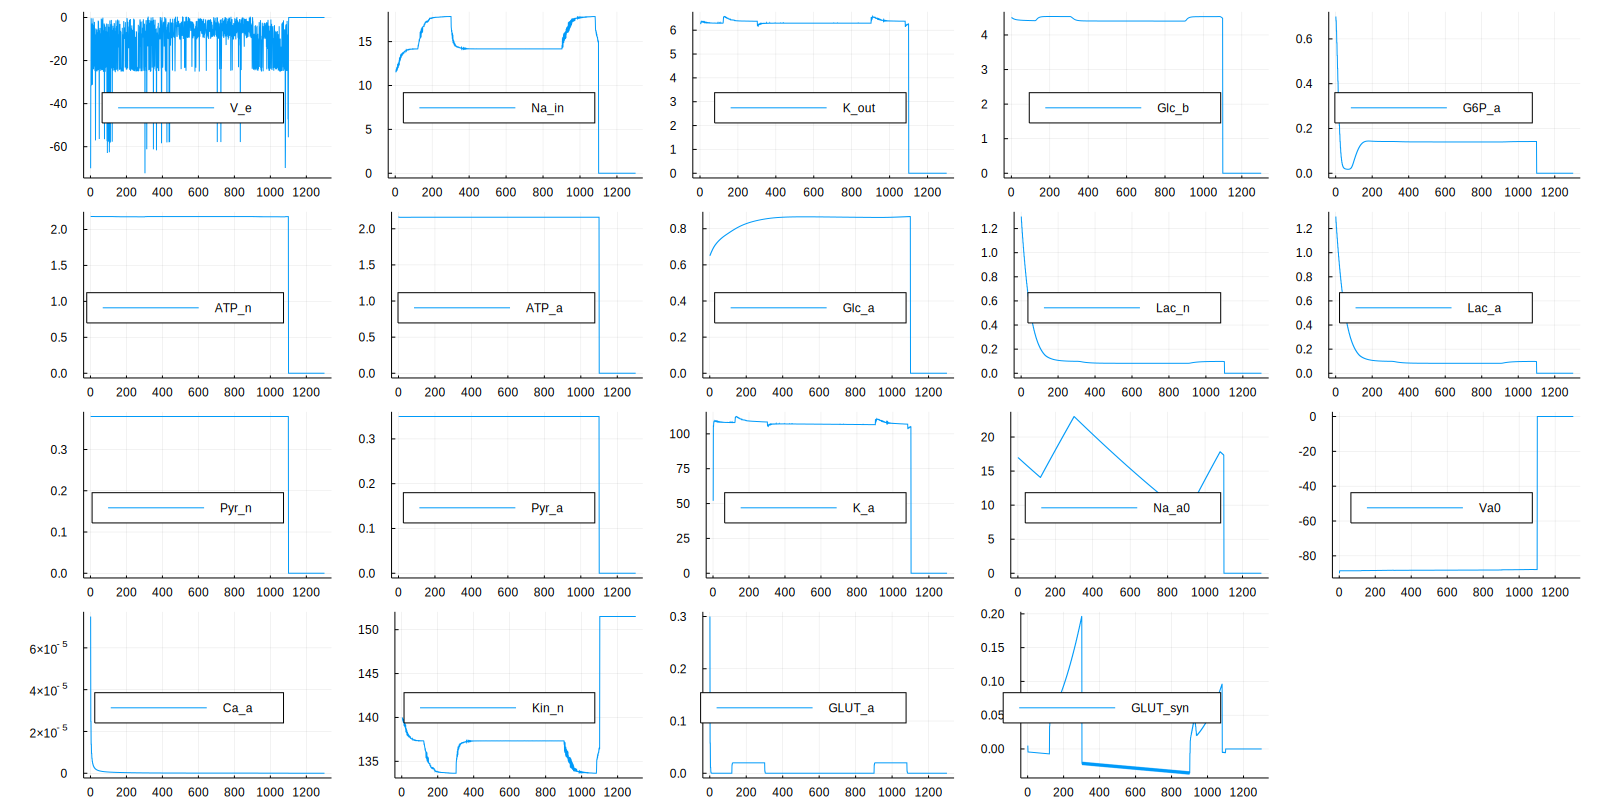

In [27]:
#4)
# detailed Glycolysis


upscale = 8 #8x upscaling in resolution
default(size=(200*upscale,100*upscale))
gr()

p1 = plot(range(1,1301),ue[1,:],labels=["V_e"])
p2 = plot(range(1,1301),um[1,:],labels=["V_m"])
p3 = plot(range(1,1301),um[2,:],labels=["m"])
p4 = plot(range(1,1301),um[3,:],labels=["h"])
p5 = plot(range(1,1301),um[4,:],labels=["n"])
p6 = plot(range(1,1301),um[5,:],labels=["Cl_out"])
p7 = plot(range(1,1301),um[6,:],labels=["Cl_in"])
p8 = plot(range(1,1301),um[7,:],labels=["Na_in"])
p9 = plot(range(1,1301),um[8,:],labels=["K_out"])
p10 = plot(range(1,1301),um[9,:],labels=["Glc_b"])
p11 = plot(range(1,1301),um[10,:],labels=["Lac_b"])
p12 = plot(range(1,1301),um[11,:],labels=["O2_b"])
p13 = plot(range(1,1301),um[12,:],labels=["q of blood flow"])
p14 = plot(range(1,1301),um[13,:],labels=["Glc_ecs"])
p15 = plot(range(1,1301),um[14,:],labels=["Lac_ecs"])
p16 = plot(range(1,1301),um[15,:],labels=["O2_ecs"])
p17 = plot(range(1,1301),um[16,:],labels=["O2_n"])
p18 = plot(range(1,1301),um[17,:],labels=["O2_a"])
p19 = plot(range(1,1301),um[18,:],labels=["Glc_n"])
p20 = plot(range(1,1301),um[19,:],labels=["Glc_a"])
p21 = plot(range(1,1301),um[20,:],labels=["Lac_n"])
p22 = plot(range(1,1301),um[21,:],labels=["Lac_a"])
p23 = plot(range(1,1301),um[22,:],labels=["Pyr_n"])
p24 = plot(range(1,1301),um[23,:],labels=["Pyr_a"])
p25 = plot(range(1,1301),um[24,:],labels=["PCr_n"])
p26 = plot(range(1,1301),um[25,:],labels=["PCr_a"])
p27 = plot(range(1,1301),um[26,:],labels=["Cr_n"])
p28 = plot(range(1,1301),um[27,:],labels=["Cr_a"])
p29 = plot(range(1,1301),um[28,:],labels=["ATP_n"])
p30 = plot(range(1,1301),um[29,:],labels=["ATP_a"])
p31 = plot(range(1,1301),um[30,:],labels=["ADP_n"])
p32 = plot(range(1,1301),um[31,:],labels=["ADP_a"])
p33 = plot(range(1,1301),um[32,:],labels=["NADH_n"])
p34 = plot(range(1,1301),um[33,:],labels=["NADH_a"])
p35 = plot(range(1,1301),um[34,:],labels=["NAD_n"])
p36 = plot(range(1,1301),um[35,:],labels=["NAD_a"])
p37 = plot(range(1,1301),um[36,:],labels=["ksi glutamate stim metab "])
p38 = plot(range(1,1301),um[37,:],labels=["ksi glutamate stim ephys "])
p3938 =  plot(range(1,1301),um[38,:],labels=["G6P_n"])
p39 = plot(range(1,1301),um[39,:],labels=["F6P_n"])
p40 = plot(range(1,1301),um[40,:],labels=["G6P_a"])
p41 = plot(range(1,1301),um[41,:],labels=["F6P_a"])
p42 = plot(range(1,1301),um[42,:],labels=["FBP_n"])
p43 = plot(range(1,1301),um[43,:],labels=["FBP_a"])
p44 = plot(range(1,1301),um[44,:],labels=["AMP_a"])
p45 = plot(range(1,1301),um[45,:],labels=["GAP_n"])
p46 = plot(range(1,1301),um[46,:],labels=["DHAP_n"])
p47 = plot(range(1,1301),um[47,:],labels=["GAP_a"])
p48 = plot(range(1,1301),um[48,:],labels=["DHAP_a"])
p49 = plot(range(1,1301),um[49,:],labels=["Pi_n"])
p50 = plot(range(1,1301),um[50,:],labels=["BPG13_n"])
p51 = plot(range(1,1301),um[51,:],labels=["Pi_a"])
p52 = plot(range(1,1301),um[52,:],labels=["BPG13_a"])
p53 = plot(range(1,1301),um[53,:],labels=["PG3_n"])
p54 = plot(range(1,1301),um[54,:],labels=["PG3_a"])
p55 = plot(range(1,1301),um[55,:],labels=["PG2_n"])
p56 = plot(range(1,1301),um[56,:],labels=["PG2_a"])
p57 = plot(range(1,1301),um[57,:],labels=["PEP_n"])
p58 = plot(range(1,1301),um[58,:],labels=["PEP_a"]);
p59 = plot(range(1,1301),um[59,:],labels=["G1P_a"])
p60 = plot(range(1,1301),um[60,:],labels=["GLY_a"]);
p61 = plot(range(1,1301),um[61,:],labels=["UDPgluco_a"]);
p73 = plot(range(1,1301),um[73,:],labels=["K_a"]);
p74 = plot(range(1,1301),um[74,:],labels=["Na_a0"]);
p75 = plot(range(1,1301),um[75,:],labels=["Va0"]);
p76 = plot(range(1,1301),um[76,:],labels=["Ca_a"]);

p77 = plot(range(1,1301),um[77,:],labels=["GLUT_out"]);
p78 = plot(range(1,1301),um[78,:],labels=["GLUT_a"]);

p81 = plot(range(1,1301),um[81,:],labels=["GLUT_syn"]);

pKin = plot(range(1,1301), fill(151.5,1301)-um[7,:],labels=["Kin_n"]  )
plot(p1,p8,p9,p10,p40,p29,p30, p20,p21,p22,p23,p24,p73,p74,p75,p76,pKin,p78,p81,layout=19)

# plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37)



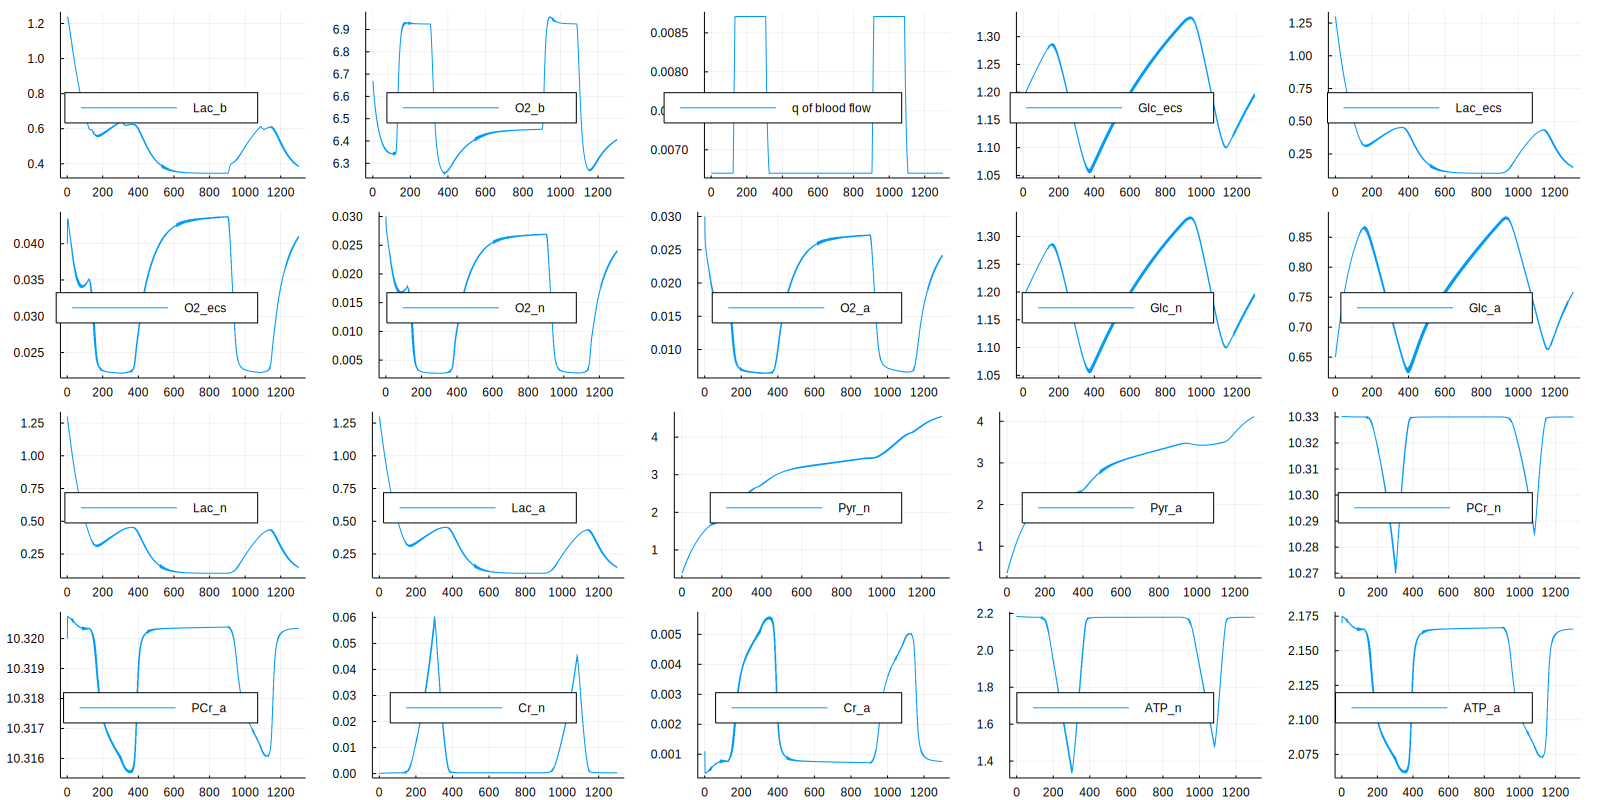

In [12]:
plot(p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,layout=20)

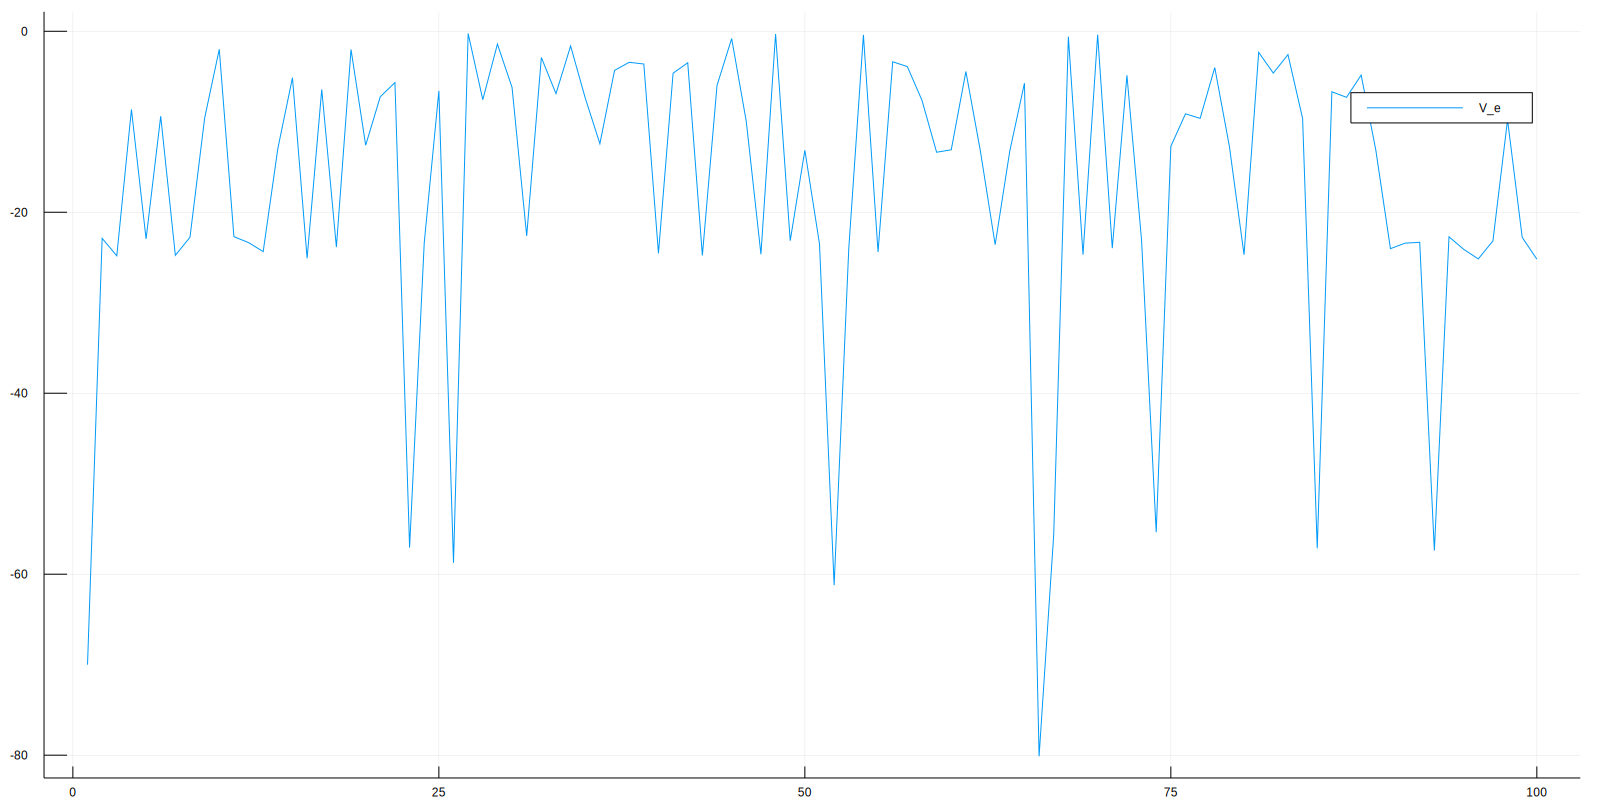

In [13]:
plot(range(1,100),ue[1,1:100],labels=["V_e"])

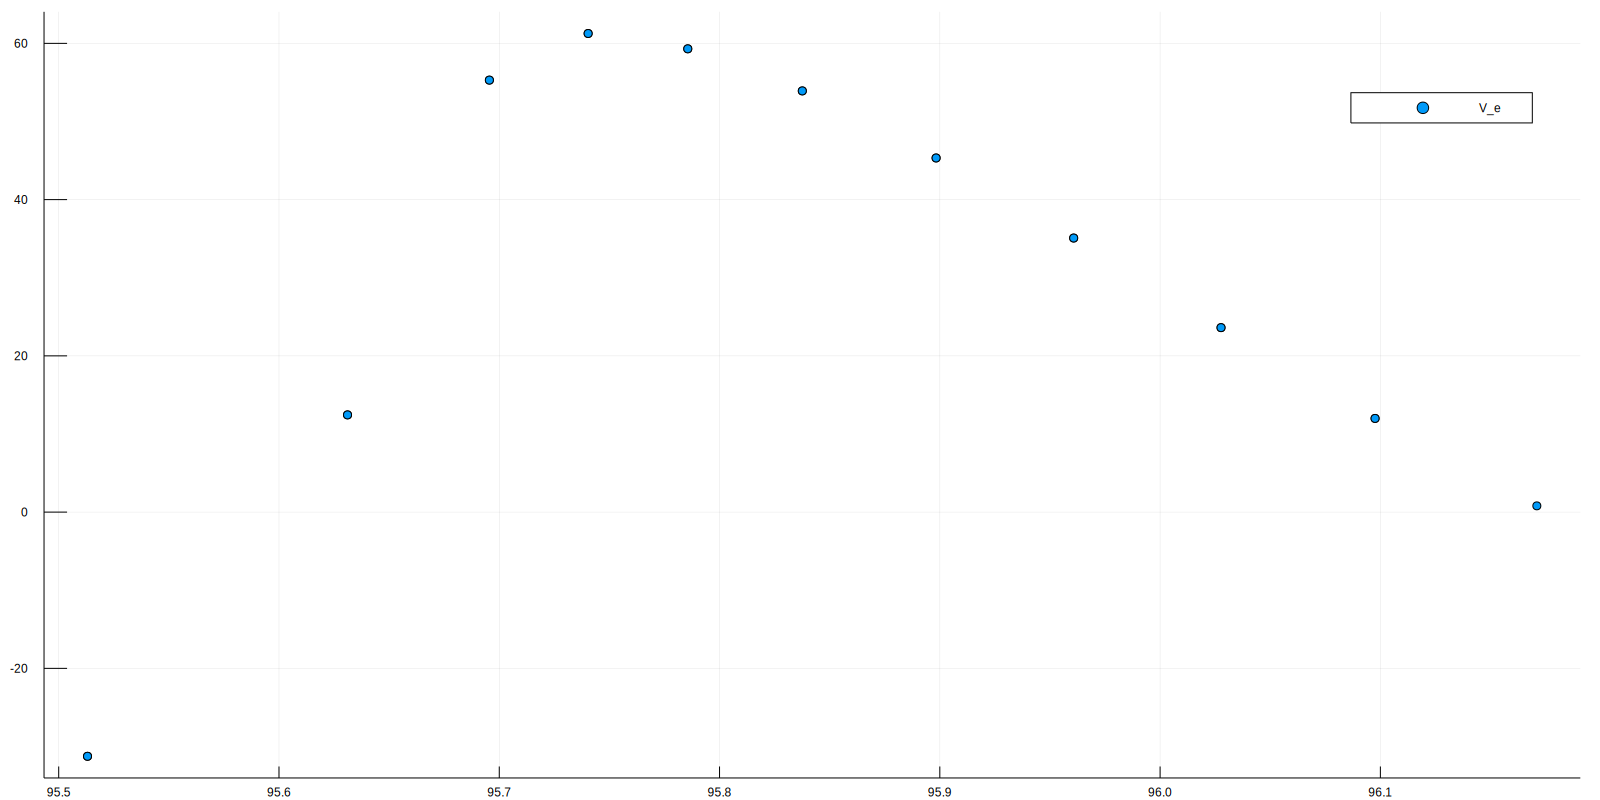

In [14]:
plot(ue_ms_t[1130:1150],ue_ms1[1130:1150],seriestype=:scatter,labels=["V_e"]) # time in ms

open("ue_ms_t_1100_1300", "w") do f
    write(f,ue_ms_t[1100:1300])
end

In [26]:
using DelimitedFiles

writedlm("ue_ms_t_ap.txt",ue_ms_t[1100:1300], "\n")

writedlm("ue_ms_u1_ap.txt",ue_ms1[1100:1300], "\n")

In [15]:
# dVdt
dVdt = [] # zeros(36, 1800) 

for i in 1:1:length(ue_ms_t) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    ksi_ephys = ue_ms37[i] # placeholder for callback activation related to glu # _ephys to be consistent with ms

    V = ue_ms1[i]
    m = ue_ms2[i]
    h = ue_ms3[i]
    n = ue_ms4[i]
    
    # Cressman2011, Calvetti2018
    alpha_m=0.1*(V+30.0)/(1.0-exp(-0.1*(V+30.0)))
    beta_m=4.0*exp(-(V+55.0)/18.0)
    alpha_h=0.07*exp(-(V+44.0)/20.0)
    beta_h=1.0/(1.0+exp(-0.1*(V+14.0)))
    alpha_n=0.01*(V+34.0)/(1.0-exp(-0.1*(V+34.0)))
    beta_n=0.125*exp(-(V+44.0)/80.0)

    
    # Concentrations Calvetti2018
    Naout = 144.0 - beta*(ue_ms7[i] - 11.5) # mM  # u7 = Na0in
    Kin = 140.0 + (11.5 - ue_ms7[i]) # u7 = Na0in

    # Nernst eq, Calvetti2018

    VCl = -26.64*log(clamp(ue_ms5[i],1e-12,ue_ms5[i])/clamp(ue_ms6[i],1e-12,ue_ms6[i])) # when ksi u5 = Conc_Cl_out, u6 = Conc_Cl_in # log=ln in Julia
    VK = 26.64*log(clamp(ue_ms8[i],1e-12,ue_ms8[i])/clamp(Kin,1e-12,Kin)) # clamp(x,1e-12,x) # u8 = K0out
    VNa = 26.64*log(clamp(Naout,1e-12,Naout)/clamp(ue_ms7[i],1e-12,ue_ms7[i])) # u7 = Na0in

    gNaleak = (1+ksi_ephys)*gNa0leak
    gKleak = (1+ksi_ephys)*gK0leak

    INa = gNa*(m^3)*h*(V-VNa) +  gNaleak*(V-VNa) # based on  Calvetti2018 gNaleak depends on ksi and glutamate activation # in Calvetti2018 & Cressman2009 m(V) = m_inf = alpha_m/(alpha_m+beta_m)
    IK = gK*(n^4)*(V-VK) + gKleak*(V-VK)  # based on Calvetti2018 gKleak depends on ksi and glutamate activation
    Ileak = gCl * (V-VCl)


    p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])


    JpumpNa = (p_n_ratio/(mu_pump_ephys + p_n_ratio)) * (rho/(1+exp((25.0 -ue_ms7[i])/3))) * (1/(1+exp(5.5 - ue_ms8[i])))
    JgliaK = (p_a_ratio/(mu_glia_ephys + p_a_ratio)) * (glia/(1+exp((18.0 - ue_ms8[i])/2.5)))
    JdiffK = epsilon*(ue_ms8[i] - kbath)

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti =  (1/Cm) * (- INa - IK - Ileak ) 
    append!(dVdt,dvdti)
end


writedlm("dvdt_V.txt",ue_ms1[1:10000], "\n")

writedlm("dvdt_dVdt.txt",dVdt[1:10000], "\n")

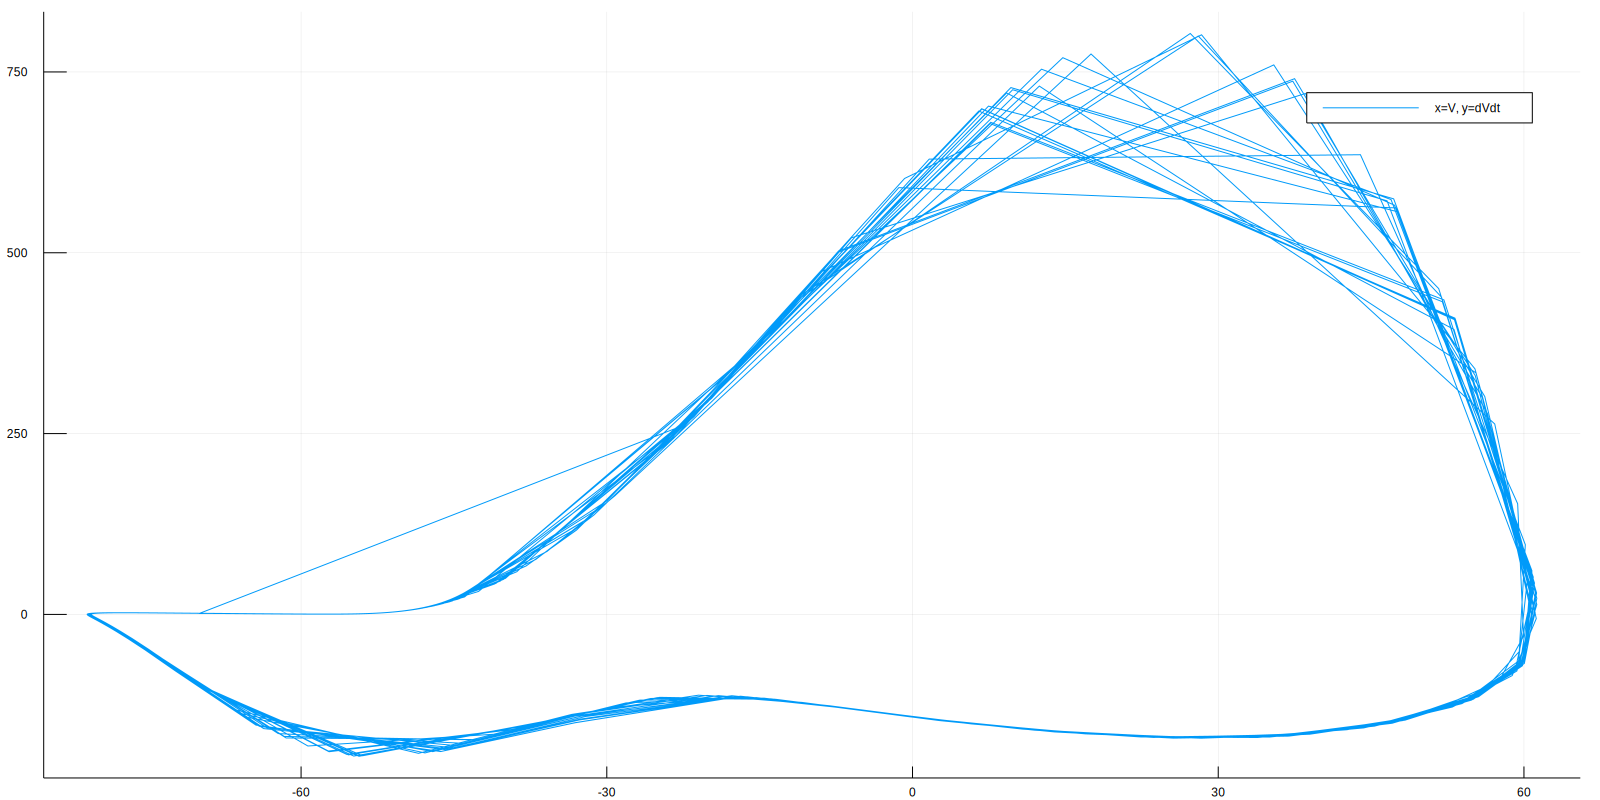

In [16]:
plot(ue_ms1[1:10000],dVdt[1:10000],labels=["x=V, y=dVdt"])

In [ ]:
plot(ue_ms1[1:10000],dVdt[1:10000],seriestype=:scatter,labels=["x=V, y=dVdt"])

In [ ]:
plot(ue_ms1[1:length(dVdt)],dVdt,seriestype=:scatter,labels=["x=V, y=dVdt"])

In [ ]:
print('q')

In [17]:
length(dVdt)

4621288

In [31]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(ue_ms_t) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (ue_ms29[i]-ue_ms29[i-1])/(ue_ms_t[i]-ue_ms_t[i-1])
    
    
    append!(dVdt1,dvdti1)
end

In [36]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(um[29,:]) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (um[29,:][i]-um[29,:][i-1])
    
    append!(dVdt1,dvdti1)
end

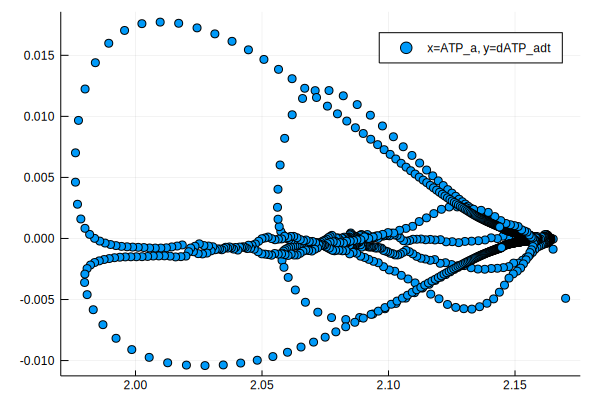

In [38]:
plot(um[29,:][1:(length(um[29,:])-1)],dVdt1,seriestype=:scatter,labels=["x=ATP_a, y=dATP_adt"])

In [39]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(um[35,:]) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (um[35,:][i]-um[35,:][i-1])
    
    append!(dVdt1,dvdti1)
end

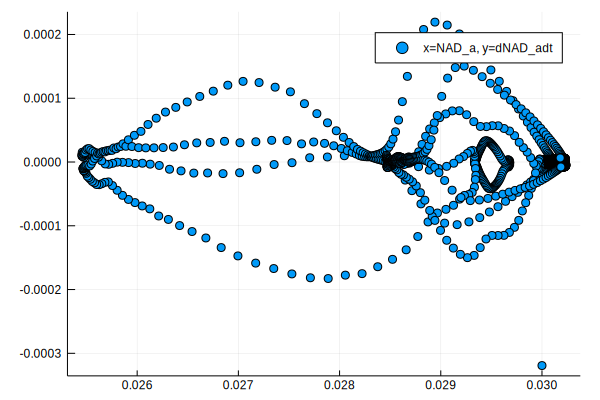

In [43]:
plot(um[35,:][1:(length(um[35,:])-1)],dVdt1[1:length(dVdt1)],seriestype=:scatter,labels=["x=NAD_a, y=dNAD_adt"])

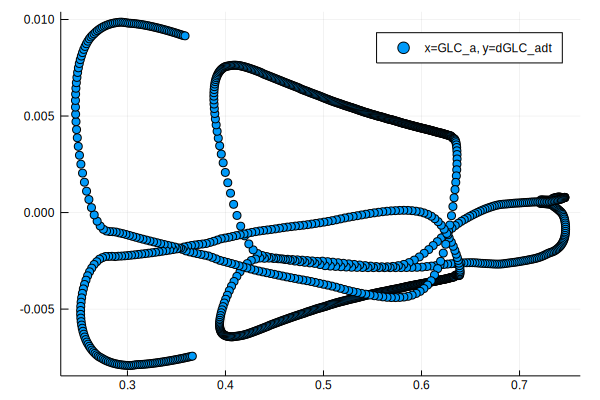

In [47]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(um[19,:]) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (um[19,:][i]-um[19,:][i-1])
    
    append!(dVdt1,dvdti1)
end

plot(um[19,:][100:(length(um[19,:])-1)],dVdt1[100:length(dVdt1)],seriestype=:scatter,labels=["x=GLC_a, y=dGLC_adt"])

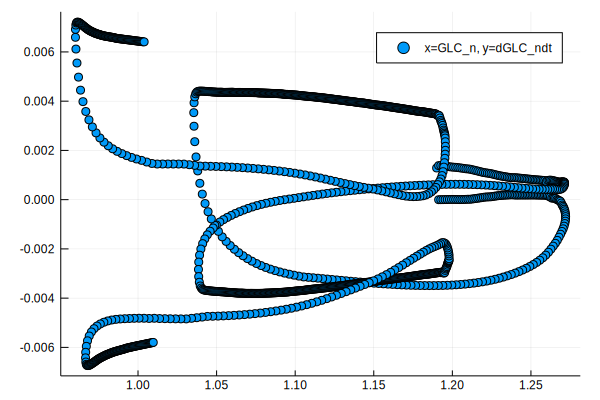

In [49]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(um[18,:]) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (um[18,:][i]-um[18,:][i-1])
    
    append!(dVdt1,dvdti1)
end

plot(um[18,:][1:(length(um[18,:])-1)],dVdt1[1:length(dVdt1)],seriestype=:scatter,labels=["x=GLC_n, y=dGLC_ndt"])

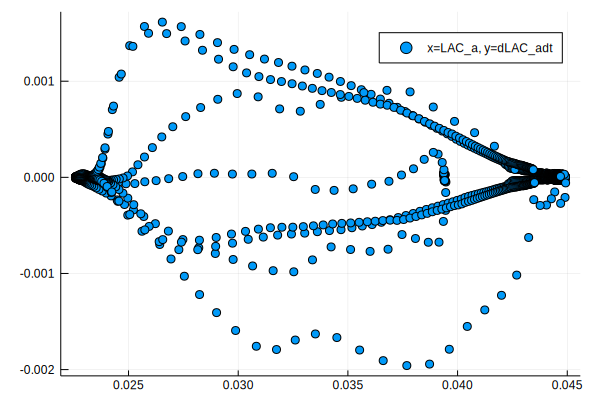

In [46]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(um[21,:]) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (um[21,:][i]-um[21,:][i-1])
    
    append!(dVdt1,dvdti1)
end

plot(um[21,:][100:(length(um[21,:])-1)],dVdt1[100:length(dVdt1)],seriestype=:scatter,labels=["x=LAC_a, y=dLAC_adt"])

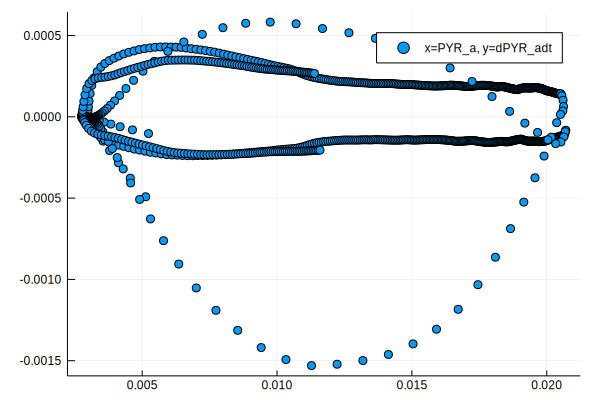

In [52]:
dVdt1 = [] # zeros(36, 1800) 

for i in 2:1:length(um[23,:]) # s # should be 1800.0 s
    global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,ue_ms,ue_ms_t 
    #global prob_metabo,prob_ephys,sol_m,sol_e,ue,um,  p_n_ratio,p_a_ratio
    
    
    #p_n_ratio = clamp(ue_ms28[i],1e-12,ue_ms28[i])/clamp(ue_ms30[i],1e-12,ue_ms30[i]) #u28 = ATP_n # u30 = ADP_n
    #p_a_ratio = clamp(ue_ms29[i],1e-12,ue_ms29[i])/clamp(ue_ms31[i],1e-12,ue_ms31[i])
    #r_n_ratio = clamp(ue_ms32[i],1e-12,ue_ms32[i])/clamp(ue_ms34[i],1e-12,ue_ms34[i]) # u32 = NADH_n # u34 = NAD_n
    #r_a_ratio = clamp(ue_ms33[i],1e-12,ue_ms33[i])/clamp(ue_ms35[i],1e-12,ue_ms35[i])

    # dV/dt
    #dVdt[i] = (1/Cm) * (- INa - IK - Ileak )  # with external stimuli being modelled as ksi
    dvdti1 = (um[23,:][i]-um[23,:][i-1])
    
    append!(dVdt1,dvdti1)
end

plot(um[23,:][300:(length(um[23,:])-1)],dVdt1[300:length(dVdt1)],seriestype=:scatter,labels=["x=PYR_a, y=dPYR_adt"])

In [ ]:

# u1 = VNeu0
# u2 = m0
# u3 = h0
# u4 = n0
# u5 = Conc_Cl_out
# u6 = Conc_Cl_in
# u7 = Na0in
# u8 = K0out
# u9 = Glc_b
# u10 = Lac_b
# u11 = O2_b
# u12 = q # blood flow, used for callback
# u13 = Glc_ecs
# u14 = Lac_ecs
# u15 = O2_ecs

# u16 = O2_n
# u17 = O2_a
# u18 = Glc_n
# u19 = Glc_a
# u20 = Lac_n
# u21 = Lac_a
# u22 = Pyr_n
# u23 = Pyr_a
# u24 = PCr_n
# u25 = PCr_a
# u26 = Cr_n
# u27 = Cr_a
# u28 = ATP_n
# u29 = ATP_a
# u30 = ADP_n
# u31 = ADP_a
# u32 = NADH_n
# u33 = NADH_a
# u34 = NAD_n
# u35 = NAD_a
# u36 = ksi
# u37 = ksi_ephys

# u38 = G6P_n  
# u39 = F6P_n
# u40 = G6P_a    
# u41 = F6P_a    
# u42 = FBP_n    
# u43 = FBP_a    
# u44 = AMP_a    
# u45 = GAP_n
# u46 = DHAP_n    
# u47 = GAP_a 
# u48 = DHAP_a
# u49 = Pi_n  
# u50 = BPG13_n   
# u51 = Pi_a 
# u52 = BPG13_a 
# u53 = PG3_n
# u54 = PG3_a
# u55 = PG2_n
# u56 = PG2_a
# u57 = PEP_n
# u58 = PEP_a
# u59 = G1P_a
# u60 = GLY_a
# u61 = UDPgluco
# u62 = UTP
# u63 = PP1_a
# u64 = GS_a
# u65 = GPa_a
# u66 = GPb_a
# u67 = cAMP_a
# u68 = PKAa_a
# u69 = PKAb_a
# u70 = PHKa_a
# u71 = R2CcAMP2_a
# u72 = R2CcAMP4_a
#u73 = K_a0 =  52.0 #Witthoft2013 # 130.0 # approx
#u74 = Na_a0 = 17.0 #Witthoft2013 
# u75 = Va0
# u[76] =  Ca_a
# u77 = GLUT_out
# u78 = GLUT_a
# u79 = GLN_out
# u80 = GLN_a

# u81 = GLUT_syn #### Breslin2018 microdomains & Flanagan2018
# u82 = GLUT_release #### placeholder for callback




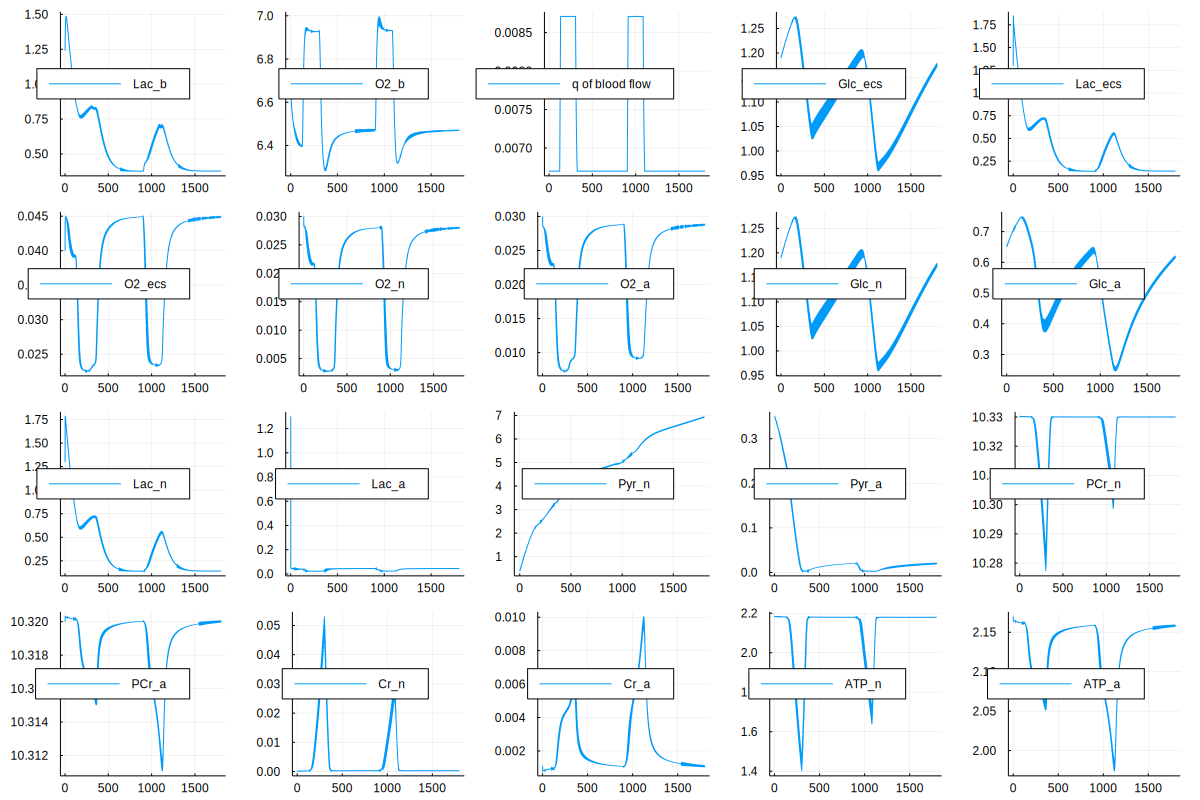

In [94]:
plot(p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,layout=20)

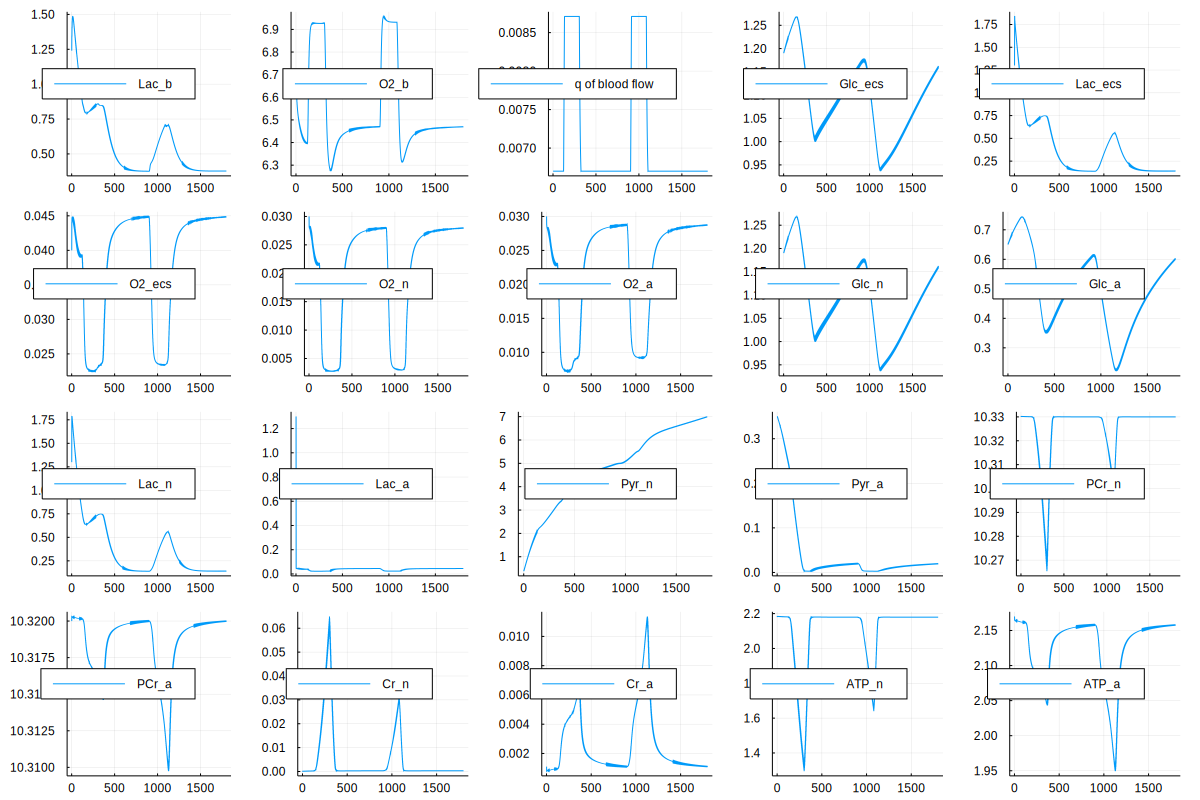

In [14]:
plot(p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,layout=20)